# **Mount Google Drive & install package**

Pada tahap ini dilakukan persiapan lingkungan kerja di Google Colab sebelum masuk ke proses penelitian utama. Input pada tahap ini berupa akun Google Drive yang berisi dataset dan file pendukung penelitian, serta kebutuhan library yang akan digunakan. Proses diawali dengan melakukan mount Google Drive menggunakan fungsi drive.mount('/content/drive'), sehingga seluruh file yang tersimpan di Google Drive dapat diakses melalui direktori /content/drive. Selanjutnya dilakukan instalasi beberapa library pendukung, yaitu wfdb untuk membaca dan memproses dataset sinyal EKG dari PhysioNet (MIT-BIH Atrial Fibrillation Database), py7zr untuk mengekstrak dataset SHDB-AF yang berformat .7z, serta torch, torchvision, dan torchaudio sebagai framework utama dalam pembangunan dan pelatihan model deep learning. Output dari tahap ini adalah lingkungan Google Colab yang telah terhubung dengan Google Drive dan seluruh library yang dibutuhkan telah siap digunakan, sehingga dataset EKG dapat diakses dan diproses pada tahap preprocessing dan pelatihan model selanjutnya.

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install wfdb py7zr torch torchvision torchaudio

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 91.2/91.2 kB 6.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 163.8/163.8 kB 15.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 71.4/71.4 kB 6.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 494.2/494.2 kB 32.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100.6/100.6 kB 9.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.4/12.4 MB 162.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.5/51.5 kB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 144.3/144.3 kB 13.4 MB/s eta 0:00:00
  Attempting uninstall: pandas
    Found existing installation: pandas 2.2.2
    Uninstalling pandas-2.2.2:
      Successfully uninstalled pandas-2.2.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires pandas

# **Set path dataset & extract SHDB (.7z)**

Pada tahap ini dilakukan penentuan lokasi penyimpanan dataset dan proses ekstraksi dataset tambahan yang digunakan dalam penelitian. Input pada tahap ini berupa direktori Google Drive yang berisi dataset MIT-BIH Atrial Fibrillation Database dalam bentuk folder serta dataset SHDB-AF yang masih terkompresi dalam format .7z. Proses diawali dengan mendefinisikan direktori utama (BASE_DIR) yang mengarah ke folder tugas akhir di Google Drive, kemudian menetapkan path khusus untuk dataset MIT-BIH AFDB (MITDB_DIR) dan file arsip SHDB-AF (SHDB_ARCHIVE). Selanjutnya ditentukan folder tujuan ekstraksi dataset SHDB (SHDB_DIR), dan dilakukan proses ekstraksi menggunakan library py7zr. Output dari tahap ini adalah tersedianya dua dataset EKG yang siap digunakan, yaitu dataset MIT-BIH AFDB yang dapat diakses langsung melalui folder penyimpanan serta dataset SHDB-AF yang telah berhasil diekstraksi ke dalam direktori khusus, sehingga seluruh data dapat digunakan pada tahap preprocessing dan segmentasi sinyal EKG selanjutnya.

In [6]:
import os

BASE_DIR = "/content/drive/MyDrive/Tugas Akhir"

MITDB_DIR = os.path.join(
    BASE_DIR,
    "mit-bih-atrial-fibrillation-database-1.0.0 (1)",
    "files"             # kalau di dalamnya ada folder "files"
)

SHDB_ARCHIVE = os.path.join(BASE_DIR, "SHDB-AF-ULTRA.7z")
SHDB_DIR = os.path.join(BASE_DIR, "SHDB_AF")   # folder hasil ekstrak

print(MITDB_DIR)
print(SHDB_ARCHIVE)
print(SHDB_DIR)


/content/drive/MyDrive/Tugas Akhir/mit-bih-atrial-fibrillation-database-1.0.0 (1)/files
/content/drive/MyDrive/Tugas Akhir/SHDB-AF-ULTRA.7z
/content/drive/MyDrive/Tugas Akhir/SHDB_AF


In [7]:
#Ekstrak SHDB:
import py7zr

os.makedirs(SHDB_DIR, exist_ok=True)

with py7zr.SevenZipFile(SHDB_ARCHIVE, mode='r') as z:
    z.extractall(path=SHDB_DIR)

print("Done extract SHDB.")

Done extract SHDB.


# **Fungsi baca semua record & buat window + label (AFIB, AFL, NORMAL)**

Pada tahap ini dilakukan pembacaan seluruh rekaman sinyal EKG dari dataset MIT-BIH Atrial Fibrillation Database dan SHDB-AF, dilanjutkan dengan proses segmentasi sinyal dan pemberian label kelas. Input pada tahap ini berupa file rekaman EKG mentah berformat .dat, .hea, dan .atr yang tersimpan pada direktori dataset di Google Drive. Proses diawali dengan identifikasi seluruh record EKG menggunakan fungsi pencarian file .dat, kemudian setiap record dibaca menggunakan library wfdb. Anotasi ritme jantung diekstraksi dari file anotasi (.atr) dengan memanfaatkan atribut aux_note, lalu dikonversi menjadi label ritme per sampel yang terdiri dari tiga kelas, yaitu Atrial Fibrillation (AFIB), Atrial Flutter (AFL), dan Normal. Selanjutnya, sinyal EKG disegmentasi menjadi potongan sinyal berdurasi 10 detik tanpa overlap (windowing), di mana setiap window diberikan satu label berdasarkan ritme mayoritas yang muncul dalam segmen tersebut. Untuk memastikan keseragaman dimensi data, seluruh window dari kedua dataset dipadatkan (padding) hingga memiliki panjang yang sama, yaitu 2500 sampel per window. Output dari tahap ini adalah dataset sinyal EKG tersegmentasi yang telah diberi label, terdiri dari 445.633 window dengan ukuran seragam, beserta distribusi kelas AFIB, AFL, dan Normal yang selanjutnya digunakan sebagai input pada tahap pelatihan model deep learning.

In [8]:
# =========================
# 0) IMPORT & CONFIG
# =========================
import os, glob, re
import numpy as np
import wfdb
from scipy.signal import resample_poly
from math import gcd
import pandas as pd

# --- PATH DATASET (sesuaikan punyamu) ---
AFDB_DIR = "/content/drive/MyDrive/Tugas Akhir/mit-bih-atrial-fibrillation-database-1.0.0 (1)/files"
SHDB_DIR = "/content/drive/MyDrive/Tugas Akhir/SHDB-AF/1.0.1"

OUT_DIR  = "/content/drive/MyDrive/Tugas Akhir"
os.makedirs(OUT_DIR, exist_ok=True)

# --- PREPROCESS / WINDOW CONFIG (ini hyperparameter preprocessing) ---
TARGET_FS  = 200
WINDOW_SEC = 10
STEP_SEC   = 10
LEAD_IDX   = 0

LABEL_MAP = {"AFIB": 0, "AFL": 1, "NORMAL": 2}
LABEL_NAMES = ["AFIB", "AFL", "NORMAL"]

# (opsional) supaya label window "lebih yakin"
# kalau kamu set 0.7 artinya minimal 70% sampel di window harus label yg sama
PURITY_TH = 0.0  # 0.0 = majority vote biasa; coba 0.6-0.8 kalau AFL terlalu "ketelan"


In [9]:
# =========================
# 1) UTIL: LIST RECORD BASE (.hea) & DETECT ANNOTATION
# =========================
def list_record_bases(data_dir):
    """
    Ambil base path record dari file .hea (paling aman untuk wfdb).
    Return: list of base path tanpa ekstensi.
    """
    hea_files = glob.glob(os.path.join(data_dir, "**", "*.hea"), recursive=True)
    bases = sorted(list(set([f[:-4] for f in hea_files])))
    return bases

def detect_ann_ext(rec_base, candidates=("atr", "qrs", "ecg")):
    """
    Cari annotation extension yang bener-bener ada file-nya.
    Misal: rec_base.atr, rec_base.qrs, ...
    Return ext atau None.
    """
    for ext in candidates:
        if os.path.exists(rec_base + f".{ext}"):
            return ext
    return None

def normalize_aux(note: str) -> str:
    if note is None:
        return ""
    s = note.strip().upper()
    s = s.replace("(", "").replace(")", "")
    s = re.sub(r"\s+", "", s)
    return s


In [10]:
# =========================
# 2) UTIL: RESAMPLE + SCALE ANN SAMPLE INDEX
# =========================
def resample_1d(sig, orig_fs, target_fs):
    sig = sig.astype(np.float32)
    if int(orig_fs) == int(target_fs):
        return sig, int(orig_fs)

    up = int(target_fs)
    down = int(orig_fs)
    g = gcd(up, down)
    up //= g
    down //= g

    y = resample_poly(sig, up, down).astype(np.float32)
    return y, int(target_fs)

def scale_ann_samples(ann_samples, orig_fs, target_fs):
    if int(orig_fs) == int(target_fs):
        return ann_samples.astype(int)
    factor = float(target_fs) / float(orig_fs)
    return np.rint(ann_samples * factor).astype(int)


In [11]:
# =========================
# 3) BUILD RHYTHM PER SAMPLE (dari aux_note)
# =========================
def build_rhythm_array_int(signal_len, ann):
    """
    Output: array int label per sample (0/1/2)
    Default NORMAL.
    Menggunakan ann.aux_note (lebih cocok untuk rhythm annotation).
    """
    y = np.full(signal_len, LABEL_MAP["NORMAL"], dtype=np.int64)

    samples = ann.sample
    aux = ann.aux_note if hasattr(ann, "aux_note") else [""] * len(samples)

    current = LABEL_MAP["NORMAL"]

    for i, s in enumerate(samples):
        note = normalize_aux(aux[i])

        # update label berdasarkan note
        if "AFIB" in note:
            current = LABEL_MAP["AFIB"]
        elif "AFL" in note:
            current = LABEL_MAP["AFL"]
        elif note != "":
            # note lain dianggap normal (sesuaikan jika dataset kamu punya label rhythm lain)
            current = LABEL_MAP["NORMAL"]

        start = int(s)
        end = int(samples[i+1]) if i+1 < len(samples) else signal_len
        start = max(0, min(start, signal_len))
        end   = max(0, min(end, signal_len))
        if end > start:
            y[start:end] = current

    return y


In [12]:
# =========================
# 4) WINDOWING (INI YANG KAMU BUTUH)
# =========================
def make_windows_from_record(rec_base, target_fs=TARGET_FS):
    """
    Return:
      X: (n_windows, win_len)
      y: (n_windows,)
      fs_orig, fs_used, rec_id, ann_ext
    """
    # record
    rec = wfdb.rdrecord(rec_base)
    fs_orig = float(rec.fs)
    sig = rec.p_signal[:, LEAD_IDX].astype(np.float32)

    # ann ext detection
    ann_ext = detect_ann_ext(rec_base)
    if ann_ext is None:
        raise FileNotFoundError(f"Annotation not found for {rec_base} (no .atr/.qrs/.ecg)")

    ann = wfdb.rdann(rec_base, ann_ext)

    # resample signal to target_fs
    sig_rs, fs_used = resample_1d(sig, fs_orig, target_fs)

    # scale annotation sample positions to target_fs
    ann.sample = scale_ann_samples(ann.sample, fs_orig, fs_used)

    # build rhythm label per-sample (int)
    rhy = build_rhythm_array_int(len(sig_rs), ann)

    win_len  = int(WINDOW_SEC * fs_used)
    step_len = int(STEP_SEC * fs_used)

    X_list, y_list = [], []

    # pakai +1 supaya window terakhir ikut kalau pas banget
    for start in range(0, len(sig_rs) - win_len + 1, step_len):
        end = start + win_len
        w_sig = sig_rs[start:end]
        w_rhy = rhy[start:end]

        # hitung distribusi label dalam window
        cnt = np.bincount(w_rhy, minlength=3)
        maj = int(cnt.argmax())
        purity = float(cnt[maj]) / float(win_len)

        # optional filter purity
        if purity < PURITY_TH:
            continue

        X_list.append(w_sig)
        y_list.append(maj)

    if len(X_list) == 0:
        return np.empty((0, win_len), np.float32), np.empty((0,), np.int64), fs_orig, fs_used, os.path.basename(rec_base), ann_ext

    X = np.stack(X_list).astype(np.float32)
    y = np.array(y_list, dtype=np.int64)
    return X, y, fs_orig, fs_used, os.path.basename(rec_base), ann_ext


In [13]:
# =========================
# 5) LOAD 1 FOLDER DATASET (AMAN) + SIMPAN RINGKASAN CSV
# =========================
def load_dataset_from_dir(data_dir, name="DATASET", target_fs=TARGET_FS):
    recs = list_record_bases(data_dir)
    print(f"{name} records ditemukan: {len(recs)}")

    X_all, y_all, g_all = [], [], []
    rows = []

    for rec_base in recs:
        rec_id = os.path.basename(rec_base)
        try:
            X_rec, y_rec, fs_orig, fs_used, rec_id2, ann_ext = make_windows_from_record(rec_base, target_fs=target_fs)

            # simpan log per record
            rows.append({
                "dataset": name,
                "record": rec_id,
                "fs_orig": fs_orig,
                "fs_used": fs_used,
                "ann_ext": ann_ext,
                "n_windows": int(X_rec.shape[0]),
                "status": "OK",
                "error": ""
            })

            if X_rec.shape[0] > 0:
                X_all.append(X_rec)
                y_all.append(y_rec)
                g_all.append(np.array([rec_id]*len(y_rec), dtype=object))

            print(f"{rec_id} -> {X_rec.shape[0]} windows (fs {fs_orig:.0f}->{fs_used})")

        except Exception as e:
            rows.append({
                "dataset": name,
                "record": rec_id,
                "fs_orig": np.nan,
                "fs_used": target_fs,
                "ann_ext": None,
                "n_windows": 0,
                "status": "SKIP",
                "error": repr(e)
            })
            print("SKIP", rec_id, "->", e)

    df_log = pd.DataFrame(rows)

    if len(X_all) == 0:
        X = np.empty((0, int(WINDOW_SEC*target_fs)), np.float32)
        y = np.empty((0,), np.int64)
        g = np.empty((0,), object)
    else:
        X = np.concatenate(X_all, axis=0)
        y = np.concatenate(y_all, axis=0)
        g = np.concatenate(g_all, axis=0)

    return X, y, g, df_log


In [14]:
# =========================
# 6) JALANKAN: LOAD AFDB + SHDB, GABUNG, DISTRIBUSI
# =========================
X_afdb, y_afdb, g_afdb, log_afdb = load_dataset_from_dir(AFDB_DIR, name="AFDB", target_fs=TARGET_FS)
X_shdb, y_shdb, g_shdb, log_shdb = load_dataset_from_dir(SHDB_DIR, name="SHDB", target_fs=TARGET_FS)

X_all = np.concatenate([X_afdb, X_shdb], axis=0) if (len(X_afdb) and len(X_shdb)) else (X_afdb if len(X_afdb) else X_shdb)
y_all = np.concatenate([y_afdb, y_shdb], axis=0) if (len(y_afdb) and len(y_shdb)) else (y_afdb if len(y_afdb) else y_shdb)
g_all = np.concatenate([g_afdb, g_shdb], axis=0) if (len(g_afdb) and len(g_shdb)) else (g_afdb if len(g_afdb) else g_shdb)

print("\nFINAL:", X_all.shape, y_all.shape)
if y_all.size > 0:
    dist = np.bincount(y_all, minlength=3)
    print("Distribusi [AFIB, AFL, NORMAL]:", dist)
    print("Distribusi detail:")
    for i, c in enumerate(dist):
        print(f"- {LABEL_NAMES[i]}: {c}")
else:
    print("Dataset kosong. Cek path / annotation ext / error log.")


AFDB records ditemukan: 25
SKIP 00735 -> sampto must be greater than sampfrom
SKIP 03665 -> sampto must be greater than sampfrom
04015 -> 3682 windows (fs 250->200)
04043 -> 3682 windows (fs 250->200)
04048 -> 3682 windows (fs 250->200)
04126 -> 3682 windows (fs 250->200)
04746 -> 3682 windows (fs 250->200)
04908 -> 3682 windows (fs 250->200)
04936 -> 3682 windows (fs 250->200)
05091 -> 3682 windows (fs 250->200)
05121 -> 3682 windows (fs 250->200)
05261 -> 3682 windows (fs 250->200)
06426 -> 3682 windows (fs 250->200)
06453 -> 3330 windows (fs 250->200)
06995 -> 3682 windows (fs 250->200)
07162 -> 3682 windows (fs 250->200)
07859 -> 3682 windows (fs 250->200)
07879 -> 3682 windows (fs 250->200)
07910 -> 3682 windows (fs 250->200)
08215 -> 3682 windows (fs 250->200)
08219 -> 3682 windows (fs 250->200)
08378 -> 3682 windows (fs 250->200)
08405 -> 3682 windows (fs 250->200)
08434 -> 3682 windows (fs 250->200)
08455 -> 3682 windows (fs 250->200)
SHDB records ditemukan: 43
001 -> 8610 wind

In [15]:
import os
import numpy as np
import pandas as pd

OUT_DIR  = "/content/drive/MyDrive/Tugas Akhir"
os.makedirs(OUT_DIR, exist_ok=True)

# =========================
# 1) Simpan log per-record (AFDB & SHDB)
# =========================
afdb_csv = os.path.join(OUT_DIR, "log_windows_AFDB.csv")
shdb_csv = os.path.join(OUT_DIR, "log_windows_SHDB.csv")

log_afdb.to_csv(afdb_csv, index=False)
log_shdb.to_csv(shdb_csv, index=False)

print("✅ Log tersimpan:")
print("AFDB ->", afdb_csv, "| rows:", len(log_afdb))
print("SHDB ->", shdb_csv, "| rows:", len(log_shdb))

# =========================
# 2) Simpan ringkasan dataset gabungan
# =========================
def bincount3(y):
    if y is None or len(y) == 0:
        return [0, 0, 0]
    return np.bincount(y, minlength=3).tolist()

dist_afdb = bincount3(y_afdb)
dist_shdb = bincount3(y_shdb)
dist_all  = bincount3(y_all)

summary = pd.DataFrame([
    {"dataset":"AFDB", "n_records_ok": int((log_afdb["status"]=="OK").sum()),
     "n_windows": int(len(y_afdb)), "AFIB": dist_afdb[0], "AFL": dist_afdb[1], "NORMAL": dist_afdb[2]},
    {"dataset":"SHDB", "n_records_ok": int((log_shdb["status"]=="OK").sum()),
     "n_windows": int(len(y_shdb)), "AFIB": dist_shdb[0], "AFL": dist_shdb[1], "NORMAL": dist_shdb[2]},
    {"dataset":"ALL",  "n_records_ok": int((log_afdb["status"]=="OK").sum() + (log_shdb["status"]=="OK").sum()),
     "n_windows": int(len(y_all)),  "AFIB": dist_all[0],  "AFL": dist_all[1],  "NORMAL": dist_all[2]},
])

summary_csv = os.path.join(OUT_DIR, "summary_dataset_gabungan.csv")
summary.to_csv(summary_csv, index=False)

print("✅ Summary tersimpan:", summary_csv)
display(summary)

# =========================
# 3) Simpan “preview isi dataset gabungan”
#    (contoh 200 nilai pertama per window)
# =========================
LABEL_NAMES = ["AFIB","AFL","NORMAL"]

n_preview = min(50, len(y_all))   # ambil 50 window pertama
n_values  = 200                   # simpan 200 nilai awal supaya file nggak kebesaran

rows = []
for i in range(n_preview):
    rows.append({
        "idx": i,
        "record": str(g_all[i]),
        "label_id": int(y_all[i]),
        "label_name": LABEL_NAMES[int(y_all[i])],
        "fs_used": int(TARGET_FS),
        "first_values": ",".join([f"{v:.6f}" for v in X_all[i][:n_values]])
    })

preview_df = pd.DataFrame(rows)
preview_csv = os.path.join(OUT_DIR, "sample_preview_windows.csv")
preview_df.to_csv(preview_csv, index=False)

print("✅ Preview tersimpan:", preview_csv)
display(preview_df.head())

# =========================
# 4) (OPSIONAL) Simpan dataset hasil preprocessing
#    Hati-hati: bisa besar banget!
# =========================
SAVE_NPY = True  # ubah ke False kalau storage Drive kamu terbatas

if SAVE_NPY:
    np.save(os.path.join(OUT_DIR, "X_all_200Hz_10s.npy"), X_all)
    np.save(os.path.join(OUT_DIR, "y_all_200Hz_10s.npy"), y_all)
    np.save(os.path.join(OUT_DIR, "g_all_record_ids.npy"), g_all)

    print("✅ NPY dataset tersimpan:")
    print("- X_all_200Hz_10s.npy")
    print("- y_all_200Hz_10s.npy")
    print("- g_all_record_ids.npy")


✅ Log tersimpan:
AFDB -> /content/drive/MyDrive/Tugas Akhir/log_windows_AFDB.csv | rows: 25
SHDB -> /content/drive/MyDrive/Tugas Akhir/log_windows_SHDB.csv | rows: 43
✅ Summary tersimpan: /content/drive/MyDrive/Tugas Akhir/summary_dataset_gabungan.csv


,dataset,n_records_ok,n_windows,AFIB,AFL,NORMAL
0,AFDB,23,84334,33624,586,50124
1,SHDB,43,369951,97089,11798,261064
2,ALL,66,454285,130713,12384,311188


✅ Preview tersimpan: /content/drive/MyDrive/Tugas Akhir/sample_preview_windows.csv


,idx,record,label_id,label_name,fs_used,first_values
0,0,04015,2,NORMAL,200,"-0.248952,-0.307773,-0.310492,-0.307567,-0.312..."
1,1,04015,2,NORMAL,200,"-0.325173,-0.319690,-0.287601,-0.278131,-0.273..."
2,2,04015,2,NORMAL,200,"-0.689119,-0.647093,-0.624879,-0.572187,-0.497..."
3,3,04015,2,NORMAL,200,"0.683756,0.166544,-0.842841,-1.512456,-1.67443..."
4,4,04015,2,NORMAL,200,"-0.105277,-0.117609,-0.120191,-0.143052,-0.186..."


✅ NPY dataset tersimpan:
- X_all_200Hz_10s.npy
- y_all_200Hz_10s.npy
- g_all_record_ids.npy


# **mengecek ke error an **

Pada tahap ini dilakukan proses pengecekan error dan validasi struktur dataset untuk memastikan bahwa seluruh data yang digunakan dalam penelitian berada dalam kondisi lengkap dan dapat diproses dengan benar. Input pada tahap ini berupa file dataset MIT-BIH Atrial Fibrillation Database dan SHDB-AF yang telah disimpan di Google Drive dalam format arsip terkompresi. Proses diawali dengan pengecekan direktori untuk memastikan keberadaan file dan folder yang dibutuhkan, kemudian dilakukan penghapusan folder lama dan ekstraksi ulang dataset SHDB-AF dari file arsip .7z dan .zip untuk menghindari konflik data atau file yang rusak.

Setelah proses ekstraksi selesai, dilakukan verifikasi keberadaan file sinyal EKG dan anotasi dengan mengecek file berekstensi .dat, .hea, dan .atr secara rekursif pada direktori dataset. Langkah ini bertujuan untuk memastikan bahwa setiap record memiliki pasangan file yang lengkap, karena ketiga file tersebut merupakan komponen utama dalam pembacaan sinyal EKG menggunakan pustaka WFDB. Selanjutnya, dilakukan proses pencarian dan pendataan seluruh record yang valid dengan menghapus ekstensi file sehingga diperoleh daftar path record yang siap diproses pada tahap segmentasi sinyal.

Pada proses pembentukan dataset, setiap record diproses menggunakan fungsi segmentasi berbasis sliding window untuk menghasilkan potongan sinyal EKG dengan panjang tertentu. Apabila ditemukan record yang tidak memiliki file .hea atau .atr, maka record tersebut secara otomatis dilewati (skip) untuk mencegah terjadinya error pada proses pembacaan sinyal. Hal ini terlihat pada beberapa record SHDB-AF yang tidak lengkap, seperti record 040, 132, dan 138, yang kemudian tidak disertakan dalam pembentukan dataset akhir. Pendekatan ini memastikan bahwa hanya data yang valid dan konsisten yang digunakan dalam proses pelatihan model.

Untuk menyatukan data dari dua dataset dengan karakteristik sampling rate yang berbeda, dilakukan proses padding sinyal sehingga seluruh segmen memiliki panjang yang sama, yaitu 2500 sampel. Output dari tahap ini adalah dataset akhir yang telah tervalidasi, terdiri dari 445.633 segmen sinyal EKG dengan panjang seragam, yang berasal dari gabungan dataset MIT-BIH dan SHDB-AF. Dataset ini kemudian digunakan sebagai dasar untuk proses penyeimbangan data, pembagian data latih dan uji, serta pelatihan model CNN, LSTM, dan HGNN.

In [16]:
!ls "/content/drive/MyDrive/Tugas Akhir"

 AFDB_23records_by_label_raw_filt		   sample_preview_windows.csv
 ECG_CSV_BALANCED				   SHDB-AF
 ECG_CSV_BALANCED_FAST				   SHDB_AF
'Final_TA (5).ipynb'				   SHDB-AF-ULTRA.7z
 g_all_record_ids.npy				   summary_dataset_gabungan.csv
'Kumpulan Jurnal untuk Literatur Review.zip'	   training_logs
 log_windows_AFDB.csv				   X_all_200Hz_10s.npy
 log_windows_SHDB.csv				   y_all_200Hz_10s.npy
'mit-bih-atrial-fibrillation-database-1.0.0 (1)'


In [17]:
#penghapusan isi lama SHDB_AF
!rm -rf "/content/drive/MyDrive/Tugas Akhir/SHDB_AF"
!mkdir -p "/content/drive/MyDrive/Tugas Akhir/SHDB_AF"

In [18]:
#ekstraksi file SHDB-AF-ULTRA.7z
import py7zr

ARCHIVE = "/content/drive/MyDrive/Tugas Akhir/SHDB-AF-ULTRA.7z"
TARGET = "/content/drive/MyDrive/Tugas Akhir/SHDB-AF"

with py7zr.SevenZipFile(ARCHIVE, 'r') as z:
    z.extractall(TARGET)

print("7z extraction completed!")


7z extraction completed!


In [19]:
#CEK apakah ada ZIP di dalamnya
!find "/content/drive/MyDrive/Tugas Akhir/SHDB-AF" -maxdepth 2 -type f | head

/content/drive/MyDrive/Tugas Akhir/SHDB-AF/SHDB-AF.zip
/content/drive/MyDrive/Tugas Akhir/SHDB-AF/1.0.1/001.atr
/content/drive/MyDrive/Tugas Akhir/SHDB-AF/1.0.1/001.dat
/content/drive/MyDrive/Tugas Akhir/SHDB-AF/1.0.1/001.hea
/content/drive/MyDrive/Tugas Akhir/SHDB-AF/1.0.1/001.qrs
/content/drive/MyDrive/Tugas Akhir/SHDB-AF/1.0.1/002.atr
/content/drive/MyDrive/Tugas Akhir/SHDB-AF/1.0.1/002.dat
/content/drive/MyDrive/Tugas Akhir/SHDB-AF/1.0.1/002.hea
/content/drive/MyDrive/Tugas Akhir/SHDB-AF/1.0.1/002.qrs
/content/drive/MyDrive/Tugas Akhir/SHDB-AF/1.0.1/003.atr


In [20]:
#CEK apakah file .dat, .hea, .atr sudah muncul
!find "/content/drive/MyDrive/Tugas Akhir/SHDB-AF/1.0.1" -type f \( -name "*.dat" -o -name "*.hea" -o -name "*.atr" \) | head -n 45

/content/drive/MyDrive/Tugas Akhir/SHDB-AF/1.0.1/001.atr
/content/drive/MyDrive/Tugas Akhir/SHDB-AF/1.0.1/001.dat
/content/drive/MyDrive/Tugas Akhir/SHDB-AF/1.0.1/001.hea
/content/drive/MyDrive/Tugas Akhir/SHDB-AF/1.0.1/002.atr
/content/drive/MyDrive/Tugas Akhir/SHDB-AF/1.0.1/002.dat
/content/drive/MyDrive/Tugas Akhir/SHDB-AF/1.0.1/002.hea
/content/drive/MyDrive/Tugas Akhir/SHDB-AF/1.0.1/003.atr
/content/drive/MyDrive/Tugas Akhir/SHDB-AF/1.0.1/003.dat
/content/drive/MyDrive/Tugas Akhir/SHDB-AF/1.0.1/003.hea
/content/drive/MyDrive/Tugas Akhir/SHDB-AF/1.0.1/004.atr
/content/drive/MyDrive/Tugas Akhir/SHDB-AF/1.0.1/004.dat
/content/drive/MyDrive/Tugas Akhir/SHDB-AF/1.0.1/004.hea
/content/drive/MyDrive/Tugas Akhir/SHDB-AF/1.0.1/005.atr
/content/drive/MyDrive/Tugas Akhir/SHDB-AF/1.0.1/005.dat
/content/drive/MyDrive/Tugas Akhir/SHDB-AF/1.0.1/005.hea
/content/drive/MyDrive/Tugas Akhir/SHDB-AF/1.0.1/006.atr
/content/drive/MyDrive/Tugas Akhir/SHDB-AF/1.0.1/006.dat
/content/drive/MyDrive/Tugas Ak

In [21]:
import os
import glob
import numpy as np
import wfdb

def list_record_paths(data_dir):
    """Mencari semua file .dat secara rekursif dan mengembalikan path tanpa ekstensi."""
    dat_files = glob.glob(os.path.join(data_dir, "**", "*.dat"), recursive=True)
    rec_paths = sorted(list(set(os.path.splitext(f)[0] for f in dat_files)))
    return rec_paths


In [22]:
SHDB_DIR = "/content/drive/MyDrive/Tugas Akhir/SHDB-AF/1.0.1"

shdb_records = list_record_paths(SHDB_DIR)
len(shdb_records), shdb_records[:20]


(45,
 ['/content/drive/MyDrive/Tugas Akhir/SHDB-AF/1.0.1/001',
  '/content/drive/MyDrive/Tugas Akhir/SHDB-AF/1.0.1/002',
  '/content/drive/MyDrive/Tugas Akhir/SHDB-AF/1.0.1/003',
  '/content/drive/MyDrive/Tugas Akhir/SHDB-AF/1.0.1/004',
  '/content/drive/MyDrive/Tugas Akhir/SHDB-AF/1.0.1/005',
  '/content/drive/MyDrive/Tugas Akhir/SHDB-AF/1.0.1/006',
  '/content/drive/MyDrive/Tugas Akhir/SHDB-AF/1.0.1/007',
  '/content/drive/MyDrive/Tugas Akhir/SHDB-AF/1.0.1/008',
  '/content/drive/MyDrive/Tugas Akhir/SHDB-AF/1.0.1/009',
  '/content/drive/MyDrive/Tugas Akhir/SHDB-AF/1.0.1/010',
  '/content/drive/MyDrive/Tugas Akhir/SHDB-AF/1.0.1/011',
  '/content/drive/MyDrive/Tugas Akhir/SHDB-AF/1.0.1/012',
  '/content/drive/MyDrive/Tugas Akhir/SHDB-AF/1.0.1/013',
  '/content/drive/MyDrive/Tugas Akhir/SHDB-AF/1.0.1/014',
  '/content/drive/MyDrive/Tugas Akhir/SHDB-AF/1.0.1/015',
  '/content/drive/MyDrive/Tugas Akhir/SHDB-AF/1.0.1/017',
  '/content/drive/MyDrive/Tugas Akhir/SHDB-AF/1.0.1/018',
  '/conte

# **Membaca dan jumlah  event dengan annotation atr pada kedua dataset AFDB dan SHDB**

dataset AFDB

In [ ]:
# pip install wfdb pandas

import wfdb
import pandas as pd
from datetime import datetime, date, timedelta, time as dtime

def _parse_base_time(bt):
    """WFDB header base_time bisa berupa datetime.time atau string; kita normalkan."""
    if bt is None:
        return None
    if isinstance(bt, dtime):
        return bt
    if isinstance(bt, str):
        # WFDB biasanya "HH:MM:SS" (kadang ada pecahan detik)
        for fmt in ("%H:%M:%S.%f", "%H:%M:%S"):
            try:
                return datetime.strptime(bt, fmt).time()
            except ValueError:
                pass
    return None

def _format_time_from_sample(sample, fs, base_time=None):
    """
    Format seperti: [09:00:00.120]
    Menghindari error float: pakai milidetik integer.
    """
    if fs is None or fs == 0:
        raise ValueError("Sampling frequency (fs) tidak ditemukan/invalid dari header.")

    delta_ms = int(round(sample * 1000.0 / fs))

    if base_time is None:
        # waktu relatif dari 00:00:00.000
        base_dt = datetime.combine(date(1900, 1, 1), dtime(0, 0, 0))
    else:
        base_dt = datetime.combine(date(1900, 1, 1), base_time)

    t = base_dt + timedelta(milliseconds=delta_ms)
    ms = t.microsecond // 1000
    return f"[{t.hour:02d}:{t.minute:02d}:{t.second:02d}.{ms:03d}]"

def dump_afdb_atr_like(record_name="04015", source="physionet", local_dir=None, annotator="atr"):
    """
    source:
      - "physionet": baca langsung dari PhysioNet (pn_dir='afdb') -> butuh internet
      - "local": baca dari folder lokal yang berisi 04015.hea, 04015.dat, 04015.atr
    """
    if source == "physionet":
        header = wfdb.rdheader(record_name, pn_dir="afdb")
        ann = wfdb.rdann(record_name, annotator, pn_dir="afdb")
    elif source == "local":
        if local_dir is None:
            raise ValueError("local_dir wajib diisi jika source='local'")
        header = wfdb.rdheader(record_name, record_dir=local_dir)
        ann = wfdb.rdann(record_name, annotator, record_dir=local_dir)
    else:
        raise ValueError("source harus 'physionet' atau 'local'")

    fs = header.fs
    bt = _parse_base_time(getattr(header, "base_time", None))

    df = pd.DataFrame({
        "Time": [_format_time_from_sample(s, fs, bt) for s in ann.sample],
        "Sample #": ann.sample,
        "Type": ann.symbol,          # mis. '+' untuk rhythm annotation
        "Sub": ann.subtype,
        "Chan": ann.chan,
        "Num": ann.num,
        "Aux": [a if a is not None else "" for a in ann.aux_note],  # mis. '(N', '(AFIB'
    })

    return df, header, ann

# ===== Contoh pemakaian =====
df, header, ann = dump_afdb_atr_like(record_name="04015", source="physionet", annotator="atr")

# tampilkan seperti tabel anotasi
print(df.to_string(index=False))

# simpan ke CSV kalau perlu
df.to_csv("04015_atr_dump.csv", index=False)


          Time  Sample # Type  Sub  Chan  Num   Aux
[09:00:00.120]        30    +    0     0    0    (N
[09:06:50.336]    102584    +    0     0    0 (AFIB
[09:07:58.416]    119604    +    0     0    0    (N
[09:08:07.092]    121773    +    0     0    0 (AFIB
[09:08:08.776]    122194    +    0     0    0    (N
[09:08:53.392]    133348    +    0     0    0 (AFIB
[09:11:07.428]    166857    +    0     0    0    (N
[10:13:04.980]   1096245    +    0     0    0 (AFIB
[10:13:12.216]   1098054    +    0     0    0    (N
[10:15:41.184]   1135296    +    0     0    0 (AFIB
[10:15:58.380]   1139595    +    0     0    0    (N
[10:34:49.744]   1422436    +    0     0    0 (AFIB
[10:34:54.192]   1423548    +    0     0    0    (N
[10:37:17.108]   1459277    +    0     0    0 (AFIB
[10:37:21.664]   1460416    +    0     0    0    (N


In [ ]:
# pip install wfdb pandas numpy

import os
import wfdb
import numpy as np
import pandas as pd
from datetime import datetime, date, timedelta, time as dtime

def _parse_base_time(bt):
    if bt is None:
        return None
    if isinstance(bt, dtime):
        return bt
    if isinstance(bt, str):
        for fmt in ("%H:%M:%S.%f", "%H:%M:%S"):
            try:
                return datetime.strptime(bt, fmt).time()
            except ValueError:
                pass
    return None

def sample_to_timestr(sample, fs, base_time=None):
    """Return HH:MM:SS.mmm (dengan base_time jika ada)."""
    ms = int(round(sample * 1000.0 / fs))
    base_dt = datetime.combine(date(1900,1,1), base_time or dtime(0,0,0))
    t = base_dt + timedelta(milliseconds=ms)
    return f"{t.hour:02d}:{t.minute:02d}:{t.second:02d}.{t.microsecond//1000:03d}"

def build_rhythm_segments(ann, sig_len):
    """
    Dari annotation WFDB: ambil event ritme dari aux_note yang diawali '('.
    Bentuk segmen [start, end) dengan label.
    """
    events = []
    for s, note in zip(ann.sample, ann.aux_note):
        if note and note.startswith("("):
            label = note[1:].strip()  # "(AFIB" -> "AFIB"
            events.append((int(s), label))

    # urut + buang duplikasi label berurutan
    events.sort(key=lambda x: x[0])
    cleaned = []
    for s, lab in events:
        if not cleaned or cleaned[-1][1] != lab:
            cleaned.append((s, lab))

    # bentuk segmen
    segments = []
    for i, (start, lab) in enumerate(cleaned):
        end = cleaned[i+1][0] if i+1 < len(cleaned) else sig_len
        if end > start:
            segments.append({"start": start, "end": end, "label": lab})
    return segments

def export_afib_segments_to_csv(
    record_name="04015",
    annotator="atr",
    source="physionet",          # "physionet" atau "local"
    local_dir=None,              # isi kalau source="local"
    out_dir="afib_segments_csv",
    label_target="AFIB"
):
    os.makedirs(out_dir, exist_ok=True)

    # Baca header untuk fs, panjang sinyal, base_time, nama channel
    if source == "physionet":
        header = wfdb.rdheader(record_name, pn_dir="afdb")
        ann = wfdb.rdann(record_name, annotator, pn_dir="afdb")
    else:
        if not local_dir:
            raise ValueError("local_dir wajib diisi kalau source='local'")
        header = wfdb.rdheader(record_name, record_dir=local_dir)
        ann = wfdb.rdann(record_name, annotator, record_dir=local_dir)

    fs = header.fs
    sig_len = header.sig_len
    base_time = _parse_base_time(getattr(header, "base_time", None))
    sig_names = getattr(header, "sig_name", None) or [f"ch{i}" for i in range(header.n_sig)]

    # Bentuk segmen ritme dari annotation
    segments = build_rhythm_segments(ann, sig_len)

    # Filter hanya AFIB
    afib_segs = [seg for seg in segments if seg["label"].upper() == label_target.upper()]

    # Ringkasan segmen
    summary_rows = []
    for k, seg in enumerate(afib_segs, start=1):
        start_s, end_s = seg["start"], seg["end"]
        start_t = sample_to_timestr(start_s, fs, base_time)
        end_t   = sample_to_timestr(end_s, fs, base_time)
        dur_sec = (end_s - start_s) / fs

        summary_rows.append({
            "idx": k,
            "label": seg["label"],
            "start_sample": start_s,
            "end_sample": end_s,
            "start_time": start_t,
            "end_time": end_t,
            "duration_sec": dur_sec,
            "num_samples": end_s - start_s
        })

        # Baca sinyal hanya pada rentang ini (hemat RAM)
        if source == "physionet":
            sig, fields = wfdb.rdsamp(record_name, pn_dir="afdb", sampfrom=start_s, sampto=end_s)
        else:
            sig, fields = wfdb.rdsamp(record_name, record_dir=local_dir, sampfrom=start_s, sampto=end_s)

        # Buat dataframe CSV
        n = sig.shape[0]
        global_samples = np.arange(start_s, start_s + n, dtype=int)
        times = [sample_to_timestr(s, fs, base_time) for s in global_samples]

        df = pd.DataFrame(sig, columns=sig_names)
        df.insert(0, "Time", times)
        df.insert(1, "Sample#", global_samples)
        df["Label"] = label_target.upper()

        # Nama file
        safe_start = start_t.replace(":", "").replace(".", "")
        safe_end   = end_t.replace(":", "").replace(".", "")
        out_path = os.path.join(out_dir, f"{record_name}_{label_target}_seg{k:02d}_{safe_start}-{safe_end}.csv")

        df.to_csv(out_path, index=False)

    summary = pd.DataFrame(summary_rows)
    summary_path = os.path.join(out_dir, f"{record_name}_{label_target}_summary.csv")
    summary.to_csv(summary_path, index=False)

    print(f"Total segmen {label_target}: {len(afib_segs)}")
    print(f"Folder output: {out_dir}")
    print(f"Summary: {summary_path}")
    return summary

# ===== Pakai =====
# (A) Langsung dari PhysioNet (butuh internet)
summary = export_afib_segments_to_csv(record_name="04015", source="physionet")

# (B) Kalau dataset lokal:
# summary = export_afib_segments_to_csv(record_name="04015", source="local", local_dir="/path/ke/AFDB")
print(summary)


Total segmen AFIB: 7
Folder output: afib_segments_csv
Summary: afib_segments_csv/04015_AFIB_summary.csv
   idx label  start_sample  end_sample    start_time      end_time  \
0    1  AFIB        102584      119604  09:06:50.336  09:07:58.416   
1    2  AFIB        121773      122194  09:08:07.092  09:08:08.776   
2    3  AFIB        133348      166857  09:08:53.392  09:11:07.428   
3    4  AFIB       1096245     1098054  10:13:04.980  10:13:12.216   
4    5  AFIB       1135296     1139595  10:15:41.184  10:15:58.380   
5    6  AFIB       1422436     1423548  10:34:49.744  10:34:54.192   
6    7  AFIB       1459277     1460416  10:37:17.108  10:37:21.664   

   duration_sec  num_samples  
0        68.080        17020  
1         1.684          421  
2       134.036        33509  
3         7.236         1809  
4        17.196         4299  
5         4.448         1112  
6         4.556         1139  


In [ ]:
# simpan semua segmen AFIB
export_afib_segments_to_csv(record_name="04015", source="physionet", label_target="AFIB", out_dir="afib_segments_csv")

# simpan semua segmen Normal (N)
export_afib_segments_to_csv(record_name="04015", source="physionet", label_target="N", out_dir="n_segments_csv")


Total segmen AFIB: 7
Folder output: afib_segments_csv
Summary: afib_segments_csv/04015_AFIB_summary.csv
Total segmen N: 8
Folder output: n_segments_csv
Summary: n_segments_csv/04015_N_summary.csv


,idx,label,start_sample,end_sample,start_time,end_time,duration_sec,num_samples
0,1,N,30,102584,09:00:00.120,09:06:50.336,410.216,102554
1,2,N,119604,121773,09:07:58.416,09:08:07.092,8.676,2169
2,3,N,122194,133348,09:08:08.776,09:08:53.392,44.616,11154
3,4,N,166857,1096245,09:11:07.428,10:13:04.980,3717.552,929388
4,5,N,1098054,1135296,10:13:12.216,10:15:41.184,148.968,37242
5,6,N,1139595,1422436,10:15:58.380,10:34:49.744,1131.364,282841
6,7,N,1423548,1459277,10:34:54.192,10:37:17.108,142.916,35729
7,8,N,1460416,9205760,10:37:21.664,19:13:43.040,30981.376,7745344


In [ ]:
# pip install wfdb pandas numpy

import os
import wfdb
import numpy as np
import pandas as pd
from datetime import datetime, date, timedelta, time as dtime


# ---------------------------
# Helpers: time formatting
# ---------------------------
def _parse_base_time(bt):
    """WFDB header base_time bisa datetime.time atau string; normalkan ke datetime.time."""
    if bt is None:
        return None
    if isinstance(bt, dtime):
        return bt
    if isinstance(bt, str):
        for fmt in ("%H:%M:%S.%f", "%H:%M:%S"):
            try:
                return datetime.strptime(bt, fmt).time()
            except ValueError:
                pass
    return None

def _sample_to_time_ms(samples, fs, base_time=None):
    """
    Convert sample indices -> absolute time in milliseconds from 00:00:00.000 or base_time.
    Return: array int ms.
    """
    samples = np.asarray(samples, dtype=np.int64)
    ms = np.rint(samples * 1000.0 / fs).astype(np.int64)

    base_dt = datetime.combine(date(1900, 1, 1), base_time or dtime(0, 0, 0))
    base_ms = (base_dt.hour * 3600 + base_dt.minute * 60 + base_dt.second) * 1000 + (base_dt.microsecond // 1000)
    return base_ms + ms

def _ms_to_timestr(ms_arr):
    """Convert milliseconds-of-day -> 'HH:MM:SS.mmm' (string list)."""
    out = []
    for ms in ms_arr:
        ms = int(ms)
        ms = ms % (24 * 3600 * 1000)  # wrap if needed
        hh = ms // (3600 * 1000)
        ms -= hh * 3600 * 1000
        mm = ms // (60 * 1000)
        ms -= mm * 60 * 1000
        ss = ms // 1000
        mmm = ms - ss * 1000
        out.append(f"{hh:02d}:{mm:02d}:{ss:02d}.{mmm:03d}")
    return out


# ---------------------------
# Build rhythm segments from annotation
# ---------------------------
def build_rhythm_segments(ann, sig_len):
    """
    Ambil event ritme dari ann.aux_note yang diawali '('.
    Bentuk segmen [start, end) dengan label = note tanpa '('.
    """
    events = []
    for s, note in zip(ann.sample, ann.aux_note):
        if note and note.startswith("("):
            label = note[1:].strip()  # "(AFIB" -> "AFIB", "(N" -> "N"
            events.append((int(s), label))

    if not events:
        return []

    # Sort by start sample
    events.sort(key=lambda x: x[0])

    # Remove consecutive duplicates (label sama berturut-turut)
    cleaned = []
    for s, lab in events:
        if not cleaned or cleaned[-1][1].upper() != lab.upper():
            cleaned.append((s, lab))

    # Build segments: [start, next_start) ... last -> sig_len
    segments = []
    for i, (start, lab) in enumerate(cleaned):
        end = cleaned[i + 1][0] if i + 1 < len(cleaned) else int(sig_len)
        if end > start:
            segments.append({"start": int(start), "end": int(end), "label": lab})
    return segments


# ---------------------------
# Exporter
# ---------------------------
def export_rhythm_labels_to_csv(
    record_name="04015",
    labels=("AFIB", "N"),
    annotator="atr",
    source="physionet",      # "physionet" atau "local"
    local_dir=None,          # isi kalau source="local"
    out_root="rhythm_segments_csv",
    include_time_str=True,   # jika True, tiap baris ada kolom TimeStr (lebih lambat untuk segmen panjang)
    split_max_seconds=None   # mis. 60 untuk pecah segmen panjang menjadi file 60 detik (None = tidak dipecah)
):
    os.makedirs(out_root, exist_ok=True)

    # Load header + annotation
    if source == "physionet":
        header = wfdb.rdheader(record_name, pn_dir="afdb")
        ann = wfdb.rdann(record_name, annotator, pn_dir="afdb")
    elif source == "local":
        if not local_dir:
            raise ValueError("local_dir wajib diisi jika source='local'")
        header = wfdb.rdheader(record_name, record_dir=local_dir)
        ann = wfdb.rdann(record_name, annotator, record_dir=local_dir)
    else:
        raise ValueError("source harus 'physionet' atau 'local'")

    fs = header.fs
    sig_len = header.sig_len
    base_time = _parse_base_time(getattr(header, "base_time", None))
    sig_names = getattr(header, "sig_name", None) or [f"ch{i}" for i in range(header.n_sig)]

    # Build rhythm segments once
    segments = build_rhythm_segments(ann, sig_len)

    labels_norm = [str(x).upper() for x in labels]

    all_summary_rows = []

    for label_target in labels_norm:
        label_dir = os.path.join(out_root, label_target)
        os.makedirs(label_dir, exist_ok=True)

        label_segments = [seg for seg in segments if seg["label"].upper() == label_target]

        summary_rows = []

        for k, seg in enumerate(label_segments, start=1):
            start_s = seg["start"]
            end_s = seg["end"]
            total_samples = end_s - start_s

            # Optionally split long segments into chunks
            if split_max_seconds is not None:
                max_samples = int(round(split_max_seconds * fs))
                if max_samples <= 0:
                    raise ValueError("split_max_seconds harus > 0")
                ranges = []
                cur = start_s
                part = 1
                while cur < end_s:
                    nxt = min(cur + max_samples, end_s)
                    ranges.append((cur, nxt, part))
                    cur = nxt
                    part += 1
            else:
                ranges = [(start_s, end_s, 1)]

            # Save each (sub)range to CSV
            for (a, b, part_idx) in ranges:
                # Read signal range
                if source == "physionet":
                    sig, _ = wfdb.rdsamp(record_name, pn_dir="afdb", sampfrom=a, sampto=b)
                else:
                    sig, _ = wfdb.rdsamp(record_name, record_dir=local_dir, sampfrom=a, sampto=b)

                n = sig.shape[0]
                global_samples = np.arange(a, a + n, dtype=np.int64)

                # TimeSec is always included
                time_sec = global_samples / float(fs)

                df = pd.DataFrame(sig, columns=sig_names)
                df.insert(0, "Sample#", global_samples)
                df.insert(1, "TimeSec", time_sec)
                df.insert(2, "Label", label_target)

                if include_time_str:
                    ms_arr = _sample_to_time_ms(global_samples, fs, base_time)
                    df.insert(1, "TimeStr", _ms_to_timestr(ms_arr))

                # Filename uses segment start/end time (from original segment, not subrange)
                seg_start_ms = _sample_to_time_ms([start_s], fs, base_time)[0]
                seg_end_ms = _sample_to_time_ms([end_s], fs, base_time)[0]
                seg_start_str = _ms_to_timestr([seg_start_ms])[0]
                seg_end_str = _ms_to_timestr([seg_end_ms])[0]

                safe_start = seg_start_str.replace(":", "").replace(".", "")
                safe_end = seg_end_str.replace(":", "").replace(".", "")

                if split_max_seconds is None:
                    out_name = f"{record_name}_{label_target}_seg{k:02d}_{safe_start}-{safe_end}.csv"
                else:
                    out_name = f"{record_name}_{label_target}_seg{k:02d}_part{part_idx:02d}_{safe_start}-{safe_end}.csv"

                out_path = os.path.join(label_dir, out_name)
                df.to_csv(out_path, index=False)

            # Summary row per original segment
            start_str = _ms_to_timestr([_sample_to_time_ms([start_s], fs, base_time)[0]])[0]
            end_str = _ms_to_timestr([_sample_to_time_ms([end_s], fs, base_time)[0]])[0]
            dur_sec = total_samples / float(fs)

            summary_rows.append({
                "record": record_name,
                "label": label_target,
                "seg_idx": k,
                "start_sample": start_s,
                "end_sample": end_s,
                "start_time": start_str,
                "end_time": end_str,
                "duration_sec": dur_sec,
                "num_samples": total_samples,
            })

        # Save summary per label
        label_summary = pd.DataFrame(summary_rows)
        label_summary_path = os.path.join(label_dir, f"{record_name}_{label_target}_summary.csv")
        label_summary.to_csv(label_summary_path, index=False)

        print(f"[{record_name}] Label {label_target}: {len(label_segments)} segmen")
        print(f"  -> CSV folder: {label_dir}")
        print(f"  -> Summary   : {label_summary_path}")

        all_summary_rows.extend(summary_rows)

    # Save overall summary
    overall = pd.DataFrame(all_summary_rows)
    overall_path = os.path.join(out_root, f"{record_name}_ALL_LABELS_summary.csv")
    overall.to_csv(overall_path, index=False)
    print(f"Overall summary: {overall_path}")

    return overall


# ---------------------------
# Example usage
# ---------------------------
if __name__ == "__main__":
    # A) Langsung dari PhysioNet (internet diperlukan)
    overall = export_rhythm_labels_to_csv(
        record_name="04015",
        labels=("AFIB", "N"),
        source="physionet",
        out_root="04015_rhythm_segments",
        include_time_str=True,    # set False jika segmen N sangat panjang dan ingin lebih cepat
        split_max_seconds=None    # mis. 60 jika mau pecah segmen panjang jadi file per 60 detik
    )
    print(overall)


[04015] Label AFIB: 7 segmen
  -> CSV folder: 04015_rhythm_segments/AFIB
  -> Summary   : 04015_rhythm_segments/AFIB/04015_AFIB_summary.csv
[04015] Label N: 8 segmen
  -> CSV folder: 04015_rhythm_segments/N
  -> Summary   : 04015_rhythm_segments/N/04015_N_summary.csv
Overall summary: 04015_rhythm_segments/04015_ALL_LABELS_summary.csv
   record label  seg_idx  start_sample  end_sample    start_time  \
0   04015  AFIB        1        102584      119604  09:06:50.336   
1   04015  AFIB        2        121773      122194  09:08:07.092   
2   04015  AFIB        3        133348      166857  09:08:53.392   
3   04015  AFIB        4       1096245     1098054  10:13:04.980   
4   04015  AFIB        5       1135296     1139595  10:15:41.184   
5   04015  AFIB        6       1422436     1423548  10:34:49.744   
6   04015  AFIB        7       1459277     1460416  10:37:17.108   
7   04015     N        1            30      102584  09:00:00.120   
8   04015     N        2        119604      121773  

In [ ]:
# pip install wfdb pandas numpy

import os
import wfdb
import numpy as np
import pandas as pd
from datetime import datetime, date, timedelta, time as dtime


# =========================
# AFDB: 23 records with signals (exclude 00735, 03665)
# =========================
AFDB_SIGNAL_RECORDS = [
    "04015","04043","04048","04126","04746","04908","04936","05091","05121","05261",
    "06426","06453","06995","07162","07859","07879","07910","08215","08219","08378",
    "08405","08434","08455"
]


# =========================
# Time helpers
# =========================
def _parse_base_time(bt):
    if bt is None:
        return None
    if isinstance(bt, dtime):
        return bt
    if isinstance(bt, str):
        for fmt in ("%H:%M:%S.%f", "%H:%M:%S"):
            try:
                return datetime.strptime(bt, fmt).time()
            except ValueError:
                pass
    return None

def _sample_to_time_ms(samples, fs, base_time=None):
    samples = np.asarray(samples, dtype=np.int64)
    ms = np.rint(samples * 1000.0 / fs).astype(np.int64)
    base_dt = datetime.combine(date(1900, 1, 1), base_time or dtime(0, 0, 0))
    base_ms = (base_dt.hour * 3600 + base_dt.minute * 60 + base_dt.second) * 1000 + (base_dt.microsecond // 1000)
    return base_ms + ms

def _ms_to_timestr(ms_arr):
    out = []
    for ms in ms_arr:
        ms = int(ms) % (24 * 3600 * 1000)
        hh = ms // (3600 * 1000); ms -= hh * 3600 * 1000
        mm = ms // (60 * 1000);   ms -= mm * 60 * 1000
        ss = ms // 1000
        mmm = ms - ss * 1000
        out.append(f"{hh:02d}:{mm:02d}:{ss:02d}.{mmm:03d}")
    return out


# =========================
# Build rhythm segments from *.atr (aux_note that startswith '(')
# =========================
def build_rhythm_segments(ann, sig_len):
    events = []
    for s, note in zip(ann.sample, ann.aux_note):
        if note and note.startswith("("):
            label = note[1:].strip()   # "(AFIB" -> "AFIB"
            events.append((int(s), label))

    if not events:
        return []

    events.sort(key=lambda x: x[0])

    # remove consecutive duplicates (same label back-to-back)
    cleaned = []
    for s, lab in events:
        if not cleaned or cleaned[-1][1].upper() != lab.upper():
            cleaned.append((s, lab))

    segments = []
    for i, (start, lab) in enumerate(cleaned):
        end = cleaned[i+1][0] if i+1 < len(cleaned) else int(sig_len)
        if end > start:
            segments.append({"start": int(start), "end": int(end), "label": lab})
    return segments


# =========================
# Export one record
# =========================
def export_record_segments(
    record_name: str,
    label_to_folder: dict,
    annotator="atr",
    source="physionet",      # "physionet" | "local"
    local_dir=None,
    out_root="AFDB_segments",
    include_time_str=False,  # True = tiap baris ada HH:MM:SS.mmm (besar & lebih lambat)
    split_max_seconds=None   # None = 1 file per segmen; mis 60 = pecah segmen panjang per 60 detik
):
    os.makedirs(out_root, exist_ok=True)
    summary_rows = []

    # read header + ann
    if source == "physionet":
        header = wfdb.rdheader(record_name, pn_dir="afdb")
        ann = wfdb.rdann(record_name, annotator, pn_dir="afdb")
    else:
        if not local_dir:
            raise ValueError("local_dir wajib diisi kalau source='local'")
        header = wfdb.rdheader(record_name, record_dir=local_dir)
        ann = wfdb.rdann(record_name, annotator, record_dir=local_dir)

    fs = header.fs
    sig_len = header.sig_len
    base_time = _parse_base_time(getattr(header, "base_time", None))
    sig_names = getattr(header, "sig_name", None) or [f"ch{i}" for i in range(header.n_sig)]

    segments = build_rhythm_segments(ann, sig_len)

    # keep only labels we want (AFIB/AFL/N) based on mapping keys
    wanted_labels = {k.upper() for k in label_to_folder.keys()}
    segments = [seg for seg in segments if seg["label"].upper() in wanted_labels]

    for seg_idx, seg in enumerate(segments, start=1):
        label = seg["label"].upper()
        folder = label_to_folder[label]  # e.g., "afib", "afl", "normal"
        out_dir = os.path.join(out_root, folder)
        os.makedirs(out_dir, exist_ok=True)

        start_s, end_s = seg["start"], seg["end"]
        total_samples = end_s - start_s

        # determine chunk ranges
        if split_max_seconds is not None:
            max_samples = int(round(split_max_seconds * fs))
            if max_samples <= 0:
                raise ValueError("split_max_seconds harus > 0")
            ranges = []
            cur = start_s
            part = 1
            while cur < end_s:
                nxt = min(cur + max_samples, end_s)
                ranges.append((cur, nxt, part))
                cur = nxt
                part += 1
        else:
            ranges = [(start_s, end_s, 1)]

        # segment-level time string for naming/summary
        seg_start_str = _ms_to_timestr([_sample_to_time_ms([start_s], fs, base_time)[0]])[0]
        seg_end_str   = _ms_to_timestr([_sample_to_time_ms([end_s],   fs, base_time)[0]])[0]
        safe_start = seg_start_str.replace(":", "").replace(".", "")
        safe_end   = seg_end_str.replace(":", "").replace(".", "")

        # export each range
        for (a, b, part_idx) in ranges:
            if source == "physionet":
                sig, _ = wfdb.rdsamp(record_name, pn_dir="afdb", sampfrom=a, sampto=b)
            else:
                sig, _ = wfdb.rdsamp(record_name, record_dir=local_dir, sampfrom=a, sampto=b)

            n = sig.shape[0]
            samples = np.arange(a, a + n, dtype=np.int64)

            df = pd.DataFrame(sig, columns=sig_names)
            df.insert(0, "Record", record_name)
            df.insert(1, "Label", folder)          # pakai nama folder: afib/afl/normal
            df.insert(2, "Sample#", samples)
            df.insert(3, "TimeSec", samples / float(fs))

            if include_time_str:
                ms_arr = _sample_to_time_ms(samples, fs, base_time)
                df.insert(4, "TimeStr", _ms_to_timestr(ms_arr))

            if split_max_seconds is None:
                fname = f"{record_name}_{folder}_seg{seg_idx:03d}_{safe_start}-{safe_end}.csv"
            else:
                fname = f"{record_name}_{folder}_seg{seg_idx:03d}_part{part_idx:03d}_{safe_start}-{safe_end}.csv"

            df.to_csv(os.path.join(out_dir, fname), index=False)

        # add summary (per original segment, not per part)
        summary_rows.append({
            "Record": record_name,
            "Label": folder,
            "SegIdx": seg_idx,
            "StartSample": start_s,
            "EndSample": end_s,
            "StartTime": seg_start_str,
            "EndTime": seg_end_str,
            "DurationSec": total_samples / float(fs),
            "NumSamples": total_samples,
            "Parts": len(ranges)
        })

    return pd.DataFrame(summary_rows)


# =========================
# Export all 23 records
# =========================
def export_all_afdb_records(
    records=AFDB_SIGNAL_RECORDS,
    source="physionet",
    local_dir=None,
    out_root="AFDB_segments_out",
    include_time_str=False,
    split_max_seconds=None
):
    # Map label -> folder name
    label_to_folder = {
        "AFIB": "afib",
        "AFL": "afl",
        "N": "normal",
    }

    os.makedirs(out_root, exist_ok=True)
    summary_dir = os.path.join(out_root, "_summary")
    os.makedirs(summary_dir, exist_ok=True)

    all_summaries = []
    failed = []

    for rec in records:
        try:
            rec_summary = export_record_segments(
                record_name=rec,
                label_to_folder=label_to_folder,
                source=source,
                local_dir=local_dir,
                out_root=out_root,
                include_time_str=include_time_str,
                split_max_seconds=split_max_seconds
            )
            # save per-record summary
            rec_summary_path = os.path.join(summary_dir, f"{rec}_segments_summary.csv")
            rec_summary.to_csv(rec_summary_path, index=False)
            print(f"[OK] {rec} -> {len(rec_summary)} segmen tersimpan | summary: {rec_summary_path}")
            all_summaries.append(rec_summary)
        except Exception as e:
            failed.append((rec, str(e)))
            print(f"[FAIL] {rec} -> {e}")

    # overall summary
    if all_summaries:
        overall = pd.concat(all_summaries, ignore_index=True)
    else:
        overall = pd.DataFrame(columns=["Record","Label","SegIdx","StartSample","EndSample","StartTime","EndTime","DurationSec","NumSamples","Parts"])

    overall_path = os.path.join(summary_dir, "ALL_RECORDS_segments_summary.csv")
    overall.to_csv(overall_path, index=False)
    print(f"\nOverall summary: {overall_path}")

    if failed:
        fail_path = os.path.join(summary_dir, "FAILED_RECORDS.txt")
        with open(fail_path, "w", encoding="utf-8") as f:
            for rec, err in failed:
                f.write(f"{rec}\t{err}\n")
        print(f"Failed list saved: {fail_path}")

    return overall


# =========================
# RUN
# =========================
if __name__ == "__main__":
    # (A) Dari PhysioNet (butuh internet)
    export_all_afdb_records(
        source="physionet",
        out_root="AFDB_23records_by_label",
        include_time_str=False,   # rekomendasi default: False (file jauh lebih ringan)
        split_max_seconds=None    # set mis. 60 kalau ingin pecah segmen panjang per 60 detik
    )

    # (B) Kalau dataset lokal:
    # export_all_afdb_records(
    #     source="local",
    #     local_dir="/path/ke/folder_afdb",
    #     out_root="AFDB_23records_by_label",
    #     include_time_str=False,
    #     split_max_seconds=None
    # )


[OK] 04015 -> 15 segmen tersimpan | summary: AFDB_23records_by_label/_summary/04015_segments_summary.csv
[OK] 04043 -> 166 segmen tersimpan | summary: AFDB_23records_by_label/_summary/04043_segments_summary.csv
[OK] 04048 -> 15 segmen tersimpan | summary: AFDB_23records_by_label/_summary/04048_segments_summary.csv
[OK] 04126 -> 15 segmen tersimpan | summary: AFDB_23records_by_label/_summary/04126_segments_summary.csv
[OK] 04746 -> 11 segmen tersimpan | summary: AFDB_23records_by_label/_summary/04746_segments_summary.csv
[OK] 04908 -> 17 segmen tersimpan | summary: AFDB_23records_by_label/_summary/04908_segments_summary.csv
[OK] 04936 -> 73 segmen tersimpan | summary: AFDB_23records_by_label/_summary/04936_segments_summary.csv
[OK] 05091 -> 17 segmen tersimpan | summary: AFDB_23records_by_label/_summary/05091_segments_summary.csv
[OK] 05121 -> 36 segmen tersimpan | summary: AFDB_23records_by_label/_summary/05121_segments_summary.csv
[OK] 05261 -> 23 segmen tersimpan | summary: AFDB_23re

In [ ]:
# pip install wfdb pandas numpy scipy

import os
import wfdb
import numpy as np
import pandas as pd
from datetime import datetime, date, timedelta, time as dtime
from scipy.signal import butter, sosfiltfilt


# =========================
# AFDB: 23 records with signals (exclude 00735, 03665)
# =========================
AFDB_SIGNAL_RECORDS = [
    "04015","04043","04048","04126","04746","04908","04936","05091","05121","05261",
    "06426","06453","06995","07162","07859","07879","07910","08215","08219","08378",
    "08405","08434","08455"
]


# =========================
# Time helpers
# =========================
def _parse_base_time(bt):
    if bt is None:
        return None
    if isinstance(bt, dtime):
        return bt
    if isinstance(bt, str):
        for fmt in ("%H:%M:%S.%f", "%H:%M:%S"):
            try:
                return datetime.strptime(bt, fmt).time()
            except ValueError:
                pass
    return None

def _sample_to_time_ms(samples, fs, base_time=None):
    samples = np.asarray(samples, dtype=np.int64)
    ms = np.rint(samples * 1000.0 / fs).astype(np.int64)
    base_dt = datetime.combine(date(1900, 1, 1), base_time or dtime(0, 0, 0))
    base_ms = (base_dt.hour * 3600 + base_dt.minute * 60 + base_dt.second) * 1000 + (base_dt.microsecond // 1000)
    return base_ms + ms

def _ms_to_timestr(ms_arr):
    out = []
    for ms in ms_arr:
        ms = int(ms) % (24 * 3600 * 1000)
        hh = ms // (3600 * 1000); ms -= hh * 3600 * 1000
        mm = ms // (60 * 1000);   ms -= mm * 60 * 1000
        ss = ms // 1000
        mmm = ms - ss * 1000
        out.append(f"{hh:02d}:{mm:02d}:{ss:02d}.{mmm:03d}")
    return out


# =========================
# Filtering: baseline wander removal
# =========================
def design_ecg_filter(fs, mode="bandpass", hp=0.5, lp=40.0, order=4):
    """
    mode:
      - "highpass" -> baseline wander removal only (cutoff hp)
      - "bandpass" -> baseline + noise reduction (hp-lp)
    """
    nyq = 0.5 * fs
    if mode == "highpass":
        wn = hp / nyq
        sos = butter(order, wn, btype="highpass", output="sos")
    elif mode == "bandpass":
        wn = [hp / nyq, lp / nyq]
        sos = butter(order, wn, btype="bandpass", output="sos")
    else:
        raise ValueError("mode harus 'highpass' atau 'bandpass'")
    return sos

def apply_filter_with_margin(read_sig_func, sampfrom, sampto, fs, sos, margin_seconds=5.0):
    """
    Baca sinyal dengan margin, filter zero-phase (sosfiltfilt), lalu crop ke range asli.
    read_sig_func: fungsi yang mengembalikan (sig, fields) untuk rentang sampfrom..sampto
    """
    margin = int(round(margin_seconds * fs))
    a = max(0, sampfrom - margin)
    b = sampto + margin

    sig_pad, _ = read_sig_func(a, b)          # shape: [N, n_sig]
    # Filter per-channel
    sig_f = sosfiltfilt(sos, sig_pad, axis=0)

    # Crop back
    left = sampfrom - a
    right = left + (sampto - sampfrom)
    return sig_f[left:right, :]


# =========================
# Build rhythm segments from *.atr (aux_note that startswith '(')
# =========================
def build_rhythm_segments(ann, sig_len):
    events = []
    for s, note in zip(ann.sample, ann.aux_note):
        if note and note.startswith("("):
            label = note[1:].strip()   # "(AFIB" -> "AFIB", "(N" -> "N"
            events.append((int(s), label))

    if not events:
        return []

    events.sort(key=lambda x: x[0])

    # remove consecutive duplicates
    cleaned = []
    for s, lab in events:
        if not cleaned or cleaned[-1][1].upper() != lab.upper():
            cleaned.append((s, lab))

    segments = []
    for i, (start, lab) in enumerate(cleaned):
        end = cleaned[i+1][0] if i+1 < len(cleaned) else int(sig_len)
        if end > start:
            segments.append({"start": int(start), "end": int(end), "label": lab})
    return segments


# =========================
# Export one record (with filtering)
# =========================
def export_record_segments(
    record_name: str,
    label_to_folder: dict,
    annotator="atr",
    source="physionet",      # "physionet" | "local"
    local_dir=None,
    out_root="AFDB_segments",
    include_time_str=False,
    split_max_seconds=None,

    # filtering config
    do_filter=True,
    filter_mode="bandpass",   # "highpass" or "bandpass"
    hp=0.5,
    lp=40.0,
    filter_order=4,
    margin_seconds=5.0,

    # CSV config
    float_format="%.6f"
):
    os.makedirs(out_root, exist_ok=True)
    summary_rows = []

    # read header + ann
    if source == "physionet":
        header = wfdb.rdheader(record_name, pn_dir="afdb")
        ann = wfdb.rdann(record_name, annotator, pn_dir="afdb")
        def _rdsamp(a, b):
            return wfdb.rdsamp(record_name, pn_dir="afdb", sampfrom=a, sampto=b)
    elif source == "local":
        if not local_dir:
            raise ValueError("local_dir wajib diisi kalau source='local'")
        header = wfdb.rdheader(record_name, record_dir=local_dir)
        ann = wfdb.rdann(record_name, annotator, record_dir=local_dir)
        def _rdsamp(a, b):
            return wfdb.rdsamp(record_name, record_dir=local_dir, sampfrom=a, sampto=b)
    else:
        raise ValueError("source harus 'physionet' atau 'local'")

    fs = header.fs
    sig_len = header.sig_len
    base_time = _parse_base_time(getattr(header, "base_time", None))
    sig_names = getattr(header, "sig_name", None) or [f"ch{i}" for i in range(header.n_sig)]

    sos = None
    if do_filter:
        sos = design_ecg_filter(fs, mode=filter_mode, hp=hp, lp=lp, order=filter_order)

    segments = build_rhythm_segments(ann, sig_len)

    wanted_labels = {k.upper() for k in label_to_folder.keys()}
    segments = [seg for seg in segments if seg["label"].upper() in wanted_labels]

    for seg_idx, seg in enumerate(segments, start=1):
        label_raw = seg["label"].upper()
        folder = label_to_folder[label_raw]  # afib/afl/normal
        out_dir = os.path.join(out_root, folder)
        os.makedirs(out_dir, exist_ok=True)

        start_s, end_s = seg["start"], seg["end"]
        total_samples = end_s - start_s

        # chunk ranges
        if split_max_seconds is not None:
            max_samples = int(round(split_max_seconds * fs))
            if max_samples <= 0:
                raise ValueError("split_max_seconds harus > 0")
            ranges = []
            cur = start_s
            part = 1
            while cur < end_s:
                nxt = min(cur + max_samples, end_s)
                ranges.append((cur, nxt, part))
                cur = nxt
                part += 1
        else:
            ranges = [(start_s, end_s, 1)]

        seg_start_str = _ms_to_timestr([_sample_to_time_ms([start_s], fs, base_time)[0]])[0]
        seg_end_str   = _ms_to_timestr([_sample_to_time_ms([end_s],   fs, base_time)[0]])[0]
        safe_start = seg_start_str.replace(":", "").replace(".", "")
        safe_end   = seg_end_str.replace(":", "").replace(".", "")

        for (a, b, part_idx) in ranges:
            # read + filter with margin then crop
            if do_filter:
                sig = apply_filter_with_margin(_rdsamp, a, b, fs, sos, margin_seconds=margin_seconds)
            else:
                sig, _ = _rdsamp(a, b)

            n = sig.shape[0]
            samples = np.arange(a, a + n, dtype=np.int64)

            df = pd.DataFrame(sig, columns=sig_names)
            df.insert(0, "Record", record_name)
            df.insert(1, "Label", folder)
            df.insert(2, "Sample#", samples)
            df.insert(3, "TimeSec", samples / float(fs))

            if include_time_str:
                ms_arr = _sample_to_time_ms(samples, fs, base_time)
                df.insert(4, "TimeStr", _ms_to_timestr(ms_arr))

            if split_max_seconds is None:
                fname = f"{record_name}_{folder}_seg{seg_idx:03d}_{safe_start}-{safe_end}.csv"
            else:
                fname = f"{record_name}_{folder}_seg{seg_idx:03d}_part{part_idx:03d}_{safe_start}-{safe_end}.csv"

            df.to_csv(os.path.join(out_dir, fname), index=False, float_format=float_format)

        summary_rows.append({
            "Record": record_name,
            "Label": folder,
            "SegIdx": seg_idx,
            "StartSample": start_s,
            "EndSample": end_s,
            "StartTime": seg_start_str,
            "EndTime": seg_end_str,
            "DurationSec": total_samples / float(fs),
            "NumSamples": total_samples,
            "Parts": len(ranges),
            "Filtered": bool(do_filter),
            "FilterMode": filter_mode if do_filter else "",
            "HP": hp if do_filter else "",
            "LP": lp if (do_filter and filter_mode == "bandpass") else "",
            "Order": filter_order if do_filter else "",
            "MarginSec": margin_seconds if do_filter else ""
        })

    return pd.DataFrame(summary_rows)


# =========================
# Export all 23 records
# =========================
def export_all_afdb_records(
    records=AFDB_SIGNAL_RECORDS,
    source="physionet",
    local_dir=None,
    out_root="AFDB_segments_out",
    include_time_str=False,
    split_max_seconds=None,

    # filtering config
    do_filter=True,
    filter_mode="bandpass",
    hp=0.5,
    lp=40.0,
    filter_order=4,
    margin_seconds=5.0
):
    label_to_folder = {
        "AFIB": "afib",
        "AFL": "afl",
        "N": "normal",
    }

    os.makedirs(out_root, exist_ok=True)
    summary_dir = os.path.join(out_root, "_summary")
    os.makedirs(summary_dir, exist_ok=True)

    all_summaries = []
    failed = []

    for rec in records:
        try:
            rec_summary = export_record_segments(
                record_name=rec,
                label_to_folder=label_to_folder,
                source=source,
                local_dir=local_dir,
                out_root=out_root,
                include_time_str=include_time_str,
                split_max_seconds=split_max_seconds,

                do_filter=do_filter,
                filter_mode=filter_mode,
                hp=hp,
                lp=lp,
                filter_order=filter_order,
                margin_seconds=margin_seconds
            )
            rec_summary_path = os.path.join(summary_dir, f"{rec}_segments_summary.csv")
            rec_summary.to_csv(rec_summary_path, index=False)
            print(f"[OK] {rec} | segmen: {len(rec_summary)} | summary: {rec_summary_path}")
            all_summaries.append(rec_summary)
        except Exception as e:
            failed.append((rec, str(e)))
            print(f"[FAIL] {rec} -> {e}")

    overall = pd.concat(all_summaries, ignore_index=True) if all_summaries else pd.DataFrame()
    overall_path = os.path.join(summary_dir, "ALL_RECORDS_segments_summary.csv")
    overall.to_csv(overall_path, index=False)
    print(f"\nOverall summary: {overall_path}")

    if failed:
        fail_path = os.path.join(summary_dir, "FAILED_RECORDS.txt")
        with open(fail_path, "w", encoding="utf-8") as f:
            for rec, err in failed:
                f.write(f"{rec}\t{err}\n")
        print(f"Failed list saved: {fail_path}")

    return overall


# =========================
# RUN
# =========================
if __name__ == "__main__":
    export_all_afdb_records(
        source="physionet",
        out_root="AFDB_23records_by_label_filtered",

        # CSV/time
        include_time_str=False,   # True kalau Anda butuh HH:MM:SS.mmm per baris (lebih berat)
        split_max_seconds=None,   # mis. 60 kalau mau pecah segmen panjang per 60 detik

        # Filtering
        do_filter=True,
        filter_mode="bandpass",   # "highpass" jika hanya baseline wander removal
        hp=0.5,
        lp=40.0,
        filter_order=4,
        margin_seconds=5.0        # margin untuk mengurangi edge effect
    )


[FAIL] 04015 -> sampto must be shorter than the signal length
[FAIL] 04043 -> sampto must be shorter than the signal length
[FAIL] 04048 -> sampto must be shorter than the signal length
[FAIL] 04126 -> sampto must be shorter than the signal length
[FAIL] 04746 -> sampto must be shorter than the signal length
[FAIL] 04908 -> sampto must be shorter than the signal length
[FAIL] 04936 -> sampto must be shorter than the signal length
[FAIL] 05091 -> sampto must be shorter than the signal length
[FAIL] 05121 -> sampto must be shorter than the signal length
[FAIL] 05261 -> sampto must be shorter than the signal length
[FAIL] 06426 -> sampto must be shorter than the signal length
[FAIL] 06453 -> sampto must be shorter than the signal length
[FAIL] 06995 -> sampto must be shorter than the signal length
[FAIL] 07162 -> sampto must be shorter than the signal length
[FAIL] 07859 -> sampto must be shorter than the signal length
[FAIL] 07879 -> sampto must be shorter than the signal length
[FAIL] 0

In [ ]:
filter_mode="highpass"
hp=0.5


In [ ]:
#simpan ke dalam gdrive
import os

# Folder tujuan di Google Drive
BASE_DIR = "/content/drive/MyDrive/Tugas Akhir"
OUT_ROOT = os.path.join(BASE_DIR, "AFDB_23records_by_label_raw_filt")

os.makedirs(OUT_ROOT, exist_ok=True)
print("Output akan disimpan ke:", OUT_ROOT)


Output akan disimpan ke: /content/drive/MyDrive/Tugas Akhir/AFDB_23records_by_label_raw_filt


In [ ]:
import os, shutil

# =======================
# SET TUJUAN DI DRIVE
# =======================
DEST_BASE = "/content/drive/MyDrive/Tugas Akhir"

# Kalau kamu mau semua hasil masuk ke folder yang kamu highlight itu,
# ganti jadi: DEST_SUB = "AFDB_23records_by_label_raw_filt"
# Kalau mau langsung di "Tugas Akhir" saja, kosongkan: DEST_SUB = ""
DEST_SUB = "AFDB_23records_by_label_raw_filt"

DEST = DEST_BASE if DEST_SUB.strip() == "" else os.path.join(DEST_BASE, DEST_SUB)
os.makedirs(DEST, exist_ok=True)
print("TUJUAN:", DEST)

# =======================
# MODE: copy atau move
# =======================
MODE = "copy"   # "copy" aman; "move" memindahkan lalu hapus dari /content

# =======================
# ITEM HASIL YANG MAU DISIMPAN
# (sesuaikan kalau ada folder lain)
# =======================
RESULT_ITEMS = [
    "04015_rhythm_segments",
    "AFDB_23records_by_label",
    "AFDB_23records_by_label_filtered",
    "AFDB_23records_by_label_raw_filt",
    "afib_segments_csv",
    "n_segments_csv",
    "sample_data",
    "04015_atr_dump.csv",
]

# Tambahan: auto-ikutkan semua folder/file hasil yang terdeteksi di /content
# (yang namanya mengandung kata kunci ini)
AUTO_KEYWORDS = ["segments", "AFDB", "atr_dump", "afib", "normal", "n_segments"]

EXCLUDE = {"drive"}  # jangan pernah salin folder mount drive itu sendiri


def sync_item(src_path, dst_path, mode="copy"):
    if os.path.isdir(src_path):
        if mode == "copy":
            shutil.copytree(src_path, dst_path, dirs_exist_ok=True)
        elif mode == "move":
            # move dengan merge aman
            os.makedirs(dst_path, exist_ok=True)
            for root, dirs, files in os.walk(src_path):
                rel = os.path.relpath(root, src_path)
                target_root = os.path.join(dst_path, rel) if rel != "." else dst_path
                os.makedirs(target_root, exist_ok=True)
                for f in files:
                    shutil.move(os.path.join(root, f), os.path.join(target_root, f))
            shutil.rmtree(src_path, ignore_errors=True)
        else:
            raise ValueError("MODE harus 'copy' atau 'move'")
    else:
        os.makedirs(os.path.dirname(dst_path), exist_ok=True)
        if mode == "copy":
            shutil.copy2(src_path, dst_path)
        else:
            shutil.move(src_path, dst_path)


# 1) salin item yang kamu sebutkan eksplisit
for item in RESULT_ITEMS:
    src = os.path.join("/content", item)
    if os.path.exists(src):
        dst = os.path.join(DEST, item)
        print(f"[{MODE.upper()}] {src}  ->  {dst}")
        sync_item(src, dst, mode=MODE)

# 2) auto: ikutkan item lain di /content yang match keyword
for name in os.listdir("/content"):
    if name in EXCLUDE:
        continue
    src = os.path.join("/content", name)

    # skip kalau sudah ada di list RESULT_ITEMS
    if name in RESULT_ITEMS:
        continue

    low = name.lower()
    if any(k.lower() in low for k in AUTO_KEYWORDS):
        dst = os.path.join(DEST, name)
        print(f"[{MODE.upper()}] {src}  ->  {dst}")
        sync_item(src, dst, mode=MODE)

print("\nSELESAI ✅ Cek di Drive:", DEST)


TUJUAN: /content/drive/MyDrive/Tugas Akhir/AFDB_23records_by_label_raw_filt
[COPY] /content/04015_rhythm_segments  ->  /content/drive/MyDrive/Tugas Akhir/AFDB_23records_by_label_raw_filt/04015_rhythm_segments
[COPY] /content/AFDB_23records_by_label  ->  /content/drive/MyDrive/Tugas Akhir/AFDB_23records_by_label_raw_filt/AFDB_23records_by_label
[COPY] /content/AFDB_23records_by_label_filtered  ->  /content/drive/MyDrive/Tugas Akhir/AFDB_23records_by_label_raw_filt/AFDB_23records_by_label_filtered
[COPY] /content/afib_segments_csv  ->  /content/drive/MyDrive/Tugas Akhir/AFDB_23records_by_label_raw_filt/afib_segments_csv
[COPY] /content/n_segments_csv  ->  /content/drive/MyDrive/Tugas Akhir/AFDB_23records_by_label_raw_filt/n_segments_csv
[COPY] /content/sample_data  ->  /content/drive/MyDrive/Tugas Akhir/AFDB_23records_by_label_raw_filt/sample_data
[COPY] /content/04015_atr_dump.csv  ->  /content/drive/MyDrive/Tugas Akhir/AFDB_23records_by_label_raw_filt/04015_atr_dump.csv

SELESAI ✅ Cek 

dataset SHDB

In [ ]:
# =========================
# SHDB-AF (Google Drive local) : dump *.atr ke CSV + isi rhythm untuk semua baris
# =========================
!pip -q install wfdb pandas numpy

from google.colab import drive
drive.mount('/content/drive')

import os
from pathlib import Path
from datetime import datetime, timedelta, date, time as dtime

import numpy as np
import pandas as pd
import wfdb

# ====== PATH DI DRIVE ======
LOCAL_DIR = "/content/drive/MyDrive/Tugas Akhir/SHDB-AF/1.0.1"
OUT_DIR   = "/content/drive/MyDrive/Tugas Akhir/SHDB-AF/ATR_DUMPS_1.0.1_FILLED"
os.makedirs(OUT_DIR, exist_ok=True)

print("LOCAL_DIR:", LOCAL_DIR)
print("OUT_DIR  :", OUT_DIR)

# rhythm marks yang umum di SHDB-AF
RHYTHM_MARKS = {"(AFIB", "(AFL", "(AT", "(PAT", "(NOD", "(N"}

def _safe_parse_time(x):
    if x is None:
        return None
    if isinstance(x, dtime):
        return x
    if isinstance(x, str):
        for fmt in ("%H:%M:%S", "%H:%M:%S.%f", "%H:%M"):
            try:
                return datetime.strptime(x, fmt).time()
            except ValueError:
                pass
    return None

def _sample_to_timestr(sample, fs, base_time=None):
    fs = float(fs)
    sec = float(sample) / fs
    ms_total = int(round(sec * 1000.0))
    ms = ms_total % 1000
    s_total = ms_total // 1000
    ss = s_total % 60
    m_total = s_total // 60
    mm = m_total % 60
    hh = m_total // 60

    bt = _safe_parse_time(base_time)
    if bt is None:
        return f"{hh:02d}:{mm:02d}:{ss:02d}.{ms:03d}"

    dt0 = datetime.combine(date(2000, 1, 1), bt) + timedelta(seconds=sec)
    return dt0.strftime("%H:%M:%S.") + f"{int(dt0.microsecond/1000):03d}"

def get_record_list(local_dir: str):
    """Ambil list record dari RECORDS.txt jika ada, kalau tidak scan *.hea"""
    local_dir = Path(local_dir)
    rec_file = local_dir / "RECORDS.txt"
    if rec_file.exists():
        return [ln.strip() for ln in rec_file.read_text().splitlines() if ln.strip()]
    return sorted([p.stem for p in local_dir.glob("*.hea")])

def fill_rhythm_column(df: pd.DataFrame):
    """
    Buat kolom rhythm yang berlaku untuk semua baris:
    - ambil aux_note_raw yang diawali '(' sebagai rhythm mark
    - strip '(' -> label (contoh: '(N' -> 'N')
    - forward fill agar semua baris tahu ritmenya
    """
    aux = df["aux_note_raw"].fillna("").astype(str).str.strip()

    is_mark = aux.str.startswith("(")
    # label ritme: ambil yang bertanda "("
    rhythm = pd.Series([np.nan] * len(df), index=df.index, dtype="object")
    rhythm[is_mark] = aux[is_mark].str[1:].str.strip()   # buang '('

    # optional: kalau mau batasi hanya mark tertentu (biar bersih)
    # Kalau tidak ada dalam RHYTHM_MARKS, tetap diisi juga (biar semua auxnote ketahuan)
    # Jika mau dibatasi:
    # rhythm[is_mark & ~aux.isin(RHYTHM_MARKS)] = np.nan

    rhythm = rhythm.ffill()

    df["is_rhythm_mark"] = is_mark
    df["rhythm"] = rhythm.fillna("UNKNOWN")  # sebelum mark pertama -> UNKNOWN
    return df

def dump_one_record(record: str, local_dir: str, out_dir: str, annotator="atr"):
    base = str(Path(local_dir) / record)

    header = wfdb.rdheader(base)
    fs = header.fs
    base_time = getattr(header, "base_time", None)

    ann = wfdb.rdann(base, annotator)

    df = pd.DataFrame({
        "record": record,
        "fs": fs,
        "sample": ann.sample.astype(int),
        "time_sec": ann.sample.astype(float) / float(fs),
        "time_str": [ _sample_to_timestr(int(s), fs, base_time) for s in ann.sample ],
        "symbol": ann.symbol,
        "subtype": ann.subtype.astype(int) if ann.subtype is not None else 0,
        "chan": ann.chan.astype(int) if ann.chan is not None else 0,
        "num": ann.num.astype(int) if ann.num is not None else 0,
        "aux_note_raw": ann.aux_note
    })

    # === INI BAGIAN PENTING: isi rhythm untuk semua baris ===
    df = fill_rhythm_column(df)

    dump_path = Path(out_dir) / f"{record}_{annotator}_dump.csv"
    df.to_csv(dump_path, index=False)
    return str(dump_path), len(df), df["aux_note_raw"].fillna("").astype(str).str.strip().replace("", np.nan).dropna().unique()

def dump_all_records(local_dir: str, out_dir: str, annotator="atr"):
    records = get_record_list(local_dir)
    print("Total record terdeteksi:", len(records))

    ok = []
    fail = []

    for rec in records:
        try:
            hea = Path(local_dir) / f"{rec}.hea"
            atr = Path(local_dir) / f"{rec}.{annotator}"
            if not hea.exists():
                raise FileNotFoundError(f"Missing header: {hea}")
            if not atr.exists():
                raise FileNotFoundError(f"Missing annot: {atr}")

            dump_csv, n, uniq_aux = dump_one_record(rec, local_dir, out_dir, annotator=annotator)
            ok.append({
                "record": rec,
                "n_annotations": n,
                "dump_csv": dump_csv,
                "unique_aux_note_raw": "|".join(list(uniq_aux))  # biar kamu tau ada label apa saja di record tsb
            })
            print(f"[OK] {rec} -> {n} anotasi | aux_note unik: {uniq_aux[:10]}")
        except Exception as e:
            fail.append({"record": rec, "error": repr(e)})
            print(f"[FAIL] {rec} -> {e}")

    ok_df = pd.DataFrame(ok)
    fail_df = pd.DataFrame(fail)

    ok_path = Path(out_dir) / "ALL_RECORDS_dump_summary.csv"
    fail_path = Path(out_dir) / "FAILED_RECORDS.csv"

    ok_df.to_csv(ok_path, index=False)
    fail_df.to_csv(fail_path, index=False)

    print("\nSelesai ✅")
    print("Summary OK  :", ok_path)
    print("Summary FAIL:", fail_path)
    return ok_df, fail_df

# ===== RUN =====
summary_ok, summary_fail = dump_all_records(
    local_dir=LOCAL_DIR,
    out_dir=OUT_DIR,
    annotator="atr"
)

display(summary_ok.head())
display(summary_fail.head())


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
LOCAL_DIR: /content/drive/MyDrive/Tugas Akhir/SHDB-AF/1.0.1
OUT_DIR  : /content/drive/MyDrive/Tugas Akhir/SHDB-AF/ATR_DUMPS_1.0.1_FILLED
Total record terdeteksi: 43
[OK] 001 -> 143768 anotasi | aux_note unik: ['(AFIB' '(N']
[OK] 002 -> 183030 anotasi | aux_note unik: ['(AFIB' '(AFL' '(N']
[OK] 003 -> 114922 anotasi | aux_note unik: ['(N' '(AFIB' '(AFL']
[OK] 004 -> 112517 anotasi | aux_note unik: ['(N' '(AFIB' '(AFL']
[OK] 005 -> 102002 anotasi | aux_note unik: ['(N' '(AFIB']
[OK] 006 -> 116214 anotasi | aux_note unik: ['(N' '(AFIB' '(AFL']
[OK] 007 -> 105543 anotasi | aux_note unik: ['(N' '(AFIB' '(AFL']
[OK] 008 -> 116450 anotasi | aux_note unik: ['(N' '(AFIB' '(AFL']
[OK] 009 -> 89042 anotasi | aux_note unik: ['(N' '(AFIB']
[OK] 010 -> 88026 anotasi | aux_note unik: ['(N' '(AFL' '(AFIB']
[OK] 011 -> 102253 anotasi | aux_note unik: ['(N' '(AFIB']
[OK] 012 -

,record,n_annotations,dump_csv,unique_aux_note_raw
0,001,143768,/content/drive/MyDrive/Tugas Akhir/SHDB-AF/ATR...,(AFIB|(N
1,002,183030,/content/drive/MyDrive/Tugas Akhir/SHDB-AF/ATR...,(AFIB|(AFL|(N
2,003,114922,/content/drive/MyDrive/Tugas Akhir/SHDB-AF/ATR...,(N|(AFIB|(AFL
3,004,112517,/content/drive/MyDrive/Tugas Akhir/SHDB-AF/ATR...,(N|(AFIB|(AFL
4,005,102002,/content/drive/MyDrive/Tugas Akhir/SHDB-AF/ATR...,(N|(AFIB


,record,error
0,132,FileNotFoundError('Missing annot: /content/dri...


In [ ]:
import os
import numpy as np
import pandas as pd
import wfdb
from datetime import datetime, timedelta, date, time as dtime

RECORD = "137"
ANNOTATOR = "atr"

# ===== PILIH SUMBER DATA =====
# Opsi A (tanpa Google Drive): baca langsung dari PhysioNet
SOURCE = "physionet"          # "physionet" atau "local"
PN_DIR = "shdb-af/1.0.1"      # dipakai kalau SOURCE="physionet"

# Opsi B (kalau dataset kamu ada di drive/local folder colab):
LOCAL_DIR = "/content/drive/MyDrive/Tugas Akhir/SHDB-AF/1.0.1"  # dipakai kalau SOURCE="local"


def _safe_parse_time(x):
    if x is None:
        return None
    if isinstance(x, dtime):
        return x
    if isinstance(x, str):
        for fmt in ("%H:%M:%S", "%H:%M:%S.%f", "%H:%M"):
            try:
                return datetime.strptime(x, fmt).time()
            except ValueError:
                pass
    return None

def time_bracket(sample, fs, base_time=None):
    """Return string like [09:00:00.120]"""
    sec = float(sample) / float(fs)
    bt = _safe_parse_time(base_time)

    if bt is None:
        # relative
        ms_total = int(round(sec * 1000.0))
        ms = ms_total % 1000
        s_total = ms_total // 1000
        ss = s_total % 60
        m_total = s_total // 60
        mm = m_total % 60
        hh = m_total // 60
        return f"[{hh:02d}:{mm:02d}:{ss:02d}.{ms:03d}]"

    dt0 = datetime.combine(date(2000, 1, 1), bt) + timedelta(seconds=sec)
    return "[" + dt0.strftime("%H:%M:%S.") + f"{int(dt0.microsecond/1000):03d}" + "]"


# ===== READ HEADER + ANN =====
if SOURCE == "physionet":
    hdr = wfdb.rdheader(RECORD, pn_dir=PN_DIR)
    ann = wfdb.rdann(RECORD, ANNOTATOR, pn_dir=PN_DIR)
else:
    base_path = os.path.join(LOCAL_DIR, RECORD)
    hdr = wfdb.rdheader(base_path)
    ann = wfdb.rdann(base_path, ANNOTATOR)

fs = float(hdr.fs)
base_time = getattr(hdr, "base_time", None)

# ===== AMBIL HANYA RHYTHM MARKS: aux_note yang diawali "(" =====
aux = pd.Series(ann.aux_note).fillna("").astype(str).str.strip()
mask = aux.str.startswith("(")

samples = ann.sample[mask].astype(int)
aux_notes = aux[mask].tolist()

# Type untuk rhythm change (AFDB-style) biasanya "+"
types = ["+"] * len(samples)

def _pick(arr, mask, default=0):
    if arr is None:
        return np.zeros(np.sum(mask), dtype=int) + default
    return np.asarray(arr)[mask].astype(int)

subtype = _pick(getattr(ann, "subtype", None), mask.to_numpy(), 0)
chan    = _pick(getattr(ann, "chan", None),    mask.to_numpy(), 0)
num     = _pick(getattr(ann, "num", None),     mask.to_numpy(), 0)

df = pd.DataFrame({
    "Time": [time_bracket(int(s), fs, base_time) for s in samples],
    "Sample #": samples,
    "Type": types,
    "Sub": subtype,
    "Chan": chan,
    "Num": num,
    "Aux": aux_notes
})

# ===== SIMPAN KE LOKAL COLAB (/content) =====
out_csv = "/content/137_atr_dump.csv"
df.to_csv(out_csv, index=False)

print("SAVED:", out_csv)

# preview 20 baris pertama (mirip tampilan AFDB)
print("\n          Time  Sample # Type  Sub  Chan  Num   Aux")
for _, r in df.head(20).iterrows():
    print(f"{r['Time']:>14} {int(r['Sample #']):>8}    {r['Type']}    {int(r['Sub']):>1}     {int(r['Chan']):>1}    {int(r['Num']):>1} {r['Aux']:>6}")


SAVED: /content/137_atr_dump.csv

          Time  Sample # Type  Sub  Chan  Num   Aux
[00:00:08.190]     1638    +    0     0    0     (N
[10:22:09.860]  7465972    +    0     0    0  (AFIB
[20:18:22.360] 14620472    +    0     0    0     (N
[20:18:32.775] 14622555    +    0     0    0  (AFIB
[20:57:13.980] 15086796    +    0     0    0     (N
[20:57:47.165] 15093433    +    0     0    0  (AFIB
[20:58:33.305] 15102661    +    0     0    0     (N
[20:58:45.155] 15105031    +    0     0    0  (AFIB
[21:00:36.600] 15127320    +    0     0    0     (N
[21:00:57.840] 15131568    +    0     0    0  (AFIB
[21:04:47.675] 15177535    +    0     0    0     (N
[21:05:14.310] 15182862    +    0     0    0  (AFIB
[21:08:16.540] 15219308    +    0     0    0     (N
[21:09:02.745] 15228549    +    0     0    0  (AFIB
[21:09:28.975] 15233795    +    0     0    0     (N
[21:09:46.045] 15237209    +    0     0    0  (AFIB
[21:10:14.890] 15242978    +    0     0    0     (N
[21:10:42.935] 15248587    +  

In [ ]:
import os
import numpy as np
import pandas as pd
import wfdb
from pathlib import Path
from datetime import datetime, timedelta, date, time as dtime
from scipy.signal import butter, filtfilt

# =========================
# PARAMETER UTAMA
# =========================
RECORD = "137"
LABEL_TARGET = "AFL"      # ganti ke "AFIB" kalau mau AFIB
ANNOTATOR = "atr"

# sumber data: "physionet" atau "local"
SOURCE = "physionet"
PN_DIR = "shdb-af/1.0.1"

# kalau SOURCE="local", isi folder lokal (misal dari Google Drive)
LOCAL_DIR = "/content/drive/MyDrive/Tugas Akhir/SHDB-AF/1.0.1"

# output lokal colab
OUT_DIR = f"/content/segments_{LABEL_TARGET.lower()}"
os.makedirs(OUT_DIR, exist_ok=True)

# apakah simpan versi filtered juga
INCLUDE_FILTERED = True

# filter baseline wander (bandpass 0.5–40 Hz, umum ECG)
FILTER_MODE = "bandpass"  # "highpass" atau "bandpass"
HP = 0.5                  # Hz
LP = 40.0                 # Hz (dipakai jika bandpass)
FILTER_ORDER = 4
MARGIN_SECONDS = 2.0      # margin baca untuk mengurangi efek tepi filtfilt

# kalau segmen terlalu panjang, bisa dipecah
SPLIT_MAX_SECONDS = 0     # 0 = jangan split; contoh 60 = split per 60 detik

# =========================
# HELPER
# =========================
def _safe_parse_time(x):
    if x is None:
        return None
    if isinstance(x, dtime):
        return x
    if isinstance(x, str):
        for fmt in ("%H:%M:%S", "%H:%M:%S.%f", "%H:%M"):
            try:
                return datetime.strptime(x, fmt).time()
            except ValueError:
                pass
    return None

def time_bracket(sample, fs, base_time=None):
    """Return string like [09:06:50.336] if base_time exists, else relative [00:06:50.336]."""
    sec = float(sample) / float(fs)
    bt = _safe_parse_time(base_time)
    if bt is None:
        ms_total = int(round(sec * 1000.0))
        ms = ms_total % 1000
        s_total = ms_total // 1000
        ss = s_total % 60
        m_total = s_total // 60
        mm = m_total % 60
        hh = m_total // 60
        return f"[{hh:02d}:{mm:02d}:{ss:02d}.{ms:03d}]"
    dt0 = datetime.combine(date(2000, 1, 1), bt) + timedelta(seconds=sec)
    return "[" + dt0.strftime("%H:%M:%S.") + f"{int(dt0.microsecond/1000):03d}" + "]"

def sanitize_timestr(ts):
    # contoh "[09:06:50.336]" -> "090650336"
    return ts.replace("[","").replace("]","").replace(":","").replace(".","")

def design_filter(fs, mode="bandpass", hp=0.5, lp=40.0, order=4):
    nyq = 0.5 * fs
    if mode == "highpass":
        b, a = butter(order, hp/nyq, btype="highpass")
    elif mode == "bandpass":
        b, a = butter(order, [hp/nyq, lp/nyq], btype="bandpass")
    else:
        raise ValueError("FILTER_MODE harus 'highpass' atau 'bandpass'")
    return b, a

def apply_filter(x, b, a):
    # filtfilt untuk zero-phase
    return filtfilt(b, a, x, axis=0)

def iter_chunks(start, end, fs, max_seconds=0):
    """yield (s,e) inclusive. If max_seconds>0, split."""
    if max_seconds <= 0:
        yield start, end
        return
    max_len = int(max_seconds * fs)
    s = start
    while s <= end:
        e = min(end, s + max_len - 1)
        yield s, e
        s = e + 1

# =========================
# BACA HEADER + ANNOTATION
# =========================
if SOURCE == "physionet":
    hdr = wfdb.rdheader(RECORD, pn_dir=PN_DIR)
    ann = wfdb.rdann(RECORD, ANNOTATOR, pn_dir=PN_DIR)
    sig_len = int(hdr.sig_len)
else:
    base = str(Path(LOCAL_DIR) / RECORD)
    hdr = wfdb.rdheader(base)
    ann = wfdb.rdann(base, ANNOTATOR)
    sig_len = int(hdr.sig_len)

fs = float(hdr.fs)
base_time = getattr(hdr, "base_time", None)

# ambil rhythm marks dari aux_note yang diawali "("
aux = pd.Series(ann.aux_note).fillna("").astype(str).str.strip()
mask = aux.str.startswith("(")
mark_samples = ann.sample[mask].astype(int)
mark_labels = aux[mask].str[1:].str.strip().to_numpy()  # buang "(" -> "AFL", "AFIB", "N", dll

# sort by sample
order = np.argsort(mark_samples)
mark_samples = mark_samples[order]
mark_labels = mark_labels[order]

# bentuk interval: [start_i, start_(i+1)-1], terakhir sampai sig_len-1
starts = mark_samples
ends = np.r_[mark_samples[1:] - 1, sig_len - 1]

segments = pd.DataFrame({
    "label": mark_labels,
    "start_sample": starts,
    "end_sample": ends
})
segments["start_time"] = [time_bracket(int(s), fs, base_time) for s in segments["start_sample"]]
segments["end_time"]   = [time_bracket(int(s), fs, base_time) for s in segments["end_sample"]]
segments["dur_sec"]    = (segments["end_sample"] - segments["start_sample"] + 1) / fs

# filter label target
target_segments = segments[segments["label"].str.upper() == LABEL_TARGET.upper()].reset_index(drop=True)

print("Total segmen label", LABEL_TARGET, "=", len(target_segments))
display(target_segments.head(10))

# =========================
# SIAPKAN FILTER (opsional)
# =========================
if INCLUDE_FILTERED:
    b, a = design_filter(fs, mode=FILTER_MODE, hp=HP, lp=LP, order=FILTER_ORDER)

# =========================
# LOOP SIMPAN CSV PER SEGMEN
# =========================
saved_rows = []
seg_counter = 0

for i, row in target_segments.iterrows():
    seg_start = int(row["start_sample"])
    seg_end   = int(row["end_sample"])

    # optional split
    for (cs, ce) in iter_chunks(seg_start, seg_end, fs, max_seconds=SPLIT_MAX_SECONDS):
        seg_counter += 1

        # margin untuk filtering
        margin = int(MARGIN_SECONDS * fs) if INCLUDE_FILTERED else 0
        read_from = max(0, cs - margin)
        read_to_excl = min(sig_len, ce + margin + 1)  # wfdb sampto eksklusif

        # baca sinyal hanya range ini (hemat RAM)
        if SOURCE == "physionet":
            sig, fields = wfdb.rdsamp(RECORD, sampfrom=read_from, sampto=read_to_excl, pn_dir=PN_DIR)
        else:
            sig, fields = wfdb.rdsamp(str(Path(LOCAL_DIR) / RECORD), sampfrom=read_from, sampto=read_to_excl)

        # crop balik (buang margin)
        crop_l = cs - read_from
        crop_r = crop_l + (ce - cs + 1)
        sig_crop = sig[crop_l:crop_r, :]

        # filtered (opsional)
        if INCLUDE_FILTERED:
            sig_f = apply_filter(sig, b, a)
            sig_f_crop = sig_f[crop_l:crop_r, :]
        else:
            sig_f_crop = None

        # buat dataframe output
        global_samples = np.arange(cs, ce + 1, dtype=int)
        df_out = pd.DataFrame({
            "Time": [time_bracket(int(s), fs, base_time) for s in global_samples],
            "Sample": global_samples,
            "Label": LABEL_TARGET.upper(),
        })

        # simpan lead yang ada (biasanya 2 lead)
        n_leads = sig_crop.shape[1]
        for ch in range(n_leads):
            df_out[f"ECG{ch+1}_raw"] = sig_crop[:, ch]
            if INCLUDE_FILTERED:
                df_out[f"ECG{ch+1}_filt"] = sig_f_crop[:, ch]

        # nama file
        st = sanitize_timestr(time_bracket(cs, fs, base_time))
        en = sanitize_timestr(time_bracket(ce, fs, base_time))
        fname = f"{RECORD}_{LABEL_TARGET.upper()}_seg{seg_counter:03d}_{st}-{en}.csv"
        fpath = os.path.join(OUT_DIR, fname)

        df_out.to_csv(fpath, index=False)

        saved_rows.append({
            "record": RECORD,
            "label": LABEL_TARGET.upper(),
            "seg_id": seg_counter,
            "start_sample": cs,
            "end_sample": ce,
            "start_time": time_bracket(cs, fs, base_time),
            "end_time": time_bracket(ce, fs, base_time),
            "csv_path": fpath
        })

print(f"\nSelesai ✅ Tersimpan {len(saved_rows)} file CSV di: {OUT_DIR}")

# ringkasan
summary = pd.DataFrame(saved_rows)
summary_path = os.path.join(OUT_DIR, f"{RECORD}_{LABEL_TARGET.upper()}_summary.csv")
summary.to_csv(summary_path, index=False)
print("Summary:", summary_path)
display(summary.head())


Total segmen label AFL = 0


,label,start_sample,end_sample,start_time,end_time,dur_sec



Selesai ✅ Tersimpan 0 file CSV di: /content/segments_afl
Summary: /content/segments_afl/137_AFL_summary.csv


""


In [ ]:
import os
import numpy as np
import pandas as pd
import wfdb
from datetime import datetime, timedelta, date, time as dtime

RECORD = "006"          # <-- diganti dari "137" jadi "006"
ANNOTATOR = "atr"

# ===== PILIH SUMBER DATA =====
SOURCE = "physionet"          # "physionet" atau "local"
PN_DIR = "shdb-af/1.0.1"      # dipakai kalau SOURCE="physionet"

# kalau SOURCE="local", isi folder dataset lokal:
LOCAL_DIR = "/content/drive/MyDrive/Tugas Akhir/SHDB-AF/1.0.1"


def _safe_parse_time(x):
    if x is None:
        return None
    if isinstance(x, dtime):
        return x
    if isinstance(x, str):
        for fmt in ("%H:%M:%S", "%H:%M:%S.%f", "%H:%M"):
            try:
                return datetime.strptime(x, fmt).time()
            except ValueError:
                pass
    return None

def time_bracket(sample, fs, base_time=None):
    """Return string like [09:00:00.120]"""
    sec = float(sample) / float(fs)
    bt = _safe_parse_time(base_time)

    if bt is None:
        ms_total = int(round(sec * 1000.0))
        ms = ms_total % 1000
        s_total = ms_total // 1000
        ss = s_total % 60
        m_total = s_total // 60
        mm = m_total % 60
        hh = m_total // 60
        return f"[{hh:02d}:{mm:02d}:{ss:02d}.{ms:03d}]"

    dt0 = datetime.combine(date(2000, 1, 1), bt) + timedelta(seconds=sec)
    return "[" + dt0.strftime("%H:%M:%S.") + f"{int(dt0.microsecond/1000):03d}" + "]"


# ===== READ HEADER + ANN =====
try:
    if SOURCE == "physionet":
        hdr = wfdb.rdheader(RECORD, pn_dir=PN_DIR)
        ann = wfdb.rdann(RECORD, ANNOTATOR, pn_dir=PN_DIR)
    else:
        base_path = os.path.join(LOCAL_DIR, RECORD)
        hdr = wfdb.rdheader(base_path)
        ann = wfdb.rdann(base_path, ANNOTATOR)
except Exception as e:
    raise RuntimeError(f"Gagal baca record {RECORD}. Pastikan file {RECORD}.hea dan {RECORD}.atr ada. Error: {e}")

fs = float(hdr.fs)
base_time = getattr(hdr, "base_time", None)

# ===== AMBIL HANYA RHYTHM MARKS: aux_note yang diawali "(" =====
aux = pd.Series(ann.aux_note).fillna("").astype(str).str.strip()
mask = aux.str.startswith("(")

samples = ann.sample[mask].astype(int)
aux_notes = aux[mask].tolist()

# Type untuk rhythm change (AFDB-style) biasanya "+"
types = ["+"] * len(samples)

def _pick(arr, mask, default=0):
    if arr is None:
        return np.zeros(np.sum(mask), dtype=int) + default
    return np.asarray(arr)[mask].astype(int)

subtype = _pick(getattr(ann, "subtype", None), mask.to_numpy(), 0)
chan    = _pick(getattr(ann, "chan", None),    mask.to_numpy(), 0)
num     = _pick(getattr(ann, "num", None),     mask.to_numpy(), 0)

df = pd.DataFrame({
    "Time": [time_bracket(int(s), fs, base_time) for s in samples],
    "Sample #": samples,
    "Type": types,
    "Sub": subtype,
    "Chan": chan,
    "Num": num,
    "Aux": aux_notes
})

# ===== SIMPAN KE LOKAL COLAB (/content) =====
out_csv = f"/content/{RECORD}_atr_dump.csv"   # <-- jadi /content/006_atr_dump.csv
df.to_csv(out_csv, index=False)

print("SAVED:", out_csv)

# preview 20 baris pertama (mirip tampilan AFDB)
print("\n          Time  Sample # Type  Sub  Chan  Num   Aux")
for _, r in df.head(20).iterrows():
    print(f"{r['Time']:>14} {int(r['Sample #']):>8}    {r['Type']}    {int(r['Sub']):>1}     {int(r['Chan']):>1}    {int(r['Num']):>1} {r['Aux']:>6}")


SAVED: /content/006_atr_dump.csv

          Time  Sample # Type  Sub  Chan  Num   Aux
[00:00:07.945]     1589    +    0     0    0     (N
[06:42:12.280]  4826456    +    0     0    0  (AFIB
[06:42:37.995]  4831599    +    0     0    0   (AFL
[06:43:03.135]  4836627    +    0     0    0  (AFIB
[06:43:16.080]  4839216    +    0     0    0   (AFL
[06:45:14.040]  4862808    +    0     0    0  (AFIB
[06:48:09.850]  4897970    +    0     0    0   (AFL
[06:48:34.790]  4902958    +    0     0    0  (AFIB
[06:48:46.860]  4905372    +    0     0    0   (AFL
[06:48:54.130]  4906826    +    0     0    0  (AFIB
[23:59:59.165] 17279833    +    0     0    0     (N


In [ ]:
import os
import numpy as np
import pandas as pd
import wfdb
from pathlib import Path
from datetime import datetime, timedelta, date, time as dtime
from scipy.signal import butter, filtfilt

# =========================
# PARAMETER UTAMA
# =========================
RECORD = "006"          # <-- DIGANTI JADI 006
LABEL_TARGET = "AFL"    # ganti ke "AFIB" atau "N" kalau mau label lain
ANNOTATOR = "atr"

# sumber data: "physionet" atau "local"
SOURCE = "physionet"
PN_DIR = "shdb-af/1.0.1"

# kalau SOURCE="local", isi folder lokal (misal dari Google Drive)
LOCAL_DIR = "/content/drive/MyDrive/Tugas Akhir/SHDB-AF/1.0.1"

# output lokal colab
OUT_DIR = f"/content/segments_{LABEL_TARGET.lower()}_{RECORD}"
os.makedirs(OUT_DIR, exist_ok=True)

# apakah simpan versi filtered juga
INCLUDE_FILTERED = True

# filter baseline wander (bandpass 0.5–40 Hz, umum ECG)
FILTER_MODE = "bandpass"  # "highpass" atau "bandpass"
HP = 0.5
LP = 40.0
FILTER_ORDER = 4
MARGIN_SECONDS = 2.0

# kalau segmen terlalu panjang, bisa dipecah
SPLIT_MAX_SECONDS = 0     # 0 = jangan split; contoh 60 = split per 60 detik

# =========================
# HELPER
# =========================
def _safe_parse_time(x):
    if x is None:
        return None
    if isinstance(x, dtime):
        return x
    if isinstance(x, str):
        for fmt in ("%H:%M:%S", "%H:%M:%S.%f", "%H:%M"):
            try:
                return datetime.strptime(x, fmt).time()
            except ValueError:
                pass
    return None

def time_bracket(sample, fs, base_time=None):
    sec = float(sample) / float(fs)
    bt = _safe_parse_time(base_time)
    if bt is None:
        ms_total = int(round(sec * 1000.0))
        ms = ms_total % 1000
        s_total = ms_total // 1000
        ss = s_total % 60
        m_total = s_total // 60
        mm = m_total % 60
        hh = m_total // 60
        return f"[{hh:02d}:{mm:02d}:{ss:02d}.{ms:03d}]"
    dt0 = datetime.combine(date(2000, 1, 1), bt) + timedelta(seconds=sec)
    return "[" + dt0.strftime("%H:%M:%S.") + f"{int(dt0.microsecond/1000):03d}" + "]"

def sanitize_timestr(ts):
    return ts.replace("[","").replace("]","").replace(":","").replace(".","")

def design_filter(fs, mode="bandpass", hp=0.5, lp=40.0, order=4):
    nyq = 0.5 * fs
    if mode == "highpass":
        b, a = butter(order, hp/nyq, btype="highpass")
    elif mode == "bandpass":
        b, a = butter(order, [hp/nyq, lp/nyq], btype="bandpass")
    else:
        raise ValueError("FILTER_MODE harus 'highpass' atau 'bandpass'")
    return b, a

def apply_filter(x, b, a):
    return filtfilt(b, a, x, axis=0)

def iter_chunks(start, end, fs, max_seconds=0):
    if max_seconds <= 0:
        yield start, end
        return
    max_len = int(max_seconds * fs)
    s = start
    while s <= end:
        e = min(end, s + max_len - 1)
        yield s, e
        s = e + 1

# =========================
# BACA HEADER + ANNOTATION
# =========================
if SOURCE == "physionet":
    hdr = wfdb.rdheader(RECORD, pn_dir=PN_DIR)
    ann = wfdb.rdann(RECORD, ANNOTATOR, pn_dir=PN_DIR)
    sig_len = int(hdr.sig_len)
else:
    base = str(Path(LOCAL_DIR) / RECORD)
    hdr = wfdb.rdheader(base)
    ann = wfdb.rdann(base, ANNOTATOR)
    sig_len = int(hdr.sig_len)

fs = float(hdr.fs)
base_time = getattr(hdr, "base_time", None)

# ambil rhythm marks dari aux_note yang diawali "("
aux = pd.Series(ann.aux_note).fillna("").astype(str).str.strip()
mask = aux.str.startswith("(")
mark_samples = ann.sample[mask].astype(int)
mark_labels = aux[mask].str[1:].str.strip().to_numpy()  # "(AFL" -> "AFL"

# sort by sample
order = np.argsort(mark_samples)
mark_samples = mark_samples[order]
mark_labels = mark_labels[order]

# bentuk interval: [start_i, start_(i+1)-1], terakhir sampai sig_len-1
starts = mark_samples
ends = np.r_[mark_samples[1:] - 1, sig_len - 1]

segments = pd.DataFrame({
    "label": mark_labels,
    "start_sample": starts,
    "end_sample": ends
})
segments["start_time"] = [time_bracket(int(s), fs, base_time) for s in segments["start_sample"]]
segments["end_time"]   = [time_bracket(int(s), fs, base_time) for s in segments["end_sample"]]
segments["dur_sec"]    = (segments["end_sample"] - segments["start_sample"] + 1) / fs

# filter label target
target_segments = segments[segments["label"].str.upper() == LABEL_TARGET.upper()].reset_index(drop=True)

print("Record:", RECORD)
print("Total segmen label", LABEL_TARGET, "=", len(target_segments))
display(target_segments.head(10))

# =========================
# SIAPKAN FILTER (opsional)
# =========================
if INCLUDE_FILTERED:
    b, a = design_filter(fs, mode=FILTER_MODE, hp=HP, lp=LP, order=FILTER_ORDER)

# =========================
# LOOP SIMPAN CSV PER SEGMEN
# =========================
saved_rows = []
seg_counter = 0

for _, row in target_segments.iterrows():
    seg_start = int(row["start_sample"])
    seg_end   = int(row["end_sample"])

    for (cs, ce) in iter_chunks(seg_start, seg_end, fs, max_seconds=SPLIT_MAX_SECONDS):
        seg_counter += 1

        # margin untuk filtering
        margin = int(MARGIN_SECONDS * fs) if INCLUDE_FILTERED else 0
        read_from = max(0, cs - margin)
        read_to_excl = min(sig_len, ce + margin + 1)  # sampto eksklusif

        # baca sinyal
        if SOURCE == "physionet":
            sig, fields = wfdb.rdsamp(RECORD, sampfrom=read_from, sampto=read_to_excl, pn_dir=PN_DIR)
        else:
            sig, fields = wfdb.rdsamp(str(Path(LOCAL_DIR) / RECORD), sampfrom=read_from, sampto=read_to_excl)

        # crop balik (buang margin)
        crop_l = cs - read_from
        crop_r = crop_l + (ce - cs + 1)
        sig_crop = sig[crop_l:crop_r, :]

        # filtered
        if INCLUDE_FILTERED:
            sig_f = apply_filter(sig, b, a)
            sig_f_crop = sig_f[crop_l:crop_r, :]
        else:
            sig_f_crop = None

        # dataframe output
        global_samples = np.arange(cs, ce + 1, dtype=int)
        df_out = pd.DataFrame({
            "Time": [time_bracket(int(s), fs, base_time) for s in global_samples],
            "Sample": global_samples,
            "Label": LABEL_TARGET.upper(),
        })

        # simpan lead
        n_leads = sig_crop.shape[1]
        for ch in range(n_leads):
            df_out[f"ECG{ch+1}_raw"] = sig_crop[:, ch]
            if INCLUDE_FILTERED:
                df_out[f"ECG{ch+1}_filt"] = sig_f_crop[:, ch]

        # nama file
        st = sanitize_timestr(time_bracket(cs, fs, base_time))
        en = sanitize_timestr(time_bracket(ce, fs, base_time))
        fname = f"{RECORD}_{LABEL_TARGET.upper()}_seg{seg_counter:03d}_{st}-{en}.csv"
        fpath = os.path.join(OUT_DIR, fname)

        df_out.to_csv(fpath, index=False)

        saved_rows.append({
            "record": RECORD,
            "label": LABEL_TARGET.upper(),
            "seg_id": seg_counter,
            "start_sample": cs,
            "end_sample": ce,
            "start_time": time_bracket(cs, fs, base_time),
            "end_time": time_bracket(ce, fs, base_time),
            "csv_path": fpath
        })

print(f"\nSelesai ✅ Tersimpan {len(saved_rows)} file CSV di: {OUT_DIR}")

summary = pd.DataFrame(saved_rows)
summary_path = os.path.join(OUT_DIR, f"{RECORD}_{LABEL_TARGET.upper()}_summary.csv")
summary.to_csv(summary_path, index=False)
print("Summary:", summary_path)
display(summary.head())


Record: 006
Total segmen label AFL = 4


,label,start_sample,end_sample,start_time,end_time,dur_sec
0,AFL,4831599,4836626,[06:42:37.995],[06:43:03.130],25.14
1,AFL,4839216,4862807,[06:43:16.080],[06:45:14.035],117.96
2,AFL,4897970,4902957,[06:48:09.850],[06:48:34.785],24.94
3,AFL,4905372,4906825,[06:48:46.860],[06:48:54.125],7.27



Selesai ✅ Tersimpan 4 file CSV di: /content/segments_afl_006
Summary: /content/segments_afl_006/006_AFL_summary.csv


,record,label,seg_id,start_sample,end_sample,start_time,end_time,csv_path
0,006,AFL,1,4831599,4836626,[06:42:37.995],[06:43:03.130],/content/segments_afl_006/006_AFL_seg001_06423...
1,006,AFL,2,4839216,4862807,[06:43:16.080],[06:45:14.035],/content/segments_afl_006/006_AFL_seg002_06431...
2,006,AFL,3,4897970,4902957,[06:48:09.850],[06:48:34.785],/content/segments_afl_006/006_AFL_seg003_06480...
3,006,AFL,4,4905372,4906825,[06:48:46.860],[06:48:54.125],/content/segments_afl_006/006_AFL_seg004_06484...


In [ ]:
import os
import numpy as np
import pandas as pd
import wfdb
from datetime import datetime, timedelta, date, time as dtime
from scipy.signal import butter, filtfilt

# =========================
# PARAMETER UTAMA
# =========================
RECORD = "006"
LABELS_TARGET = ["N", "AFIB"]     # <-- dua label sekaligus
ANNOTATOR = "atr"

# sumber data
SOURCE = "physionet"             # "physionet" atau "local"
PN_DIR = "shdb-af/1.0.1"
LOCAL_DIR = "/content/drive/MyDrive/Tugas Akhir/SHDB-AF/1.0.1"  # dipakai jika SOURCE="local"

# output lokal colab
OUT_ROOT = f"/content/segments_{RECORD}"
os.makedirs(OUT_ROOT, exist_ok=True)

# simpan raw + filtered
INCLUDE_FILTERED = True

# filter ECG (baseline wander removal + noise)
FILTER_MODE = "bandpass"   # "highpass" atau "bandpass"
HP = 0.5
LP = 40.0
FILTER_ORDER = 4
MARGIN_SECONDS = 2.0       # padding utk filtfilt agar tepi lebih rapi

# split segmen panjang (penting untuk label N yang biasanya panjang)
SPLIT_MAX_SECONDS = 60     # 0 atau None = tidak split

# =========================
# HELPER
# =========================
def _safe_parse_time(x):
    if x is None:
        return None
    if isinstance(x, dtime):
        return x
    if isinstance(x, str):
        for fmt in ("%H:%M:%S", "%H:%M:%S.%f", "%H:%M"):
            try:
                return datetime.strptime(x, fmt).time()
            except ValueError:
                pass
    return None

def time_bracket(sample, fs, base_time=None):
    """Return '[HH:MM:SS.mmm]' (time-of-day jika base_time ada, kalau tidak waktu relatif)."""
    sec = float(sample) / float(fs)
    bt = _safe_parse_time(base_time)
    if bt is None:
        ms_total = int(round(sec * 1000.0))
        ms = ms_total % 1000
        s_total = ms_total // 1000
        ss = s_total % 60
        m_total = s_total // 60
        mm = m_total % 60
        hh = m_total // 60
        return f"[{hh:02d}:{mm:02d}:{ss:02d}.{ms:03d}]"
    dt0 = datetime.combine(date(2000, 1, 1), bt) + timedelta(seconds=sec)
    return "[" + dt0.strftime("%H:%M:%S.") + f"{int(dt0.microsecond/1000):03d}" + "]"

def sanitize_timestr(ts):
    return ts.replace("[","").replace("]","").replace(":","").replace(".","")

def design_filter(fs, mode="bandpass", hp=0.5, lp=40.0, order=4):
    nyq = 0.5 * fs
    if mode == "highpass":
        b, a = butter(order, hp/nyq, btype="highpass")
    elif mode == "bandpass":
        b, a = butter(order, [hp/nyq, lp/nyq], btype="bandpass")
    else:
        raise ValueError("FILTER_MODE harus 'highpass' atau 'bandpass'")
    return b, a

def apply_filter(x, b, a):
    return filtfilt(b, a, x, axis=0)

def iter_chunks(start, end, fs, max_seconds=0):
    """yield (s,e) inclusive. If max_seconds>0, split."""
    if not max_seconds or max_seconds <= 0:
        yield start, end
        return
    max_len = int(round(max_seconds * fs))
    s = start
    while s <= end:
        e = min(end, s + max_len - 1)
        yield s, e
        s = e + 1

# =========================
# BACA HEADER + ANNOTATION
# =========================
if SOURCE == "physionet":
    hdr = wfdb.rdheader(RECORD, pn_dir=PN_DIR)
    ann = wfdb.rdann(RECORD, ANNOTATOR, pn_dir=PN_DIR)
else:
    base = os.path.join(LOCAL_DIR, RECORD)
    hdr = wfdb.rdheader(base)
    ann = wfdb.rdann(base, ANNOTATOR)

fs = float(hdr.fs)
sig_len = int(hdr.sig_len)
base_time = getattr(hdr, "base_time", None)

sig_names = getattr(hdr, "sig_name", None)
if not sig_names:
    # fallback jika header tidak ada nama lead
    sig_names = ["ECG1", "ECG2"]

# =========================
# BANGUN SEGMENTS DARI RHYTHM MARKS (aux_note diawali '(')
# =========================
aux = pd.Series(ann.aux_note).fillna("").astype(str).str.strip()
mask = aux.str.startswith("(")

mark_samples = ann.sample[mask].astype(int)
mark_labels  = aux[mask].str[1:].str.strip().str.upper().to_numpy()  # "(N"->"N", "(AFIB"->"AFIB"

# sort by time
order = np.argsort(mark_samples)
mark_samples = mark_samples[order]
mark_labels  = mark_labels[order]

# intervals: [start_i, start_{i+1}-1], last to end
starts = mark_samples
ends = np.r_[mark_samples[1:] - 1, sig_len - 1]

segments = pd.DataFrame({
    "label": mark_labels,
    "start_sample": starts.astype(int),
    "end_sample": ends.astype(int),
})
segments["dur_sec"] = (segments["end_sample"] - segments["start_sample"] + 1) / fs

# =========================
# FILTER SETUP
# =========================
if INCLUDE_FILTERED:
    b, a = design_filter(fs, mode=FILTER_MODE, hp=HP, lp=LP, order=FILTER_ORDER)

# =========================
# EXPORT PER LABEL (N dan AFIB)
# =========================
all_summaries = []

for label in LABELS_TARGET:
    label_up = label.upper()
    out_dir = os.path.join(OUT_ROOT, label.lower())
    os.makedirs(out_dir, exist_ok=True)

    target_segments = segments[segments["label"] == label_up].reset_index(drop=True)
    print(f"Record {RECORD} | Label {label_up} | total segmen = {len(target_segments)}")

    saved_rows = []
    seg_counter = 0

    for _, row in target_segments.iterrows():
        seg_start = int(row["start_sample"])
        seg_end   = int(row["end_sample"])

        for (cs, ce) in iter_chunks(seg_start, seg_end, fs, max_seconds=SPLIT_MAX_SECONDS):
            seg_counter += 1

            margin = int(round(MARGIN_SECONDS * fs)) if INCLUDE_FILTERED else 0
            read_from = max(0, cs - margin)
            read_to_excl = min(sig_len, ce + margin + 1)  # sampto eksklusif

            # baca sinyal slice
            if SOURCE == "physionet":
                sig, fields = wfdb.rdsamp(RECORD, sampfrom=read_from, sampto=read_to_excl, pn_dir=PN_DIR)
            else:
                sig, fields = wfdb.rdsamp(os.path.join(LOCAL_DIR, RECORD), sampfrom=read_from, sampto=read_to_excl)

            # crop margin
            crop_l = cs - read_from
            crop_r = crop_l + (ce - cs + 1)
            sig_raw = sig[crop_l:crop_r, :]

            if INCLUDE_FILTERED:
                sig_f = apply_filter(sig, b, a)
                sig_f = sig_f[crop_l:crop_r, :]
            else:
                sig_f = None

            # dataframe output
            global_samples = np.arange(cs, ce + 1, dtype=int)
            df_out = pd.DataFrame({
                "Time": [time_bracket(int(s), fs, base_time) for s in global_samples],
                "Sample": global_samples,
                "Label": label_up
            })

            # channel columns
            for ch in range(sig_raw.shape[1]):
                name = sig_names[ch] if ch < len(sig_names) else f"ECG{ch+1}"
                df_out[f"{name}_raw"] = sig_raw[:, ch]
                if INCLUDE_FILTERED:
                    df_out[f"{name}_filt"] = sig_f[:, ch]

            # filename
            st = sanitize_timestr(time_bracket(cs, fs, base_time))
            en = sanitize_timestr(time_bracket(ce, fs, base_time))
            fname = f"{RECORD}_{label_up}_seg{seg_counter:03d}_{st}-{en}.csv"
            fpath = os.path.join(out_dir, fname)
            df_out.to_csv(fpath, index=False)

            saved_rows.append({
                "record": RECORD,
                "label": label_up,
                "seg_id": seg_counter,
                "start_sample": cs,
                "end_sample": ce,
                "start_time": time_bracket(cs, fs, base_time),
                "end_time": time_bracket(ce, fs, base_time),
                "csv_path": fpath
            })

    summary = pd.DataFrame(saved_rows)
    summary_path = os.path.join(out_dir, f"{RECORD}_{label_up}_summary.csv")
    summary.to_csv(summary_path, index=False)
    print(f"  -> tersimpan {len(saved_rows)} file CSV | summary: {summary_path}\n")

    all_summaries.append(summary)

# gabungan summary semua label
if all_summaries:
    overall = pd.concat(all_summaries, ignore_index=True)
    overall_path = os.path.join(OUT_ROOT, f"{RECORD}_ALLLABELS_summary.csv")
    overall.to_csv(overall_path, index=False)
    print("DONE ✅ Overall summary:", overall_path)

print("Output folder:", OUT_ROOT)


Record 006 | Label N | total segmen = 2
  -> tersimpan 404 file CSV | summary: /content/segments_006/n/006_N_summary.csv

Record 006 | Label AFIB | total segmen = 5
  -> tersimpan 1038 file CSV | summary: /content/segments_006/afib/006_AFIB_summary.csv

DONE ✅ Overall summary: /content/segments_006/006_ALLLABELS_summary.csv
Output folder: /content/segments_006


In [23]:
import os
import numpy as np
import pandas as pd
import wfdb
from pathlib import Path
from datetime import datetime, timedelta, date, time as dtime
from scipy.signal import butter, filtfilt
from tqdm.auto import tqdm

# =========================
# KONFIGURASI
# =========================
SOURCE = "local"             # "local" atau "physionet"
PN_DIR  = "shdb-af/1.0.1"    # dipakai jika SOURCE="physionet"

LOCAL_DIR = "/content/drive/MyDrive/Tugas Akhir/SHDB-AF/1.0.1"

# output (lokal colab)
OUT_ROOT = "/content/SHDB_43records_by_label_raw_filt"
os.makedirs(OUT_ROOT, exist_ok=True)

LABEL_TO_FOLDER = {"AFIB": "afib", "AFL": "afl", "N": "normal"}

# filter ECG
INCLUDE_FILTERED = True
FILTER_MODE = "bandpass"   # "highpass" / "bandpass"
HP, LP = 0.5, 40.0
FILTER_ORDER = 4
MARGIN_SECONDS = 2.0

# split segmen panjang (normal biasanya sangat panjang)
# NAHKAN N jadi 300 detik biar file nggak kebanyakan (bisa kamu ubah)
SPLIT_SECONDS_BY_LABEL = {"N": 300, "AFIB": 0, "AFL": 0}

# SPEED/UKURAN FILE
SKIP_EXISTING = True              # bisa resume
WRITE_FLOAT32 = True              # kecilkan ukuran
INCLUDE_SAMPLE_TIME_COL = False   # kolom Time per-sample (SANGAT LAMBAT kalau True)

# =========================
# HELPER
# =========================
def _safe_parse_time(x):
    if x is None:
        return None
    if isinstance(x, dtime):
        return x
    if isinstance(x, str):
        for fmt in ("%H:%M:%S", "%H:%M:%S.%f", "%H:%M"):
            try:
                return datetime.strptime(x, fmt).time()
            except ValueError:
                pass
    return None

def time_bracket(sample, fs, base_time=None):
    sec = float(sample) / float(fs)
    bt = _safe_parse_time(base_time)
    if bt is None:
        ms_total = int(round(sec * 1000.0))
        ms = ms_total % 1000
        s_total = ms_total // 1000
        ss = s_total % 60
        m_total = s_total // 60
        mm = m_total % 60
        hh = m_total // 60
        return f"[{hh:02d}:{mm:02d}:{ss:02d}.{ms:03d}]"
    dt0 = datetime.combine(date(2000, 1, 1), bt) + timedelta(seconds=sec)
    return "[" + dt0.strftime("%H:%M:%S.") + f"{int(dt0.microsecond/1000):03d}" + "]"

def sanitize_timestr(ts):
    return ts.replace("[","").replace("]","").replace(":","").replace(".","")

def design_filter(fs, mode="bandpass", hp=0.5, lp=40.0, order=4):
    nyq = 0.5 * fs
    if mode == "highpass":
        b, a = butter(order, hp/nyq, btype="highpass")
    elif mode == "bandpass":
        b, a = butter(order, [hp/nyq, lp/nyq], btype="bandpass")
    else:
        raise ValueError("FILTER_MODE harus 'highpass' atau 'bandpass'")
    return b, a

def apply_filter(x, b, a):
    return filtfilt(b, a, x, axis=0)

def iter_chunks(start, end, fs, max_seconds=0):
    if not max_seconds or max_seconds <= 0:
        yield start, end
        return
    max_len = int(round(max_seconds * fs))
    s = start
    while s <= end:
        e = min(end, s + max_len - 1)
        yield s, e
        s = e + 1

def get_record_list_local(local_dir: str):
    local_dir = Path(local_dir)
    rec_file = local_dir / "RECORDS.txt"
    if rec_file.exists():
        return [ln.strip() for ln in rec_file.read_text().splitlines() if ln.strip()]
    return sorted([p.stem for p in local_dir.glob("*.hea")])

def rdheader(rec):
    if SOURCE == "physionet":
        return wfdb.rdheader(rec, pn_dir=PN_DIR)
    return wfdb.rdheader(str(Path(LOCAL_DIR) / rec))

def rdann(rec, annotator="atr"):
    if SOURCE == "physionet":
        return wfdb.rdann(rec, annotator, pn_dir=PN_DIR)
    return wfdb.rdann(str(Path(LOCAL_DIR) / rec), annotator)

def rdsamp_slice(rec, sampfrom, sampto_excl):
    if SOURCE == "physionet":
        return wfdb.rdsamp(rec, sampfrom=sampfrom, sampto=sampto_excl, pn_dir=PN_DIR)
    return wfdb.rdsamp(str(Path(LOCAL_DIR) / rec), sampfrom=sampfrom, sampto=sampto_excl)

def build_segments_from_atr(hdr, ann):
    fs = float(hdr.fs)
    sig_len = int(hdr.sig_len)
    base_time = getattr(hdr, "base_time", None)

    aux = pd.Series(ann.aux_note).fillna("").astype(str).str.strip()
    mask = aux.str.startswith("(").to_numpy()
    if mask.sum() == 0:
        return pd.DataFrame(columns=["label","start_sample","end_sample","dur_sec","start_time","end_time"])

    mark_samples = np.asarray(ann.sample)[mask].astype(int)
    mark_labels  = aux.to_numpy()[mask]
    mark_labels  = np.asarray([s[1:].strip().upper() for s in mark_labels], dtype=object)

    order = np.argsort(mark_samples)
    mark_samples = mark_samples[order]
    mark_labels  = mark_labels[order]

    starts = mark_samples.astype(int)
    ends   = np.r_[mark_samples[1:] - 1, sig_len - 1].astype(int)

    seg = pd.DataFrame({"label": mark_labels, "start_sample": starts, "end_sample": ends})
    seg["dur_sec"] = (seg["end_sample"] - seg["start_sample"] + 1) / fs
    seg["start_time"] = [time_bracket(int(s), fs, base_time) for s in seg["start_sample"]]
    seg["end_time"]   = [time_bracket(int(s), fs, base_time) for s in seg["end_sample"]]
    return seg

def dump_atr_rhythm_marks(rec, hdr, ann, out_csv_path):
    fs = float(hdr.fs)
    base_time = getattr(hdr, "base_time", None)

    aux = pd.Series(ann.aux_note).fillna("").astype(str).str.strip()
    mask = aux.str.startswith("(").to_numpy()
    samples = np.asarray(ann.sample)[mask].astype(int)
    aux_notes = aux.to_numpy()[mask].tolist()

    # AFDB-style rhythm change: Type "+"
    df = pd.DataFrame({
        "Time": [time_bracket(int(s), fs, base_time) for s in samples],
        "Sample #": samples,
        "Type": ["+"] * len(samples),
        "Sub": (np.asarray(getattr(ann, "subtype", np.zeros(len(ann.sample), dtype=int)))[mask]).astype(int) if getattr(ann, "subtype", None) is not None else 0,
        "Chan": (np.asarray(getattr(ann, "chan", np.zeros(len(ann.sample), dtype=int)))[mask]).astype(int) if getattr(ann, "chan", None) is not None else 0,
        "Num": (np.asarray(getattr(ann, "num", np.zeros(len(ann.sample), dtype=int)))[mask]).astype(int) if getattr(ann, "num", None) is not None else 0,
        "Aux": aux_notes
    })
    df.to_csv(out_csv_path, index=False)

def save_csv_fast(path, data_2d, header_cols):
    # np.savetxt lebih cepat daripada pandas untuk data numeric besar
    header = ",".join(header_cols)
    np.savetxt(path, data_2d, delimiter=",", header=header, comments="")

# =========================
# SETUP FOLDER OUTPUT
# =========================
for folder in set(LABEL_TO_FOLDER.values()):
    os.makedirs(os.path.join(OUT_ROOT, folder), exist_ok=True)
os.makedirs(os.path.join(OUT_ROOT, "_summary"), exist_ok=True)
os.makedirs(os.path.join(OUT_ROOT, "atr_dump"), exist_ok=True)

# =========================
# RECORD LIST
# =========================
if SOURCE == "physionet":
    records = wfdb.get_record_list(PN_DIR)
else:
    records = get_record_list_local(LOCAL_DIR)

print("Total record terdeteksi:", len(records))
print("Contoh 10 record:", records[:10])

overall_rows = []
failed = []

# =========================
# MAIN LOOP
# =========================
for rec in tqdm(records, desc="Records"):
    try:
        # skip jika lokal tapi file penting tidak ada
        if SOURCE == "local":
            if not Path(LOCAL_DIR, f"{rec}.hea").exists():
                continue
            if not Path(LOCAL_DIR, f"{rec}.atr").exists():
                continue

        hdr = rdheader(rec)
        ann = rdann(rec, "atr")

        fs = float(hdr.fs)
        sig_len = int(hdr.sig_len)
        base_time = getattr(hdr, "base_time", None)

        sig_names = getattr(hdr, "sig_name", None)
        if not sig_names:
            sig_names = [f"ECG{i+1}" for i in range(int(getattr(hdr, "n_sig", 1)))]

        # 1) dump atr rhythm marks (AFDB style)
        dump_path = os.path.join(OUT_ROOT, "atr_dump", f"{rec}_atr_dump.csv")
        if (not SKIP_EXISTING) or (not os.path.exists(dump_path)):
            dump_atr_rhythm_marks(rec, hdr, ann, dump_path)

        # 2) segments
        seg = build_segments_from_atr(hdr, ann)
        keep_labels = set([k.upper() for k in LABEL_TO_FOLDER.keys()])
        seg = seg[seg["label"].isin(keep_labels)].reset_index(drop=True)

        if len(seg) == 0:
            continue

        seg_path = os.path.join(OUT_ROOT, "_summary", f"{rec}_segments.csv")
        seg.to_csv(seg_path, index=False)

        # 3) filter coeff once per record
        if INCLUDE_FILTERED:
            b, a = design_filter(fs, mode=FILTER_MODE, hp=HP, lp=LP, order=FILTER_ORDER)

        per_record_rows = []

        # export per label
        for label_key, folder in LABEL_TO_FOLDER.items():
            label_key = label_key.upper()
            seg_lab = seg[seg["label"] == label_key].reset_index(drop=True)
            if len(seg_lab) == 0:
                continue

            out_dir = os.path.join(OUT_ROOT, folder)
            split_sec = SPLIT_SECONDS_BY_LABEL.get(label_key, 0)

            seg_counter = 0
            for _, row in seg_lab.iterrows():
                s0 = int(row["start_sample"])
                s1 = int(row["end_sample"])

                for cs, ce in iter_chunks(s0, s1, fs, max_seconds=split_sec):
                    seg_counter += 1

                    st = sanitize_timestr(time_bracket(cs, fs, base_time))
                    en = sanitize_timestr(time_bracket(ce, fs, base_time))
                    fname = f"{rec}_{label_key}_seg{seg_counter:04d}_{st}-{en}.csv"
                    fpath = os.path.join(out_dir, fname)

                    if SKIP_EXISTING and os.path.exists(fpath):
                        per_record_rows.append({
                            "record": rec, "label": label_key, "folder": folder, "seg_id": seg_counter,
                            "start_sample": cs, "end_sample": ce,
                            "start_time": time_bracket(cs, fs, base_time),
                            "end_time": time_bracket(ce, fs, base_time),
                            "csv_path": fpath
                        })
                        continue

                    margin = int(round(MARGIN_SECONDS * fs)) if INCLUDE_FILTERED else 0
                    read_from = max(0, cs - margin)
                    read_to_excl = min(sig_len, ce + margin + 1)
                    if read_to_excl <= read_from:
                        continue

                    sig, fields = rdsamp_slice(rec, read_from, read_to_excl)

                    # crop to exact chunk
                    crop_l = cs - read_from
                    crop_r = crop_l + (ce - cs + 1)
                    sig_raw = sig[crop_l:crop_r, :]

                    if WRITE_FLOAT32:
                        sig_raw = sig_raw.astype(np.float32)

                    if INCLUDE_FILTERED:
                        sig_f = apply_filter(sig, b, a)[crop_l:crop_r, :]
                        if WRITE_FLOAT32:
                            sig_f = sig_f.astype(np.float32)
                    else:
                        sig_f = None

                    samples = np.arange(cs, ce + 1, dtype=np.int32)

                    # build matrix output: Sample, (optional Time), Label_code?, ECG_raw..., ECG_filt...
                    cols = []
                    mats = []

                    cols.append("Sample")
                    mats.append(samples.astype(np.float32))  # simpan numeric biar np.savetxt cepat

                    if INCLUDE_SAMPLE_TIME_COL:
                        # WARNING: ini lambat untuk jutaan sample
                        tcol = np.array([time_bracket(int(x), fs, base_time) for x in samples], dtype=object)
                        # kalau mau time string, lebih aman pakai pandas (lebih lambat)
                        df_out = pd.DataFrame({"Sample": samples, "Time": tcol, "Label": label_key})
                        for ch in range(sig_raw.shape[1]):
                            name = sig_names[ch] if ch < len(sig_names) else f"ECG{ch+1}"
                            df_out[f"{name}_raw"] = sig_raw[:, ch]
                            if INCLUDE_FILTERED:
                                df_out[f"{name}_filt"] = sig_f[:, ch]
                        df_out.to_csv(fpath, index=False)
                    else:
                        # tanpa Time string: cepat
                        for ch in range(sig_raw.shape[1]):
                            name = sig_names[ch] if ch < len(sig_names) else f"ECG{ch+1}"
                            cols.append(f"{name}_raw")
                            mats.append(sig_raw[:, ch])
                            if INCLUDE_FILTERED:
                                cols.append(f"{name}_filt")
                                mats.append(sig_f[:, ch])

                        out_mat = np.column_stack(mats)
                        save_csv_fast(fpath, out_mat, cols)

                    per_record_rows.append({
                        "record": rec, "label": label_key, "folder": folder, "seg_id": seg_counter,
                        "start_sample": cs, "end_sample": ce,
                        "start_time": time_bracket(cs, fs, base_time),
                        "end_time": time_bracket(ce, fs, base_time),
                        "csv_path": fpath
                    })

        if len(per_record_rows) > 0:
            rec_sum = pd.DataFrame(per_record_rows)
            rec_sum_path = os.path.join(OUT_ROOT, "_summary", f"{rec}_exported_segments_summary.csv")
            rec_sum.to_csv(rec_sum_path, index=False)

            overall_rows.extend(per_record_rows)

    except Exception as e:
        failed.append({"record": rec, "error": repr(e)})

# overall summaries
overall_df = pd.DataFrame(overall_rows)
overall_path = os.path.join(OUT_ROOT, "_summary", "ALL_RECORDS_exported_segments_summary.csv")
overall_df.to_csv(overall_path, index=False)

failed_df = pd.DataFrame(failed)
failed_path = os.path.join(OUT_ROOT, "_summary", "FAILED_RECORDS.csv")
failed_df.to_csv(failed_path, index=False)

print("\nDONE ✅")
print("Output root :", OUT_ROOT)
print("Overall summary:", overall_path)
print("Failed summary :", failed_path)
print("Total exported files:", len(overall_df))
print("Total failed records:", len(failed_df))


Total record terdeteksi: 43
Contoh 10 record: ['001', '002', '003', '004', '005', '006', '007', '008', '009', '010']


KeyboardInterrupt: 

# **BALANCING DATASET (UNDERSAMPLING PERFECTLY)**

Pada tahap ini dilakukan penyeimbangan jumlah data antar kelas untuk mengatasi permasalahan class imbalance pada dataset hasil segmentasi sinyal EKG. Input pada tahap ini berupa dataset tersegmentasi X_all dan label kelas y_all yang terdiri dari tiga kelas, yaitu AFIB, AFL, dan Normal, dengan jumlah data yang tidak seimbang. Proses diawali dengan menghitung jumlah sampel pada masing-masing kelas, kemudian ditentukan jumlah minimum sampel berdasarkan kelas dengan jumlah data paling sedikit, yaitu kelas AFL. Selanjutnya dilakukan metode undersampling, di mana sejumlah sampel yang sama diambil secara acak dari setiap kelas sehingga seluruh kelas memiliki jumlah data yang seimbang. Setelah proses ini, dataset diacak kembali untuk menghindari urutan data yang bias. Output dari tahap ini adalah dataset seimbang (X_balanced, y_balanced) yang terdiri dari 37.152 segmen EKG, dengan masing-masing kelas AFIB, AFL, dan Normal memiliki jumlah data yang sama, yaitu 12.384 segmen per kelas.

Sebagai langkah tambahan, setiap segmen sinyal EKG pada dataset seimbang disimpan ke dalam file berformat CSV untuk keperluan dokumentasi dan penggunaan ulang data. Setiap segmen disimpan sebagai satu file CSV dan dikelompokkan ke dalam folder berdasarkan kelas ritmenya. Output dari proses ini adalah struktur folder yang berisi file CSV sinyal EKG tersegmentasi dan terlabel dengan jelas, sehingga dataset hasil preprocessing dapat digunakan kembali tanpa perlu mengulangi seluruh proses awal.

In [24]:
import numpy as np

# --- Hitung jumlah per kelas ---
unique, counts = np.unique(y_all, return_counts=True)
print("Jumlah awal tiap kelas:")
for u, c in zip(unique, counts):
    print(f"{u} : {c}")

# --- Tentukan jumlah minimum (kelas paling kecil) ---
min_count = counts.min()
print("\nMinimum samples per class =", min_count)

# --- Ambil indeks masing-masing kelas ---
idx_afib   = np.where(y_all == 0)[0]
idx_afl    = np.where(y_all == 1)[0]
idx_normal = np.where(y_all == 2)[0]

# --- Undersample agar sama banyak ---
np.random.seed(42)

idx_afib_sample   = np.random.choice(idx_afib,   min_count, replace=False)
idx_afl_sample    = np.random.choice(idx_afl,    min_count, replace=False)
idx_normal_sample = np.random.choice(idx_normal, min_count, replace=False)

# --- Gabungkan dan acak ---
balanced_idx = np.concatenate([
    idx_afib_sample,
    idx_afl_sample,
    idx_normal_sample
])

np.random.shuffle(balanced_idx)

# --- Buat dataset seimbang ---
X_balanced = X_all[balanced_idx]
y_balanced = y_all[balanced_idx]

print("\nBalanced dataset shapes:")
print("X_balanced:", X_balanced.shape)
print("y_balanced:", y_balanced.shape)

# --- Hitung ulang distribusi balanced ---
unique_b, counts_b = np.unique(y_balanced, return_counts=True)

print("\nDistribusi Balanced:")
for u, c in zip(unique_b, counts_b):
    print(f"{u} : {c}")

print("\nTotal Balanced Data:", len(y_balanced))


Jumlah awal tiap kelas:
0 : 130713
1 : 12384
2 : 311188

Minimum samples per class = 12384

Balanced dataset shapes:
X_balanced: (37152, 2000)
y_balanced: (37152,)

Distribusi Balanced:
0 : 12384
1 : 12384
2 : 12384

Total Balanced Data: 37152


In [25]:
label_names = {
    0: "AFIB",
    1: "AFL",
    2: "NORMAL"
}

print("\nDistribusi Balanced (Dengan Label):")
for u, c in zip(unique_b, counts_b):
    print(f"{label_names[u]} : {c}")

print("\nTotal Balanced Data:", len(y_balanced))



Distribusi Balanced (Dengan Label):
AFIB : 12384
AFL : 12384
NORMAL : 12384

Total Balanced Data: 37152


In [26]:
import numpy as np, pandas as pd, os

OUT_DIR = "/content/drive/MyDrive/Tugas Akhir/ECG_CSV_BALANCED_FAST"
os.makedirs(OUT_DIR, exist_ok=True)

Xb = np.asarray(X_balanced, dtype=np.float32)
yb = np.asarray(y_balanced, dtype=np.int64)

label_names = {0:"AFIB", 1:"AFL", 2:"NORMAL"}

for k, name in label_names.items():
    path = os.path.join(OUT_DIR, f"{name}_windows.csv")
    pd.DataFrame(Xb[yb==k]).to_csv(path, index=False, header=False)
    print("✅", name, "->", path, "| rows:", (yb==k).sum())


✅ AFIB -> /content/drive/MyDrive/Tugas Akhir/ECG_CSV_BALANCED_FAST/AFIB_windows.csv | rows: 12384
✅ AFL -> /content/drive/MyDrive/Tugas Akhir/ECG_CSV_BALANCED_FAST/AFL_windows.csv | rows: 12384
✅ NORMAL -> /content/drive/MyDrive/Tugas Akhir/ECG_CSV_BALANCED_FAST/NORMAL_windows.csv | rows: 12384


In [ ]:
import os
import numpy as np
import pandas as pd

# =========================
# CONFIG OUTPUT (Google Drive)
# =========================
OUT_ROOT = "/content/drive/MyDrive/Tugas Akhir/ECG_CSV_BALANCED"
os.makedirs(OUT_ROOT, exist_ok=True)

label_names = {0: "AFIB", 1: "AFL", 2: "NORMAL"}
for name in label_names.values():
    os.makedirs(os.path.join(OUT_ROOT, name), exist_ok=True)

print("✅ Folder output:", OUT_ROOT)

# =========================
# VALIDASI SHAPE
# =========================
Xb = np.asarray(X_balanced)
yb = np.asarray(y_balanced)

if len(Xb) != len(yb):
    raise ValueError(f"Panjang X_balanced ({len(Xb)}) != y_balanced ({len(yb)})")

# pastikan tiap segmen jadi 1D
def to_1d(seg):
    seg = np.asarray(seg)
    if seg.ndim == 1:
        return seg
    if seg.ndim == 2:
        if seg.shape[0] == 1 or seg.shape[1] == 1:
            return seg.reshape(-1)
        return seg[:, 0].reshape(-1)
    return seg.reshape(-1)

# =========================
# SIMPAN CSV PER SEGMENT
# 1 file = 1 window ECG (1 baris panjang = 2000)
# =========================
counts = {0: 0, 1: 0, 2: 0}

for i, (seg, lbl) in enumerate(zip(Xb, yb)):
    lbl_int = int(lbl)
    if lbl_int not in label_names:
        continue

    label_name = label_names[lbl_int]
    folder = os.path.join(OUT_ROOT, label_name)

    seg1d = to_1d(seg).astype(np.float32)

    filename = f"{label_name}_{i:06d}.csv"
    filepath = os.path.join(folder, filename)

    # simpan 1 baris (1x2000)
    pd.DataFrame(seg1d.reshape(1, -1)).to_csv(filepath, index=False, header=False)

    counts[lbl_int] += 1

    if (i + 1) % 5000 == 0:
        print(f"Progr   ess: {i+1}/{len(Xb)} file tersimpan...")

print("\n✅ SELESAI! Semua segmen balanced disimpan ke Google Drive.")
print("Lokasi:", OUT_ROOT)
print("Jumlah file per kelas:")
for k, v in counts.items():
    print(f"- {label_names[k]}: {v}")

✅ Folder output: /content/drive/MyDrive/Tugas Akhir/ECG_CSV_BALANCED
Progr   ess: 5000/37152 file tersimpan...
Progr   ess: 10000/37152 file tersimpan...
Progr   ess: 15000/37152 file tersimpan...
Progr   ess: 20000/37152 file tersimpan...
Progr   ess: 25000/37152 file tersimpan...
Progr   ess: 30000/37152 file tersimpan...
Progr   ess: 35000/37152 file tersimpan...

✅ SELESAI! Semua segmen balanced disimpan ke Google Drive.
Lokasi: /content/drive/MyDrive/Tugas Akhir/ECG_CSV_BALANCED
Jumlah file per kelas:
- AFIB: 12384
- AFL: 12384
- NORMAL: 12384


In [27]:
#hanya mengecek saja
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.signal import butter, filtfilt, find_peaks

FS = 200  # sampling rate setelah kamu samakan ke 200 Hz

def load_ecg_csv(csv_path):
    """
    Support:
    - 1 baris, 2000 kolom
    - 2000 baris, 1 kolom
    - beberapa baris (ambil baris pertama)
    """
    df = pd.read_csv(csv_path, header=None)
    arr = df.values

    if arr.ndim == 2:
        # kalau 1 baris banyak kolom -> ambil baris itu
        if arr.shape[0] == 1:
            x = arr[0, :]
        # kalau 1 kolom banyak baris -> flatten
        elif arr.shape[1] == 1:
            x = arr[:, 0]
        else:
            # kalau multi-window dalam 1 file, ambil window pertama
            x = arr[0, :]
    else:
        x = arr

    x = np.asarray(x, dtype=np.float32).reshape(-1)
    return x

def bandpass_filter(x, fs=FS, low=0.5, high=40.0, order=3):
    nyq = 0.5 * fs
    b, a = butter(order, [low/nyq, high/nyq], btype="band")
    return filtfilt(b, a, x)

def detect_r_peaks_simple(x, fs=FS):
    """
    Deteksi R-peak sederhana:
    - filter bandpass
    - peaks pada sinyal yang dikuatkan
    - minimum jarak antar R (0.25s -> 240 bpm max)
    """
    xf = bandpass_filter(x, fs=fs)
    z = (xf - np.mean(xf)) / (np.std(xf) + 1e-8)

    # ambil puncak positif (R-peak)
    min_distance = int(0.25 * fs)
    peaks, props = find_peaks(z, distance=min_distance, prominence=0.8)

    return xf, z, peaks

def rr_metrics(peaks, fs=FS):
    if len(peaks) < 3:
        return None

    rr = np.diff(peaks) / fs  # detik
    hr = 60.0 / rr            # bpm

    # metrik HRV sederhana
    rmssd = np.sqrt(np.mean(np.diff(rr)**2))
    sdnn  = np.std(rr)

    # irregularity index (semakin tinggi -> makin tidak teratur)
    irr = np.std(rr) / (np.mean(rr) + 1e-8)

    return rr, hr, rmssd, sdnn, irr

def plot_ecg_and_rr(csv_path, fs=FS, title=None):
    x = load_ecg_csv(csv_path)

    t = np.arange(len(x)) / fs
    xf, z, peaks = detect_r_peaks_simple(x, fs=fs)

    met = rr_metrics(peaks, fs=fs)

    plt.figure(figsize=(14, 5))
    plt.plot(t, xf, linewidth=1)
    if len(peaks) > 0:
        plt.scatter(t[peaks], xf[peaks], s=25)
    plt.xlabel("Time (s)")
    plt.ylabel("Amplitude")
    plt.title(title if title else f"ECG Plot + R-peaks ({csv_path})")
    plt.grid(True)
    plt.show()

    if met is None:
        print("⚠️ R-peak terlalu sedikit. Susah cek RR irregularity.")
        return

    rr, hr, rmssd, sdnn, irr = met

    plt.figure(figsize=(14, 4))
    plt.plot(rr, marker="o")
    plt.xlabel("Beat index")
    plt.ylabel("RR interval (s)")
    plt.title("RR Interval Series (Irregularity check)")
    plt.grid(True)
    plt.show()

    print("=== RR/HRV Summary ===")
    print(f"Jumlah R-peak: {len(peaks)}")
    print(f"Mean RR (s)  : {rr.mean():.3f}")
    print(f"SDNN (s)     : {sdnn:.3f}")
    print(f"RMSSD (s)    : {rmssd:.3f}")
    print(f"Irregularity : {irr:.3f}  (lebih tinggi -> lebih tidak teratur)")
    print(f"Mean HR (bpm): {hr.mean():.1f}")

    # Heuristik sederhana AFIB vs non-AFIB (bukan diagnosis)
    # AFIB cenderung RR sangat irregular -> irr tinggi dan RMSSD tinggi
    if irr > 0.12 and rmssd > 0.08:
        print("⚠️ Indikasi RR irregular tinggi -> bisa AFIB (heuristik sederhana).")
    else:
        print("✅ RR relatif lebih teratur -> cenderung non-AFIB (heuristik sederhana).")


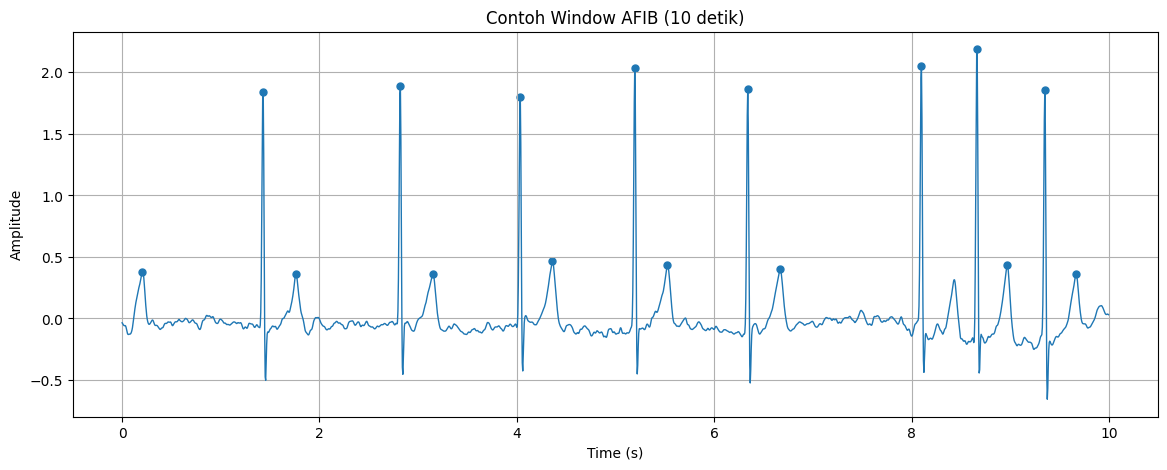

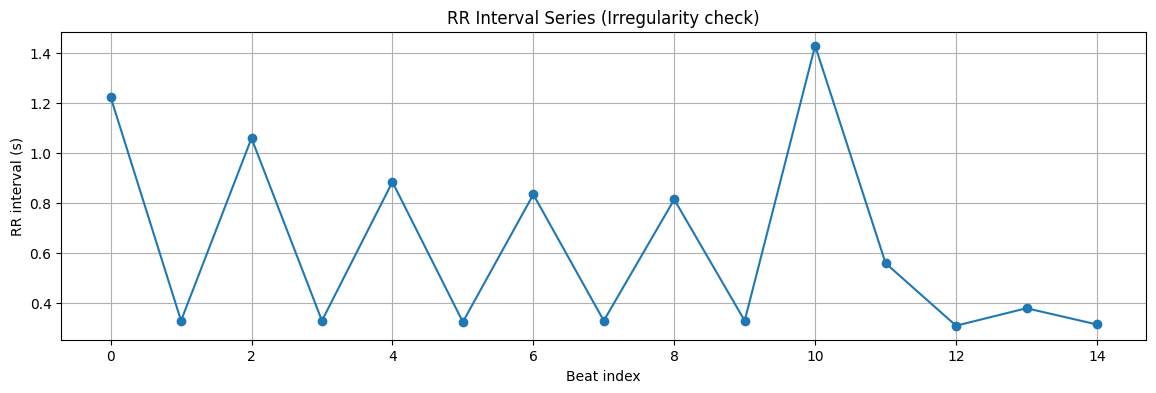

=== RR/HRV Summary ===
Jumlah R-peak: 16
Mean RR (s)  : 0.631
SDNN (s)     : 0.369
RMSSD (s)    : 0.627
Irregularity : 0.585  (lebih tinggi -> lebih tidak teratur)
Mean HR (bpm): 128.1
⚠️ Indikasi RR irregular tinggi -> bisa AFIB (heuristik sederhana).


In [28]:
csv_path = "/content/drive/MyDrive/Tugas Akhir/ECG_CSV_BALANCED/AFIB/AFIB_037142.csv"
plot_ecg_and_rr(csv_path, fs=200, title="Contoh Window AFIB (10 detik)")


# PEMBAGIAN DATA (Train 80%, Test 20% dan Validation dari Train)

Pada tahap ini dilakukan pembagian dataset seimbang hasil undersampling ke dalam data pelatihan (training set) dan data pengujian (testing set). Input pada tahap ini berupa dataset seimbang X_balanced dan y_balanced yang terdiri dari 37.152 segmen sinyal EKG dengan distribusi kelas yang sama untuk AFIB, AFL, dan Normal. Proses pembagian data dilakukan menggunakan metode train-test split dengan proporsi 80% data sebagai data latih dan 20% data sebagai data uji. Pembagian dilakukan secara stratified, sehingga proporsi setiap kelas tetap terjaga baik pada data latih maupun data uji. Selain itu, penggunaan nilai random_state memastikan bahwa proses pembagian data bersifat konsisten dan dapat direproduksi. Output dari tahap ini adalah data latih sebanyak 29.721 segmen dan data uji sebanyak 7.431 segmen, di mana masing-masing kelas memiliki distribusi yang seimbang, yaitu 9.907 data per kelas pada data latih dan 2.477 data per kelas pada data uji. Dataset ini selanjutnya digunakan sebagai input pada tahap pelatihan dan evaluasi model klasifikasi berbasis deep learning.

In [29]:
from sklearn.model_selection import train_test_split
import numpy as np

# =========================
# INPUT (SUDAH 2000)
# =========================
X = np.asarray(X_balanced, dtype=np.float32)   # (N, 2000)
y = np.asarray(y_balanced)                     # (N,)

print("Total Balanced Data:", len(y))
print("X shape:", X.shape, "| y shape:", y.shape)

# safety check
assert X.ndim == 2, "X harus 2D: (N, 2000)"
assert X.shape[0] == y.shape[0], "Jumlah sample X dan y tidak sama"
assert X.shape[1] == 2000, f"Panjang window harus 2000, tapi dapat {X.shape[1]}"

# =========================
# SPLIT 80% TRAINVAL / 20% TEST
# =========================
X_trainval, X_test, y_trainval, y_test = train_test_split(
    X, y,
    test_size=0.20,
    random_state=42,
    stratify=y
)

# =========================
# Dari 80% trainval -> ambil 12.5% untuk val
# Jadi total: 70% train, 10% val, 20% test
# =========================
VAL_FROM_TRAINVAL = 0.125  # 10%/80% = 12.5% -> apabila ingin di ganti jumlah validationya tinggal di ganti menjadi desimal sesuai yang diinginkan penulis

X_train, X_val, y_train, y_val = train_test_split(
    X_trainval, y_trainval,
    test_size=VAL_FROM_TRAINVAL,
    random_state=42,
    stratify=y_trainval
)

# =========================
# OUTPUT SHAPE
# =========================
print("\nSplit Selesai:")
print("Train set:", X_train.shape, y_train.shape)
print("Val set  :", X_val.shape, y_val.shape)
print("Test set :", X_test.shape, y_test.shape)

# =========================
# DISTRIBUSI KELAS
# =========================
label_names = {0: "AFIB", 1: "AFL", 2: "NORMAL"}

def print_dist(name, y_part):
    uniq, cnt = np.unique(y_part, return_counts=True)
    print(f"\nDistribusi {name}:")
    for u, c in zip(uniq, cnt):
        print(f"{label_names[int(u)]} : {int(c)}")

print_dist("Train", y_train)
print_dist("Val", y_val)
print_dist("Test", y_test)

# =========================
# CEK PROPORSI TOTAL
# =========================
n = len(y)
print("\nProporsi (%):")
print("Train:", round(len(y_train)/n*100, 2))
print("Val  :", round(len(y_val)/n*100, 2))
print("Test :", round(len(y_test)/n*100, 2))


Total Balanced Data: 37152
X shape: (37152, 2000) | y shape: (37152,)

Split Selesai:
Train set: (26005, 2000) (26005,)
Val set  : (3716, 2000) (3716,)
Test set : (7431, 2000) (7431,)

Distribusi Train:
AFIB : 8669
AFL : 8668
NORMAL : 8668

Distribusi Val:
AFIB : 1238
AFL : 1239
NORMAL : 1239

Distribusi Test:
AFIB : 2477
AFL : 2477
NORMAL : 2477

Proporsi (%):
Train: 70.0
Val  : 10.0
Test : 20.0


# **Menghitung train, validation dan testing dapat dari dataset AFDB dan SHDB dari pembagian data yang telah di lakukan**

In [30]:
candidates = ["g_all","g_train","g_val","g_test","src_all","src_balanced","src_train","src_val","src_test"]
for v in candidates:
    print(v, "=>", "ADA" if v in globals() else "TIDAK ADA")


g_all => ADA
g_train => TIDAK ADA
g_val => TIDAK ADA
g_test => TIDAK ADA
src_all => TIDAK ADA
src_balanced => TIDAK ADA
src_train => TIDAK ADA
src_val => TIDAK ADA
src_test => TIDAK ADA


In [31]:
import numpy as np
import torch
from sklearn.model_selection import train_test_split

# =========================
# Helper: aman convert tensor -> numpy
# =========================
def to_numpy(a):
    if isinstance(a, torch.Tensor):
        return a.detach().cpu().numpy()
    return np.asarray(a)

# =========================
# 1) Ambil y (prioritas: y_balanced)
# =========================
y = globals().get("y_balanced", globals().get("y", None))
if y is None:
    raise RuntimeError("❌ Variabel y_balanced / y belum ada. Pastikan sudah membuat label dulu.")
y = to_numpy(y).astype(int)

# =========================
# 2) Ambil g_all (WAJIB ada)
# =========================
g_all = globals().get("g_all", None)
if g_all is None:
    raise RuntimeError("❌ Variabel g_all belum ada. Pastikan waktu bikin window kamu simpan g_all (record id / sumber).")
g_all = np.asarray(g_all, dtype=object)

# =========================
# 3) Samakan panjang g dengan y
#    - kalau sudah sama: aman
#    - kalau beda: biasanya karena balancing -> perlu idx balancing
# =========================
g = None
if len(g_all) == len(y):
    g = g_all
    print("✅ g_all sudah SEJALAN dengan y (panjang sama).")
else:
    print(f"⚠️ Panjang beda: len(g_all)={len(g_all)} vs len(y)={len(y)}")
    print("   Ini biasanya karena X/y sudah BALANCED tapi g_all belum ikut diseleksi.")
    print("   Aku coba cari index balancing otomatis...")

    # kandidat nama index yang sering dipakai saat balancing/resampling
    idx_candidates = [
        "balanced_idx", "idx_balanced", "resample_idx", "idx_resample",
        "sel_idx", "selected_idx", "sample_idx", "indices_balanced",
        "keep_idx", "final_idx", "idx_keep"
    ]

    found = None
    for nm in idx_candidates:
        if nm in globals():
            cand = np.asarray(globals()[nm])
            # syarat paling masuk akal:
            # - panjang idx == panjang y_balanced
            # - max idx masih masuk range g_all
            if cand.ndim == 1 and len(cand) == len(y) and int(cand.max()) < len(g_all):
                found = (nm, cand.astype(int))
                break

    if found is None:
        raise RuntimeError(
            "❌ Tidak ketemu index balancing otomatis.\n"
            "Solusi yang BENAR:\n"
            "Saat kamu membuat X_balanced/y_balanced dari X/y, kamu harus ikutkan juga g:\n"
            "   g_balanced = g_all[idx_balanced]\n"
            "Lalu pakai g_balanced untuk hitung AFDB vs SHDB.\n"
            "Coba cek variabel index balancing kamu namanya apa (mis. balanced_idx / idx_balanced)."
        )

    nm, idx_bal = found
    g = g_all[idx_bal]
    print(f"✅ Ketemu index balancing: '{nm}' -> berhasil bikin g yang sejajar dengan y.")

# =========================
# 4) Buat split 70/10/20 (stratify) (pakai y yang balanced)
# =========================
N = len(y)
idx_all = np.arange(N)

trainval_idx, test_idx = train_test_split(
    idx_all, test_size=0.20, random_state=42, stratify=y
)

# val 10% dari total => 10/80 = 12.5% dari trainval
train_idx, val_idx = train_test_split(
    trainval_idx, test_size=0.125, random_state=42, stratify=y[trainval_idx]
)

# ambil per split
g_train, g_val, g_test = g[train_idx], g[val_idx], g[test_idx]
y_train, y_val, y_test = y[train_idx], y[val_idx], y[test_idx]

print("\n=== SPLIT CHECK ===")
print("Train:", len(train_idx), "| Val:", len(val_idx), "| Test:", len(test_idx))
print("Proporsi(%):",
      round(len(train_idx)/N*100,2),
      round(len(val_idx)/N*100,2),
      round(len(test_idx)/N*100,2))

# =========================
# 5) Deteksi sumber AFDB vs SHDB dari g (record id/path)
#    - Kalau g berupa path: pakai substring
#    - Kalau g berupa record id:
#         AFDB biasanya 5 digit (04015, 08455, dst)
#         SHDB biasanya 3 digit (001..043)
# =========================
def detect_source(v):
    s = str(v).lower().strip()

    # kalau path jelas
    if ("mit-bih-atrial-fibrillation" in s) or ("/afdb" in s) or ("afdb" in s):
        return "AFDB"
    if ("shdb" in s) or ("shdb_af" in s) or ("/shdb" in s):
        return "SHDB"

    # kalau record id angka (heuristic)
    digits = "".join([c for c in s if c.isdigit()])
    if len(digits) >= 5:
        return "AFDB"
    if len(digits) == 3:
        return "SHDB"

    return "UNKNOWN"

LABEL_MAP = {0:"AFIB", 1:"AFL", 2:"NORMAL"}

def summarize_sources(name, g_part, y_part):
    src = np.array([detect_source(v) for v in g_part], dtype=object)

    print(f"\n================ {name} ================")
    # total per sumber
    u, c = np.unique(src, return_counts=True)
    for uu, cc in zip(u, c):
        print(f"{uu:7s}: {int(cc)}")

    # per kelas
    for k in [0,1,2]:
        mask = (y_part == k)
        src_k = src[mask]
        u2, c2 = np.unique(src_k, return_counts=True)
        detail = " | ".join([f"{a}={int(b)}" for a,b in zip(u2,c2)]) if len(u2) else "-"
        print(f"  {LABEL_MAP[k]:6s} ({int(mask.sum())}): {detail}")

summarize_sources("TRAIN (70%)", g_train, y_train)
summarize_sources("VAL   (10%)", g_val,   y_val)
summarize_sources("TEST  (20%)", g_test,  y_test)


⚠️ Panjang beda: len(g_all)=454285 vs len(y)=37152
   Ini biasanya karena X/y sudah BALANCED tapi g_all belum ikut diseleksi.
   Aku coba cari index balancing otomatis...
✅ Ketemu index balancing: 'balanced_idx' -> berhasil bikin g yang sejajar dengan y.

=== SPLIT CHECK ===
Train: 26005 | Val: 3716 | Test: 7431
Proporsi(%): 70.0 10.0 20.0

================ TRAIN (70%) ================
AFDB   : 4090
SHDB   : 21915
  AFIB   (8669): AFDB=2282 | SHDB=6387
  AFL    (8668): AFDB=400 | SHDB=8268
  NORMAL (8668): AFDB=1408 | SHDB=7260

================ VAL   (10%) ================
AFDB   : 596
SHDB   : 3120
  AFIB   (1238): AFDB=332 | SHDB=906
  AFL    (1239): AFDB=66 | SHDB=1173
  NORMAL (1239): AFDB=198 | SHDB=1041

================ TEST  (20%) ================
AFDB   : 1124
SHDB   : 6307
  AFIB   (2477): AFDB=593 | SHDB=1884
  AFL    (2477): AFDB=120 | SHDB=2357
  NORMAL (2477): AFDB=411 | SHDB=2066


# **training CNN pakai X_train dan X_test**

Pada tahap ini dilakukan pelatihan dan evaluasi model Convolutional Neural Network (CNN) untuk mengklasifikasikan sinyal EKG ke dalam tiga kelas, yaitu AFIB, AFL, dan Normal. Input pada tahap ini berupa data latih dan data uji hasil pembagian dataset seimbang, di mana setiap sampel sinyal EKG memiliki panjang 2500 titik dan diubah ke dalam bentuk tensor dengan dimensi
(
𝑁
,
1
,
2500
)
(N,1,2500) agar sesuai dengan kebutuhan layer konvolusi satu dimensi. Proses pelatihan diawali dengan pembentukan DataLoader untuk mengatur proses pengambilan data secara batch selama training. Model CNN yang digunakan terdiri dari tiga lapisan Conv1D bertingkat dengan fungsi aktivasi ReLU dan max pooling untuk mengekstraksi fitur morfologi sinyal EKG, diikuti oleh fully connected layer sebagai classifier akhir.

Pelatihan model dilakukan selama 30 epoch menggunakan fungsi loss Cross Entropy dan optimizer Adam dengan laju pembelajaran sebesar 0,0008. Selama proses training, dilakukan evaluasi pada data validasi di setiap epoch untuk menghitung metrik performa yang meliputi accuracy, precision, recall, F1-score, dan specificity. Mekanisme pemilihan model terbaik diterapkan berdasarkan nilai validation F1-score tertinggi untuk menghindari overfitting. Hasil pelatihan divisualisasikan dalam bentuk kurva training dan validation yang telah dihaluskan (smoothed curves), yang menunjukkan bahwa model mampu belajar dengan baik, ditandai oleh peningkatan akurasi dan F1-score serta penurunan training loss, meskipun validation loss cenderung meningkat pada epoch tertentu yang mengindikasikan potensi overfitting.

Output dari tahap ini adalah model CNN terlatih dengan performa terbaik yang mencapai akurasi sekitar 91% pada data uji. Berdasarkan confusion matrix, model menunjukkan kemampuan klasifikasi yang baik pada ketiga kelas, dengan tingkat deteksi tertinggi pada kelas AFL, diikuti oleh AFIB dan Normal. Hasil classification report menunjukkan nilai precision, recall, dan F1-score yang relatif seimbang pada seluruh kelas, yang menegaskan bahwa model CNN mampu mengklasifikasikan sinyal EKG secara konsisten dan efektif. Seluruh hasil pelatihan dan evaluasi juga disimpan dalam bentuk file CSV sebagai dokumentasi proses training.

In [32]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader

from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import precision_score, recall_score, f1_score

In [33]:
SEED = 42
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

LABEL_NAMES = ["AFIB", "AFL", "NORMAL"]
NUM_CLASSES = 3

Device: cpu


In [34]:
X_train = np.asarray(X_train, dtype=np.float32)
X_val   = np.asarray(X_val,   dtype=np.float32)
X_test  = np.asarray(X_test,  dtype=np.float32)

y_train = np.asarray(y_train, dtype=np.int64)
y_val   = np.asarray(y_val,   dtype=np.int64)
y_test  = np.asarray(y_test,  dtype=np.int64)

assert X_train.ndim == 2 and X_train.shape[1] == 2000, "X_train harus (N, 2000)"
assert X_val.ndim   == 2 and X_val.shape[1]   == 2000, "X_val harus (N, 2000)"
assert X_test.ndim  == 2 and X_test.shape[1]  == 2000, "X_test harus (N, 2000)"
assert len(X_train) == len(y_train), "X_train dan y_train beda jumlah"
assert len(X_val)   == len(y_val),   "X_val dan y_val beda jumlah"
assert len(X_test)  == len(y_test),  "X_test dan y_test beda jumlah"

print("Shapes:",
      "Train:", X_train.shape, y_train.shape,
      "| Val:", X_val.shape, y_val.shape,
      "| Test:", X_test.shape, y_test.shape)

Shapes: Train: (26005, 2000) (26005,) | Val: (3716, 2000) (3716,) | Test: (7431, 2000) (7431,)


In [35]:
X_train_t = torch.tensor(X_train).unsqueeze(1)   # (N, 1, 2000)
X_val_t   = torch.tensor(X_val).unsqueeze(1)
X_test_t  = torch.tensor(X_test).unsqueeze(1)

y_train_t = torch.tensor(y_train, dtype=torch.long)
y_val_t   = torch.tensor(y_val,   dtype=torch.long)
y_test_t  = torch.tensor(y_test,  dtype=torch.long)

In [36]:
BATCH_SIZE = 64

train_loader = DataLoader(
    TensorDataset(X_train_t, y_train_t),
    batch_size=BATCH_SIZE,
    shuffle=True
)
val_loader = DataLoader(
    TensorDataset(X_val_t, y_val_t),
    batch_size=BATCH_SIZE,
    shuffle=False
)
test_loader = DataLoader(
    TensorDataset(X_test_t, y_test_t),
    batch_size=BATCH_SIZE,
    shuffle=False
)

In [37]:
# -------------------------
# 5) Model CNN 1D
# -------------------------
class ECG_CNN(nn.Module):
    def __init__(self, num_classes=3):
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv1d(1, 32, kernel_size=7, padding=3),
            nn.ReLU(),
            nn.MaxPool1d(2),

            nn.Conv1d(32, 64, kernel_size=5, padding=2),
            nn.ReLU(),
            nn.MaxPool1d(2),

            nn.Conv1d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool1d(2),
        )

        # input length 2000 -> pool /2 /2 /2 => 2000/8 = 250
        # channels 128 -> flatten = 128 * 250 = 32000
        self.classifier = nn.Sequential(
            nn.Linear(128 * 250, 256),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, num_classes)
        )

    def forward(self, x):
        x = self.features(x)          # (N, 128, 250)
        x = x.view(x.size(0), -1)     # (N, 32000)
        x = self.classifier(x)        # (N, 3)
        return x

model = ECG_CNN(num_classes=NUM_CLASSES).to(device)
print(model)

ECG_CNN(
  (features): Sequential(
    (0): Conv1d(1, 32, kernel_size=(7,), stride=(1,), padding=(3,))
    (1): ReLU()
    (2): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv1d(32, 64, kernel_size=(5,), stride=(1,), padding=(2,))
    (4): ReLU()
    (5): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv1d(64, 128, kernel_size=(3,), stride=(1,), padding=(1,))
    (7): ReLU()
    (8): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Linear(in_features=32000, out_features=256, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.3, inplace=False)
    (3): Linear(in_features=256, out_features=3, bias=True)
  )
)


In [38]:
# -------------------------
# 6) Metrics helper
# -------------------------
def multi_specificity(cm, eps=1e-8):
    # macro specificity: TN/(TN+FP) per class
    tp = np.diag(cm)
    fp = cm.sum(axis=0) - tp
    fn = cm.sum(axis=1) - tp
    tn = cm.sum() - (tp + fp + fn)
    spec = tn / (tn + fp + eps)
    return float(np.mean(spec))

@torch.no_grad()
def evaluate(model, loader, criterion):
    model.eval()
    all_preds = []
    all_labels = []
    losses = []

    for xb, yb in loader:
        xb = xb.to(device)
        yb = yb.to(device)

        logits = model(xb)
        loss = criterion(logits, yb)
        losses.append(loss.item())

        preds = torch.argmax(logits, dim=1)
        all_preds.append(preds.cpu().numpy())
        all_labels.append(yb.cpu().numpy())

    all_preds = np.concatenate(all_preds)
    all_labels = np.concatenate(all_labels)

    cm = confusion_matrix(all_labels, all_preds, labels=[0, 1, 2])
    acc = (np.diag(cm).sum() / cm.sum()) if cm.sum() > 0 else 0.0
    prec = precision_score(all_labels, all_preds, average="macro", zero_division=0)
    rec = recall_score(all_labels, all_preds, average="macro", zero_division=0)
    f1 = f1_score(all_labels, all_preds, average="macro", zero_division=0)
    spec = multi_specificity(cm)

    return float(np.mean(losses)), float(acc), float(prec), float(rec), float(f1), float(spec), cm, all_labels, all_preds


In [39]:
# -------------------------
# 7) Training setup (NO EARLY STOP)
# -------------------------
EPOCHS = 30
LR = 8e-4

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=LR)

history = {
    "train_loss": [],
    "val_loss": [],
    "train_acc": [],
    "val_acc": [],
    "val_prec": [],
    "val_rec": [],
    "val_f1": [],
    "val_spec": []
}

In [ ]:
# -------------------------
# 8) Training loop
# -------------------------
for epoch in range(1, EPOCHS + 1):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for xb, yb in train_loader:
        xb = xb.to(device)
        yb = yb.to(device)

        optimizer.zero_grad(set_to_none=True)
        logits = model(xb)
        loss = criterion(logits, yb)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * xb.size(0)
        preds = torch.argmax(logits, dim=1)
        correct += (preds == yb).sum().item()
        total += yb.size(0)

    train_loss = running_loss / total
    train_acc = correct / total

    # validate
    val_loss, val_acc, val_prec, val_rec, val_f1, val_spec, _, _, _ = evaluate(
        model, val_loader, criterion
    )

    history["train_loss"].append(train_loss)
    history["val_loss"].append(val_loss)
    history["train_acc"].append(train_acc)
    history["val_acc"].append(val_acc)
    history["val_prec"].append(val_prec)
    history["val_rec"].append(val_rec)
    history["val_f1"].append(val_f1)
    history["val_spec"].append(val_spec)

    print(f"\nEpoch {epoch}/{EPOCHS}")
    print(f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f}")
    print(f"Val   Loss: {val_loss:.4f} | Val   Acc: {val_acc:.4f}")
    print(f"Val Precision: {val_prec:.4f} | Val Recall: {val_rec:.4f}")
    print(f"Val F1: {val_f1:.4f} | Val Specificity: {val_spec:.4f}")



Epoch 1/30
Train Loss: 0.6960 | Train Acc: 0.6704
Val   Loss: 0.4946 | Val   Acc: 0.7793
Val Precision: 0.7745 | Val Recall: 0.7793
Val F1: 0.7757 | Val Specificity: 0.8897

Epoch 2/30
Train Loss: 0.4399 | Train Acc: 0.8095
Val   Loss: 0.3821 | Val   Acc: 0.8353
Val Precision: 0.8435 | Val Recall: 0.8353
Val F1: 0.8328 | Val Specificity: 0.9177

Epoch 3/30
Train Loss: 0.3185 | Train Acc: 0.8737
Val   Loss: 0.3231 | Val   Acc: 0.8638
Val Precision: 0.8682 | Val Recall: 0.8638
Val F1: 0.8627 | Val Specificity: 0.9319

Epoch 4/30
Train Loss: 0.2367 | Train Acc: 0.9094
Val   Loss: 0.3214 | Val   Acc: 0.8738
Val Precision: 0.8747 | Val Recall: 0.8738
Val F1: 0.8736 | Val Specificity: 0.9369

Epoch 5/30
Train Loss: 0.1769 | Train Acc: 0.9327
Val   Loss: 0.2940 | Val   Acc: 0.8969
Val Precision: 0.8965 | Val Recall: 0.8969
Val F1: 0.8965 | Val Specificity: 0.9485

Epoch 6/30
Train Loss: 0.1210 | Train Acc: 0.9560
Val   Loss: 0.3508 | Val   Acc: 0.8862
Val Precision: 0.8859 | Val Recall: 0.88

In [ ]:
# -------------------------
# 9) FINAL TEST EVALUATION
# -------------------------
test_loss, test_acc, test_prec, test_rec, test_f1, test_spec, cm_test, y_true, y_pred = evaluate(
    model, test_loader, criterion
)

print("\n====================")
print("FINAL TEST RESULT (CNN)")
print("====================")
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Acc : {test_acc:.4f}")
print(f"Precision: {test_prec:.4f}")
print(f"Recall   : {test_rec:.4f}")
print(f"F1-Scor e : {test_f1:.4f}")
print(f"Spec     : {test_spec:.4f}")

print("\nConfusion Matrix (Test):")
print(cm_test)

print("\nClassification Report (Test):")
print(classification_report(y_true, y_pred, target_names=LABEL_NAMES, digits=4))


FINAL TEST RESULT (CNN)
Test Loss: 0.8898
Test Acc : 0.8914
Precision: 0.8906
Recall   : 0.8914
F1-Scor e : 0.8905
Spec     : 0.9457

Confusion Matrix (Test):
[[2029  135  313]
 [  48 2410   19]
 [ 243   49 2185]]

Classification Report (Test):
              precision    recall  f1-score   support

        AFIB     0.8746    0.8191    0.8459      2477
         AFL     0.9291    0.9730    0.9505      2477
      NORMAL     0.8681    0.8821    0.8751      2477

    accuracy                         0.8914      7431
   macro avg     0.8906    0.8914    0.8905      7431
weighted avg     0.8906    0.8914    0.8905      7431



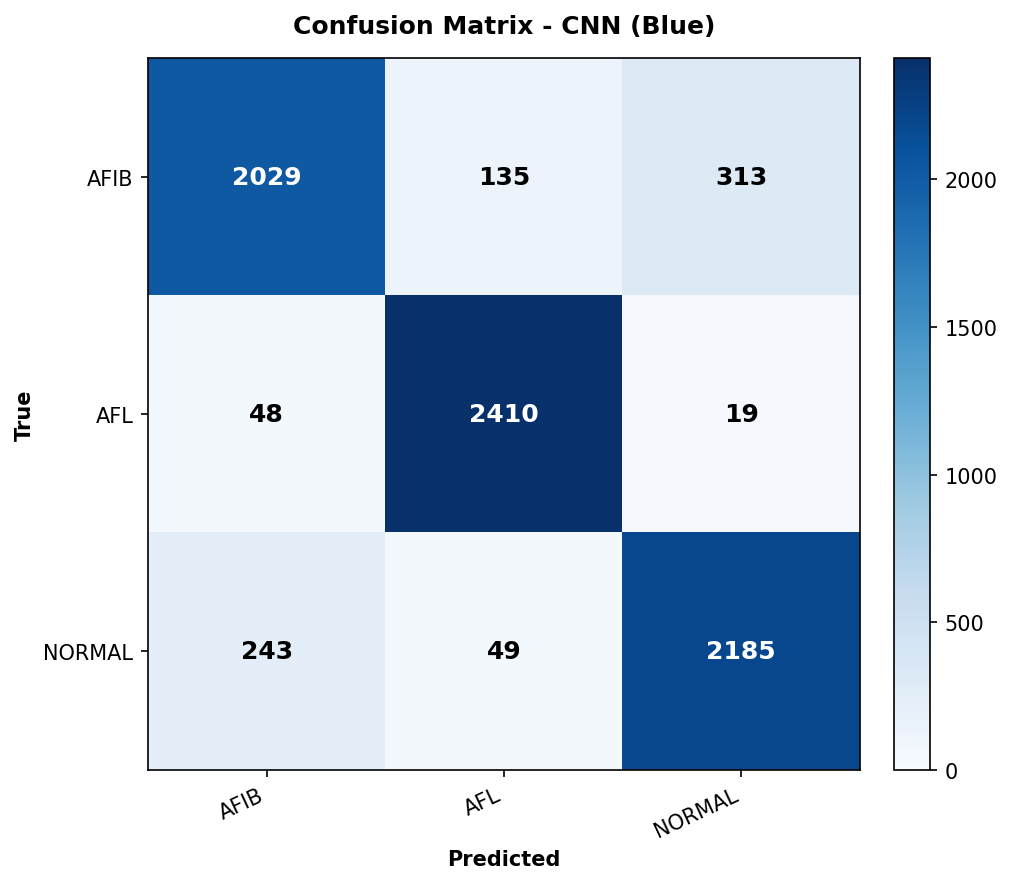

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def plot_confusion_matrix_blue(cm, labels, title="Confusion Matrix", rotate_xticks=25):
    cm = np.asarray(cm)

    plt.figure(figsize=(7, 6), dpi=150)
    im = plt.imshow(cm, interpolation="nearest", cmap=plt.cm.Blues, vmin=0)
    plt.title(title, fontweight="bold", pad=12)
    plt.colorbar(im, fraction=0.046, pad=0.04)

    tick_marks = np.arange(len(labels))
    plt.xticks(tick_marks, labels, rotation=rotate_xticks, ha="right")
    plt.yticks(tick_marks, labels)

    thresh = cm.max() * 0.6 if cm.max() > 0 else 0
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            plt.text(
                j, i, f"{cm[i, j]}",
                ha="center", va="center",
                color="white" if cm[i, j] > thresh else "black",
                fontsize=12, fontweight="bold"
            )

    plt.ylabel("True", fontweight="bold")
    plt.xlabel("Predicted", fontweight="bold")
    plt.tight_layout()
    plt.show()

# pakai
plot_confusion_matrix_blue(cm_test, LABEL_NAMES, title="Confusion Matrix - CNN (Blue)")


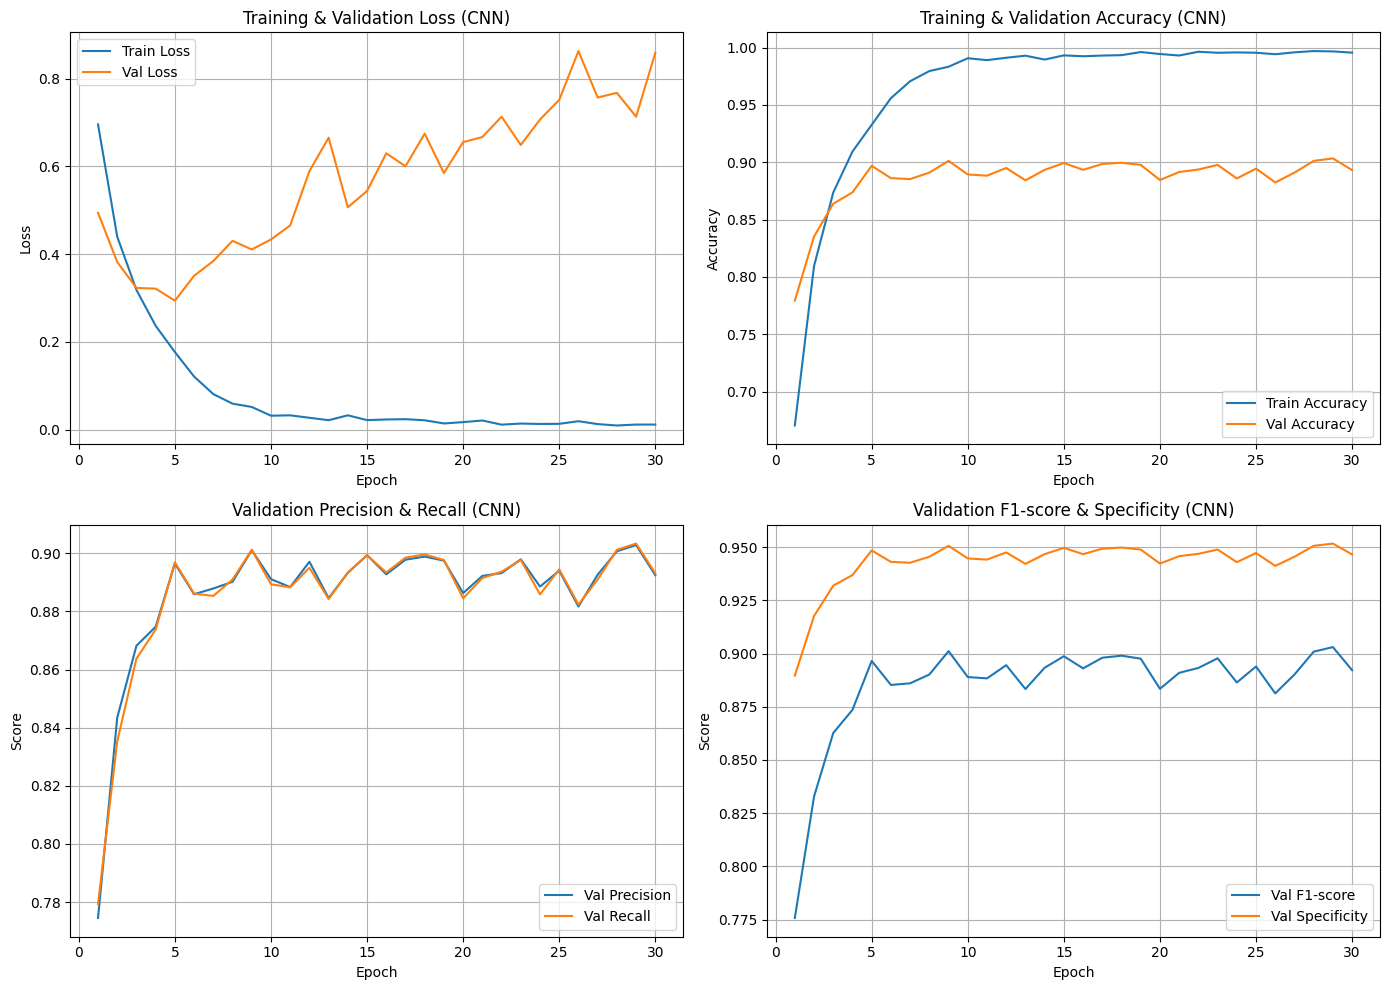

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# wajib: history sudah terisi dari training loop kamu
# history keys minimal:
# train_loss, val_loss, train_acc, val_acc, val_prec, val_rec, val_f1, val_spec

def moving_average(x, w=1):
    x = np.asarray(x, dtype=float)
    if w is None or w <= 1:
        return x
    w = int(w)
    if len(x) < w:
        return x
    return np.convolve(x, np.ones(w)/w, mode="valid")

# -------------------------
# setting smoothing (opsional)
# -------------------------
SMOOTH_W = 1  # misal 3 kalau mau halus

epochs = np.arange(1, len(history["train_loss"]) + 1)

# ambil data
tr_loss = np.array(history["train_loss"], dtype=float)
va_loss = np.array(history["val_loss"], dtype=float)
tr_acc  = np.array(history["train_acc"], dtype=float)
va_acc  = np.array(history["val_acc"], dtype=float)

va_prec = np.array(history["val_prec"], dtype=float)
va_rec  = np.array(history["val_rec"], dtype=float)
va_f1   = np.array(history["val_f1"], dtype=float)
va_spec = np.array(history["val_spec"], dtype=float)

# smoothing (kalau SMOOTH_W > 1, panjang jadi berkurang)
def smooth_xy(y):
    ys = moving_average(y, SMOOTH_W)
    xs = epochs if len(ys) == len(epochs) else epochs[-len(ys):]
    return xs, ys

# -------------------------
# FIGURE
# -------------------------
plt.figure(figsize=(14, 10))

# 1) Loss
plt.subplot(2, 2, 1)
x1, y1 = smooth_xy(tr_loss)
x2, y2 = smooth_xy(va_loss)
plt.plot(x1, y1, label="Train Loss")
plt.plot(x2, y2, label="Val Loss")
plt.title("Training & Validation Loss (CNN)")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(True)
plt.legend()

# 2) Accuracy
plt.subplot(2, 2, 2)
x1, y1 = smooth_xy(tr_acc)
x2, y2 = smooth_xy(va_acc)
plt.plot(x1, y1, label="Train Accuracy")
plt.plot(x2, y2, label="Val Accuracy")
plt.title("Training & Validation Accuracy (CNN)")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.grid(True)
plt.legend()

# 3) Validation Precision & Recall
plt.subplot(2, 2, 3)
x1, y1 = smooth_xy(va_prec)
x2, y2 = smooth_xy(va_rec)
plt.plot(x1, y1, label="Val Precision")
plt.plot(x2, y2, label="Val Recall")
plt.title("Validation Precision & Recall (CNN)")
plt.xlabel("Epoch")
plt.ylabel("Score")
plt.grid(True)
plt.legend()

# 4) Validation F1 & Specificity
plt.subplot(2, 2, 4)
x1, y1 = smooth_xy(va_f1)
x2, y2 = smooth_xy(va_spec)
plt.plot(x1, y1, label="Val F1-score")
plt.plot(x2, y2, label="Val Specificity")
plt.title("Validation F1-score & Specificity (CNN)")
plt.xlabel("Epoch")
plt.ylabel("Score")
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()


In [ ]:
history = {
  "train_loss": [], "val_loss": [],
  "train_acc": [], "val_acc": [],
  "train_prec": [], "val_prec": [],
  "train_rec": [], "val_rec": [],
  "train_f1": [], "val_f1": [],
  "train_spec": [], "val_spec": [],
}


In [ ]:
tr_loss2, tr_acc2, tr_prec2, tr_rec2, tr_f12, tr_spec2, *_ = evaluate(model, train_loader, criterion)
# simpan train metric dari evaluate (opsional) atau tetap pakai train_loss/train_acc manual kamu
history["train_prec"].append(tr_prec2)
history["train_rec"].append(tr_rec2)
history["train_f1"].append(tr_f12)
history["train_spec"].append(tr_spec2)


# **MODEL LSTM**

Pada tahap ini dilakukan pelatihan dan evaluasi model Long Short-Term Memory (LSTM) untuk mengklasifikasikan sinyal EKG ke dalam tiga kelas, yaitu AFIB, AFL, dan Normal. Input pada tahap ini berupa dataset seimbang hasil preprocessing yang telah dibagi menjadi data latih dan data uji. Setiap segmen sinyal EKG yang memiliki panjang 2500 sampel diubah ke dalam format sekuens (2500,1)
(2500,1) agar sesuai dengan karakteristik model LSTM yang memproses data berbasis urutan waktu. Dataset kemudian dimuat menggunakan DataLoader untuk mempermudah proses pelatihan secara batch. Arsitektur LSTM yang digunakan terdiri dari dua lapisan LSTM bertipe bidirectional dengan jumlah unit tersembunyi sebesar 128, diikuti oleh fully connected layer sebagai classifier untuk menghasilkan prediksi tiga kelas.

Proses pelatihan dilakukan selama 30 epoch menggunakan fungsi loss Cross Entropy dan optimizer Adam. Pada setiap epoch, dilakukan evaluasi performa model pada data validasi dengan menghitung metrik accuracy, precision, recall (sensitivity), F1-score, dan specificity. Hasil pelatihan menunjukkan bahwa model LSTM mengalami kesulitan dalam mempelajari pola sinyal EKG secara optimal, yang ditandai dengan nilai akurasi validasi yang relatif rendah dan cenderung stagnan di sekitar 40%. Kurva training dan validation loss juga menunjukkan fluktuasi yang kecil tanpa penurunan signifikan, mengindikasikan bahwa model belum mampu mengekstraksi fitur diskriminatif yang kuat dari sinyal EKG mentah.

Output dari tahap ini berupa model LSTM terlatih beserta hasil evaluasinya. Berdasarkan confusion matrix dan classification report, model LSTM menunjukkan kecenderungan bias terhadap kelas AFL, sementara performa klasifikasi untuk kelas AFIB dan Normal relatif rendah. Nilai macro F1-score yang rendah mengindikasikan bahwa model LSTM kurang efektif dalam menangani permasalahan klasifikasi multi-kelas pada sinyal EKG dibandingkan dengan model CNN. Seluruh riwayat pelatihan dan evaluasi model LSTM disimpan dalam bentuk file CSV sebagai dokumentasi dan bahan analisis lebih lanjut.

In [40]:
# 1. IMPORT LIBRARY
import os, time, random
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

from sklearn.metrics import (
    confusion_matrix,
    classification_report,
    precision_score,
    recall_score,
    f1_score
)
import matplotlib.pyplot as plt


In [41]:
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

set_seed(42)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

LABEL_NAMES = ["AFIB", "AFL", "NORMAL"]
NUM_CLASSES = 3
SEQ_LEN = 2000

Device: cpu


In [42]:
# -------------------------
# 1) Safety checks
# -------------------------
def sanity_check(X, y, name):
    X = np.asarray(X)
    y = np.asarray(y)
    assert X.ndim == 2, f"{name}: X harus 2D (N,2000)"
    assert X.shape[1] == SEQ_LEN, f"{name}: panjang window harus {SEQ_LEN}, tapi dapat {X.shape[1]}"
    assert X.shape[0] == y.shape[0], f"{name}: jumlah sample X dan y tidak sama"
    assert set(np.unique(y)).issubset({0,1,2}), f"{name}: label harus 0/1/2"
    return X.astype(np.float32), y.astype(np.int64)

X_train, y_train = sanity_check(X_train, y_train, "TRAIN")
X_val,   y_val   = sanity_check(X_val,   y_val,   "VAL")
X_test,  y_test  = sanity_check(X_test,  y_test,  "TEST")

print("Shapes:",
      "\n Train:", X_train.shape, y_train.shape,
      "\n Val  :", X_val.shape, y_val.shape,
      "\n Test :", X_test.shape, y_test.shape)

Shapes: 
 Train: (26005, 2000) (26005,) 
 Val  : (3716, 2000) (3716,) 
 Test : (7431, 2000) (7431,)


In [43]:
# -------------------------
# 2) Dataset + DataLoader
# -------------------------
class ECGSeqDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.from_numpy(X)  # (N, 2000)
        self.y = torch.from_numpy(y)  # (N,)
    def __len__(self):
        return len(self.y)
    def __getitem__(self, idx):
        x = self.X[idx].unsqueeze(-1)  # (2000,) -> (2000, 1) for LSTM
        y = self.y[idx]
        return x, y

BATCH_SIZE = 128

train_loader = DataLoader(ECGSeqDataset(X_train, y_train), batch_size=BATCH_SIZE, shuffle=True,  drop_last=False)
val_loader   = DataLoader(ECGSeqDataset(X_val,   y_val),   batch_size=BATCH_SIZE, shuffle=False, drop_last=False)
test_loader  = DataLoader(ECGSeqDataset(X_test,  y_test),  batch_size=BATCH_SIZE, shuffle=False, drop_last=False)


In [44]:
# -------------------------
# 3) Model LSTM
# -------------------------
class LSTM_ECG(nn.Module):
    def __init__(self, input_dim=1, hidden_dim=128, num_layers=2, num_classes=3, dropout=0.3, bidirectional=True):
        super().__init__()
        self.bidirectional = bidirectional
        self.lstm = nn.LSTM(
            input_size=input_dim,
            hidden_size=hidden_dim,
            num_layers=num_layers,
            batch_first=True,      # (B, T, C)
            dropout=dropout if num_layers > 1 else 0.0,
            bidirectional=bidirectional
        )
        out_dim = hidden_dim * (2 if bidirectional else 1)
        self.classifier = nn.Sequential(
            nn.Linear(out_dim, 256),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(256, num_classes)
        )

    def forward(self, x):
        # x: (B, 2000, 1)
        out, _ = self.lstm(x)          # out: (B, 2000, H*dir)
        last = out[:, -1, :]           # ambil timestep terakhir
        logits = self.classifier(last) # (B, num_classes)
        return logits

model = LSTM_ECG(
    input_dim=1,
    hidden_dim=128,
    num_layers=2,
    num_classes=NUM_CLASSES,
    dropout=0.3,
    bidirectional=True
).to(device)

print(model)

LSTM_ECG(
  (lstm): LSTM(1, 128, num_layers=2, batch_first=True, dropout=0.3, bidirectional=True)
  (classifier): Sequential(
    (0): Linear(in_features=256, out_features=256, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.3, inplace=False)
    (3): Linear(in_features=256, out_features=3, bias=True)
  )
)


In [45]:
# -------------------------
# 4) Metrics helper
# -------------------------
def multiclass_specificity(cm: np.ndarray, eps=1e-8) -> float:
    # specificity per class = TN / (TN + FP), lalu rata-rata
    tp = np.diag(cm)
    fp = cm.sum(axis=0) - tp
    fn = cm.sum(axis=1) - tp
    tn = cm.sum() - (tp + fp + fn)
    spec = tn / (tn + fp + eps)
    return float(np.mean(spec))

@torch.no_grad()
def evaluate(model, loader, criterion=None):
    model.eval()
    all_preds = []
    all_true  = []
    losses = []

    for x, y in loader:
        x = x.to(device)               # (B,2000,1)
        y = y.to(device)               # (B,)
        logits = model(x)
        if criterion is not None:
            loss = criterion(logits, y)
            losses.append(loss.item())
        preds = torch.argmax(logits, dim=1)

        all_preds.append(preds.cpu().numpy())
        all_true.append(y.cpu().numpy())

    y_true = np.concatenate(all_true)
    y_pred = np.concatenate(all_preds)

    cm = confusion_matrix(y_true, y_pred, labels=[0,1,2])
    acc = float((np.diag(cm).sum() / cm.sum()) if cm.sum() > 0 else 0.0)
    prec = float(precision_score(y_true, y_pred, average="macro", zero_division=0))
    rec  = float(recall_score(y_true, y_pred, average="macro", zero_division=0))
    f1   = float(f1_score(y_true, y_pred, average="macro", zero_division=0))
    spec = multiclass_specificity(cm)

    avg_loss = float(np.mean(losses)) if len(losses) > 0 else None
    return avg_loss, acc, prec, rec, f1, spec, cm, y_true, y_pred

In [46]:
# -------------------------
# 5) Training setup
# -------------------------
EPOCHS = 30
LR = 1e-3

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=LR)

history = {
    "train_loss": [], "val_loss": [],
    "train_acc": [],  "val_acc": [],
    "train_prec": [], "val_prec": [],
    "train_rec": [],  "val_rec": [],
    "train_f1": [],   "val_f1": [],
    "train_spec": [], "val_spec": []
}

In [ ]:
# -------------------------
# 6) Training loop (TANPA EARLY STOPPING)
# -------------------------
for epoch in range(1, EPOCHS + 1):
    t0 = time.time()
    model.train()

    running_loss = 0.0
    for x, y in train_loader:
        x = x.to(device)  # (B,2000,1)
        y = y.to(device)  # (B,)

        optimizer.zero_grad(set_to_none=True)
        logits = model(x)
        loss = criterion(logits, y)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    train_loss_epoch = running_loss / max(1, len(train_loader))

    # Hitung metrik train & val
    tr_loss, tr_acc, tr_prec, tr_rec, tr_f1, tr_spec, _, _, _ = evaluate(model, train_loader, criterion=criterion)
    va_loss, va_acc, va_prec, va_rec, va_f1, va_spec, _, _, _ = evaluate(model, val_loader, criterion=criterion)

    # Simpan history
    history["train_loss"].append(tr_loss if tr_loss is not None else train_loss_epoch)
    history["val_loss"].append(va_loss)
    history["train_acc"].append(tr_acc);   history["val_acc"].append(va_acc)
    history["train_prec"].append(tr_prec); history["val_prec"].append(va_prec)
    history["train_rec"].append(tr_rec);   history["val_rec"].append(va_rec)
    history["train_f1"].append(tr_f1);     history["val_f1"].append(va_f1)
    history["train_spec"].append(tr_spec); history["val_spec"].append(va_spec)

    dt = time.time() - t0
    print(f"\nEpoch {epoch}/{EPOCHS} | time {dt:.1f}s")
    print(f"Train: loss {history['train_loss'][-1]:.4f} | acc {tr_acc:.4f} | prec {tr_prec:.4f} | rec {tr_rec:.4f} | f1 {tr_f1:.4f} | spec {tr_spec:.4f}")
    print(f"Val  : loss {va_loss:.4f} | acc {va_acc:.4f} | prec {va_prec:.4f} | rec {va_rec:.4f} | f1 {va_f1:.4f} | spec {va_spec:.4f}")

print("\n✅ Training selesai (tanpa early stopping).")


Epoch 1/30 | time 1879.4s
Train: loss 1.0943 | acc 0.3602 | prec 0.2454 | rec 0.3602 | f1 0.2529 | spec 0.6801
Val  : loss 1.0925 | acc 0.3558 | prec 0.2357 | rec 0.3557 | f1 0.2489 | spec 0.6778

Epoch 2/30 | time 1875.0s
Train: loss 1.0911 | acc 0.3623 | prec 0.4151 | rec 0.3623 | f1 0.2286 | spec 0.6811
Val  : loss 1.0841 | acc 0.3622 | prec 0.4175 | rec 0.3621 | f1 0.2288 | spec 0.6811

Epoch 3/30 | time 1885.9s
Train: loss 1.0730 | acc 0.3789 | prec 0.4377 | rec 0.3789 | f1 0.2607 | spec 0.6895
Val  : loss 1.0743 | acc 0.3794 | prec 0.4649 | rec 0.3793 | f1 0.2629 | spec 0.6897

Epoch 4/30 | time 1791.4s
Train: loss 1.0977 | acc 0.3377 | prec 0.4709 | rec 0.3377 | f1 0.1827 | spec 0.6688
Val  : loss 1.0976 | acc 0.3393 | prec 0.5582 | rec 0.3393 | f1 0.1834 | spec 0.6696

Epoch 5/30 | time 1792.1s
Train: loss 1.0982 | acc 0.3387 | prec 0.2473 | rec 0.3387 | f1 0.1958 | spec 0.6694
Val  : loss 1.0972 | acc 0.3434 | prec 0.2709 | rec 0.3436 | f1 0.1991 | spec 0.6718

Epoch 6/30 | t


=== TEST RESULT (LSTM) ===
Loss       : 0.9970
Accuracy   : 0.4789
Precision  : 0.4567
Recall     : 0.4789
F1-score   : 0.4549
Specificity: 0.7395

Classification Report:
              precision    recall  f1-score   support

        AFIB     0.4756    0.6023    0.5315      2477
         AFL     0.5345    0.6443    0.5843      2477
      NORMAL     0.3601    0.1901    0.2489      2477

    accuracy                         0.4789      7431
   macro avg     0.4567    0.4789    0.4549      7431
weighted avg     0.4567    0.4789    0.4549      7431

Confusion Matrix:
 [[1492  649  336]
 [ 380 1596  501]
 [1265  741  471]]


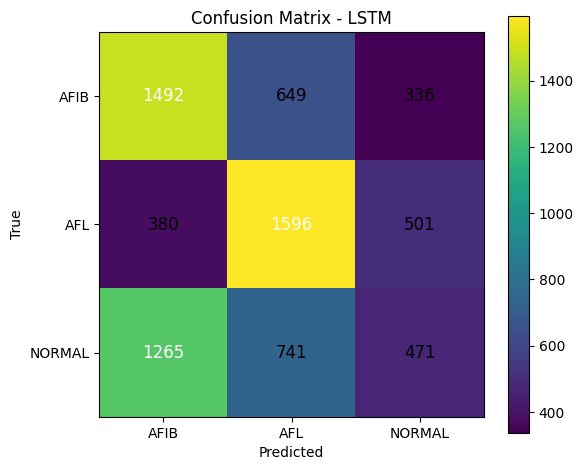

In [ ]:
# -------------------------
# 7) Evaluasi TEST
# -------------------------
test_loss, test_acc, test_prec, test_rec, test_f1, test_spec, cm_test, y_true, y_pred = evaluate(
    model, test_loader, criterion=criterion
)

print("\n=== TEST RESULT (LSTM) ===")
print(f"Loss       : {test_loss:.4f}")
print(f"Accuracy   : {test_acc:.4f}")
print(f"Precision  : {test_prec:.4f}")
print(f"Recall     : {test_rec:.4f}")
print(f"F1-score   : {test_f1:.4f}")
print(f"Specificity: {test_spec:.4f}")

print(classification_report(y_true, y_pred, target_names=LABEL_NAMES, digits=4))

print("Confusion Matrix:\n", cm_test)

# Plot confusion matrix (matplotlib)
plt.figure(figsize=(6,5))
plt.imshow(cm_test)
plt.title("Confusion Matrix - LSTM")
plt.xticks([0,1,2], LABEL_NAMES, rotation=0)
plt.yticks([0,1,2], LABEL_NAMES)
plt.xlabel("Predicted")
plt.ylabel("True")

# angka di kotak
th = cm_test.max() * 0.6
for i in range(3):
    for j in range(3):
        plt.text(j, i, str(cm_test[i, j]),
                 ha="center", va="center",
                 color="white" if cm_test[i, j] > th else "black",
                 fontsize=12)
plt.colorbar()
plt.tight_layout()
plt.show()

In [47]:
import numpy as np
import matplotlib.pyplot as plt

def plot_confusion_matrix_blue(cm, labels, title="Confusion Matrix - LSTM", rotate_xticks=0):
    cm = np.asarray(cm)

    plt.figure(figsize=(7, 6), dpi=150)
    im = plt.imshow(cm, interpolation="nearest", cmap=plt.cm.Blues, vmin=0)
    plt.title(title, fontweight="bold", pad=12)
    plt.colorbar(im, fraction=0.046, pad=0.04)

    tick_marks = np.arange(len(labels))
    plt.xticks(tick_marks, labels, rotation=rotate_xticks)
    plt.yticks(tick_marks, labels)

    thresh = cm.max() * 0.6 if cm.max() > 0 else 0
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            plt.text(
                j, i, f"{cm[i, j]}",
                ha="center", va="center",
                color="white" if cm[i, j] > thresh else "black",
                fontsize=12, fontweight="bold"
            )

    plt.ylabel("True", fontweight="bold")
    plt.xlabel("Predicted", fontweight="bold")
    plt.tight_layout()
    plt.show()

# pakai untuk LSTM:
plot_confusion_matrix_blue(cm_test, LABEL_NAMES, title="Confusion Matrix - LSTM (Blue)")


NameError: name 'cm_test' is not defined

In [ ]:
import numpy as np

print("Unique y_true:", np.unique(y_true, return_counts=True))
print("Unique y_pred:", np.unique(y_pred, return_counts=True))


Unique y_true: (array([0, 1, 2]), array([2477, 2477, 2477]))
Unique y_pred: (array([0, 1, 2]), array([3137, 2986, 1308]))


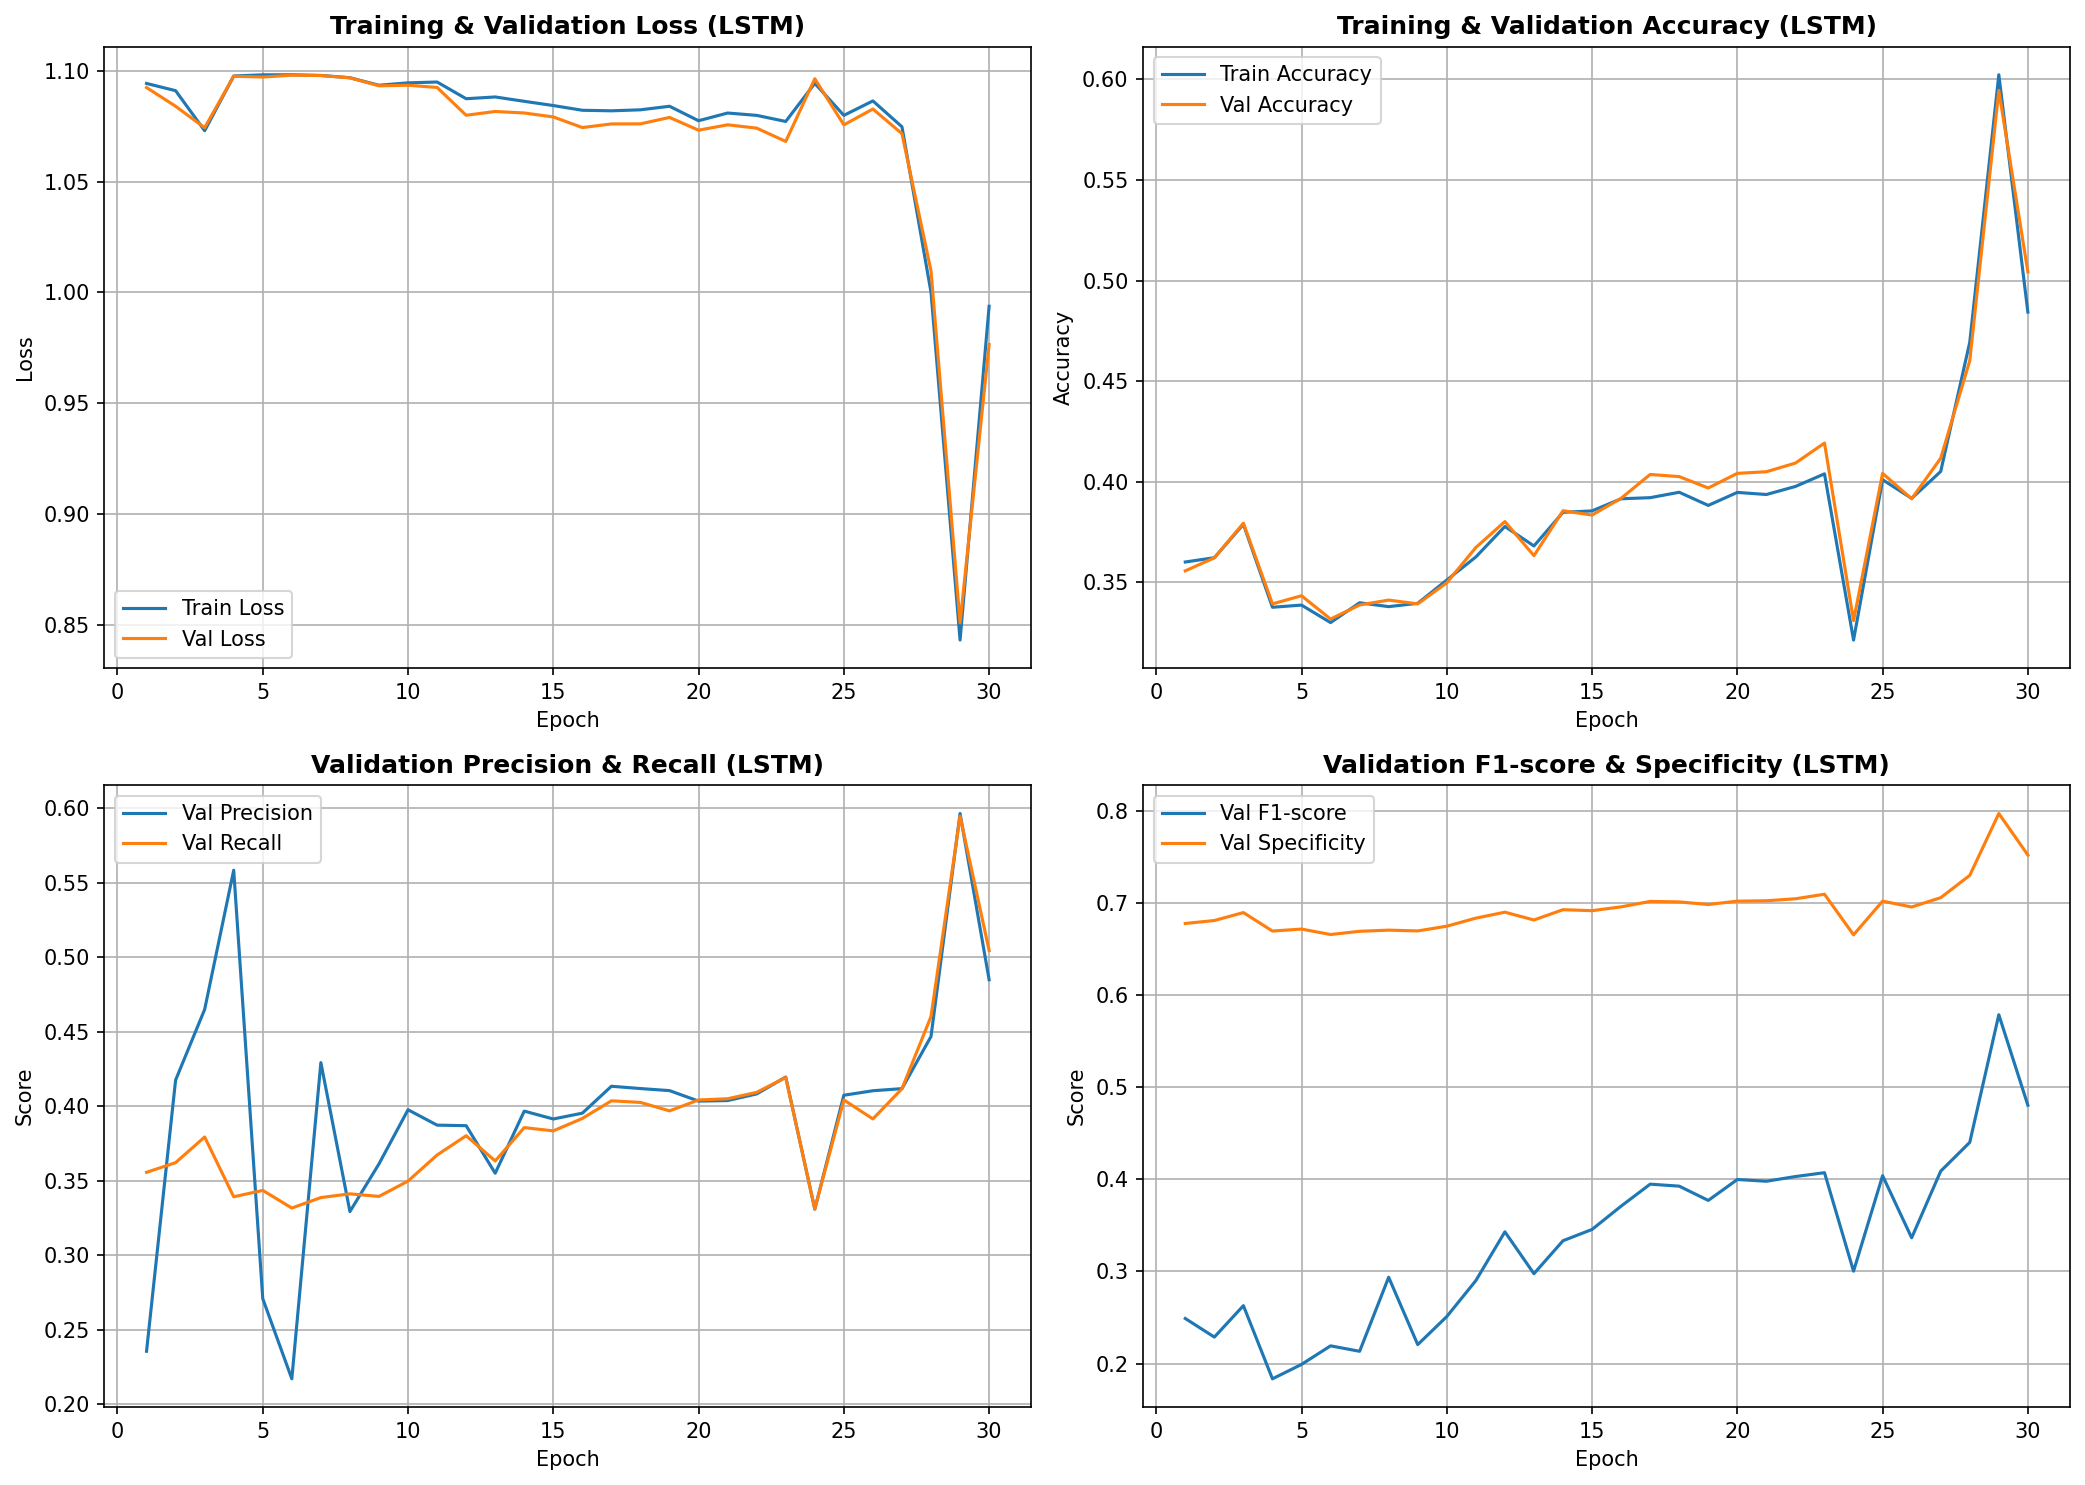

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# =========================
# PLOT TRAINING CURVES (LSTM) - 2x2 seperti contoh CNN
# =========================
epochs = np.arange(1, len(history["train_loss"]) + 1)

plt.figure(figsize=(14, 10), dpi=150)

# (1) LOSS
plt.subplot(2, 2, 1)
plt.plot(epochs, history["train_loss"], label="Train Loss")
plt.plot(epochs, history["val_loss"], label="Val Loss")
plt.title("Training & Validation Loss (LSTM)", fontweight="bold")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(True)
plt.legend()

# (2) ACCURACY
plt.subplot(2, 2, 2)
plt.plot(epochs, history["train_acc"], label="Train Accuracy")
plt.plot(epochs, history["val_acc"], label="Val Accuracy")
plt.title("Training & Validation Accuracy (LSTM)", fontweight="bold")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.grid(True)
plt.legend()

# (3) PRECISION & RECALL (VALIDATION)
plt.subplot(2, 2, 3)
plt.plot(epochs, history["val_prec"], label="Val Precision")
plt.plot(epochs, history["val_rec"], label="Val Recall")
plt.title("Validation Precision & Recall (LSTM)", fontweight="bold")
plt.xlabel("Epoch")
plt.ylabel("Score")
plt.grid(True)
plt.legend()

# (4) F1 & SPECIFICITY (VALIDATION)
plt.subplot(2, 2, 4)
plt.plot(epochs, history["val_f1"], label="Val F1-score")
plt.plot(epochs, history["val_spec"], label="Val Specificity")
plt.title("Validation F1-score & Specificity (LSTM)", fontweight="bold")
plt.xlabel("Epoch")
plt.ylabel("Score")
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()


# **METODE HGNN **

Pada metode ini, sinyal EKG dimodelkan dalam bentuk struktur graf untuk menangkap hubungan antar segmen sinyal yang tidak dapat direpresentasikan secara optimal oleh model berbasis sekuens maupun konvolusi. Input pada tahap ini berupa seluruh data EKG hasil preprocessing yang telah dibagi menjadi data latih dan data uji, kemudian digabung kembali menjadi satu kesatuan data dengan total 37.152 node, di mana setiap node merepresentasikan satu segmen sinyal EKG berdimensi 2500 fitur. Seluruh fitur dinormalisasi menggunakan StandardScaler untuk memastikan setiap dimensi fitur berada pada skala yang seragam sebelum diproses oleh model graf.

Untuk membangun struktur graf, digunakan pendekatan k-nearest neighbors (k-NN) dengan nilai 𝑘=10
k=10, di mana setiap node dihubungkan dengan sepuluh node terdekat berdasarkan jarak Euclidean pada ruang fitur. Proses ini menghasilkan edge index yang merepresentasikan hubungan antar node dalam graf, kemudian diubah menjadi graf tak berarah (undirected graph) dan ditambahkan self-loop untuk mempertahankan informasi node itu sendiri. Hasil dari tahap ini adalah sebuah graf dengan 37.152 node dan 762.372 edge yang siap digunakan sebagai input model HGNN.

Arsitektur model HGNN yang digunakan mengadopsi pendekatan GraphSAGE sebagai bentuk implementasi hypergraph neural network yang stabil. Model terdiri dari dua lapisan GraphSAGE convolution dengan ukuran hidden layer sebesar 128 unit, diikuti oleh dropout untuk mencegah overfitting, serta fully connected layer pada tahap akhir untuk menghasilkan prediksi tiga kelas, yaitu AFIB, AFL, dan Normal. Proses pelatihan dilakukan menggunakan fungsi loss Cross Entropy dan optimizer Adam dengan learning rate sebesar 0.001 serta weight decay untuk regularisasi. Pelatihan dijalankan selama 50 epoch dengan mekanisme pemilihan model terbaik berdasarkan nilai validation F1-score tertinggi.

Selama pelatihan, dilakukan evaluasi performa model menggunakan beberapa metrik, yaitu accuracy, precision, recall (sensitivity), F1-score, dan specificity. Evaluasi dilakukan secara terpisah pada data latih dan data uji menggunakan masking pada node graf. Output dari tahap ini berupa model HGNN terlatih, kurva pelatihan (training curves), confusion matrix, serta classification report. Berdasarkan hasil evaluasi, model HGNN mampu menangkap hubungan antar segmen sinyal EKG melalui struktur graf, namun performanya masih berada di bawah model CNN, yang menunjukkan bahwa meskipun pendekatan graf mampu memodelkan relasi global antar data, ekstraksi fitur morfologi lokal pada sinyal EKG lebih efektif dilakukan oleh model konvolusional.

In [48]:
!pip -q install torch-scatter torch-sparse torch-cluster torch-spline-conv -f https://data.pyg.org/whl/torch-$(python -c "import torch; print(torch.__version__.split('+')[0])")+cu121.html
!pip -q install torch-geometric


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 108.0/108.0 kB 6.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 210.0/210.0 kB 15.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.5/54.5 kB 4.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.7/63.7 kB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 59.8 MB/s eta 0:00:00


In [49]:
import os, random
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

from sklearn.metrics import (
    confusion_matrix,
    classification_report,
    precision_recall_fscore_support,
    accuracy_score
)

In [50]:
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

set_seed(42)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

Device: cpu


In [51]:
LABEL_NAMES = ["AFIB", "AFL", "NORMAL"]

def compute_metrics(y_true, y_pred):
    acc = accuracy_score(y_true, y_pred)
    prec, rec, f1, _ = precision_recall_fscore_support(
        y_true, y_pred, average="macro", zero_division=0
    )
    return acc, prec, rec, f1

In [52]:
@torch.no_grad()
def evaluate_model_classification(model, loader, device):
    model.eval()
    all_pred, all_true = [], []
    for xb, yb in loader:
        xb = xb.to(device)
        yb = yb.to(device)
        logits = model(xb)
        pred = torch.argmax(logits, dim=1)
        all_pred.append(pred.cpu().numpy())
        all_true.append(yb.cpu().numpy())

    y_true = np.concatenate(all_true)
    y_pred = np.concatenate(all_pred)

    acc, prec, rec, f1 = compute_metrics(y_true, y_pred)
    cm = confusion_matrix(y_true, y_pred, labels=[0,1,2])

    return acc, prec, rec, f1, cm, y_true, y_pred


In [53]:
class ECGWindowDataset(Dataset):
    """
    X: (N, 2000) float32
    y: (N,) int
    output for CNN/LSTM:
      - CNN wants (B, 1, 2000)
      - LSTM wants (B, 2000, 1)
    We'll reshape in __getitem__ based on mode.
    """
    def __init__(self, X, y, mode="cnn"):
        self.X = np.asarray(X, dtype=np.float32)
        self.y = np.asarray(y, dtype=np.int64)
        assert mode in ["cnn", "lstm"]
        self.mode = mode

    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        x = self.X[idx]  # (2000,)
        y = self.y[idx]
        if self.mode == "cnn":
            x = torch.tensor(x).unsqueeze(0)      # (1, 2000)
        else:
            x = torch.tensor(x).unsqueeze(-1)     # (2000, 1)
        return x, torch.tensor(y)

In [54]:
history_hgnn = {
    "train_loss": [],
    "val_loss": [],
    "train_acc": [],
    "val_acc": [],
    "train_prec": [],
    "val_prec": [],
    "train_rec": [],
    "val_rec": [],
    "train_f1": [],
    "val_f1": []
}


In [ ]:
EPOCHS = 50

for epoch in range(1, EPOCHS + 1):
    model_hgnn.train()
    optimizer.zero_grad()

    out = model_hgnn(train_data.x, train_data.edge_index)
    loss = criterion(out, train_data.y)
    loss.backward()
    optimizer.step()

    # --- eval train & val (pakai fungsi kamu eval_graph) ---
    tr_loss, tr_acc, tr_prec, tr_rec, tr_f1, _, _, _ = eval_graph(model_hgnn, train_data)
    va_loss, va_acc, va_prec, va_rec, va_f1, _, _, _ = eval_graph(model_hgnn, val_data)

    # --- SIMPAN KE HISTORY (INI YANG SERING KELUPA) ---
    history_hgnn["train_loss"].append(tr_loss)
    history_hgnn["val_loss"].append(va_loss)
    history_hgnn["train_acc"].append(tr_acc)
    history_hgnn["val_acc"].append(va_acc)
    history_hgnn["train_prec"].append(tr_prec)
    history_hgnn["val_prec"].append(va_prec)
    history_hgnn["train_rec"].append(tr_rec)
    history_hgnn["val_rec"].append(va_rec)
    history_hgnn["train_f1"].append(tr_f1)
    history_hgnn["val_f1"].append(va_f1)

    print(f"Epoch {epoch:02d}/{EPOCHS} | "
          f"TrainLoss {tr_loss:.4f} ValLoss {va_loss:.4f} | "
          f"TrainF1 {tr_f1:.4f} ValF1 {va_f1:.4f}")


Epoch 01/50 | TrainLoss 0.1799 ValLoss 1.2292 | TrainF1 0.9552 ValF1 0.5433
Epoch 02/50 | TrainLoss 0.1817 ValLoss 1.2464 | TrainF1 0.9531 ValF1 0.5430
Epoch 03/50 | TrainLoss 0.1767 ValLoss 1.2320 | TrainF1 0.9547 ValF1 0.5403
Epoch 04/50 | TrainLoss 0.1700 ValLoss 1.2430 | TrainF1 0.9618 ValF1 0.5488
Epoch 05/50 | TrainLoss 0.1720 ValLoss 1.2682 | TrainF1 0.9612 ValF1 0.5420
Epoch 06/50 | TrainLoss 0.1709 ValLoss 1.2643 | TrainF1 0.9552 ValF1 0.5339
Epoch 07/50 | TrainLoss 0.1656 ValLoss 1.2699 | TrainF1 0.9636 ValF1 0.5438
Epoch 08/50 | TrainLoss 0.1664 ValLoss 1.2877 | TrainF1 0.9629 ValF1 0.5385
Epoch 09/50 | TrainLoss 0.1624 ValLoss 1.2849 | TrainF1 0.9614 ValF1 0.5398
Epoch 10/50 | TrainLoss 0.1573 ValLoss 1.2821 | TrainF1 0.9658 ValF1 0.5422
Epoch 11/50 | TrainLoss 0.1603 ValLoss 1.2911 | TrainF1 0.9631 ValF1 0.5402
Epoch 12/50 | TrainLoss 0.1553 ValLoss 1.2754 | TrainF1 0.9637 ValF1 0.5444
Epoch 13/50 | TrainLoss 0.1529 ValLoss 1.2835 | TrainF1 0.9667 ValF1 0.5401
Epoch 14/50 

In [ ]:
print("Jumlah epoch di history:", len(history_hgnn["train_loss"]))


Jumlah epoch di history: 50


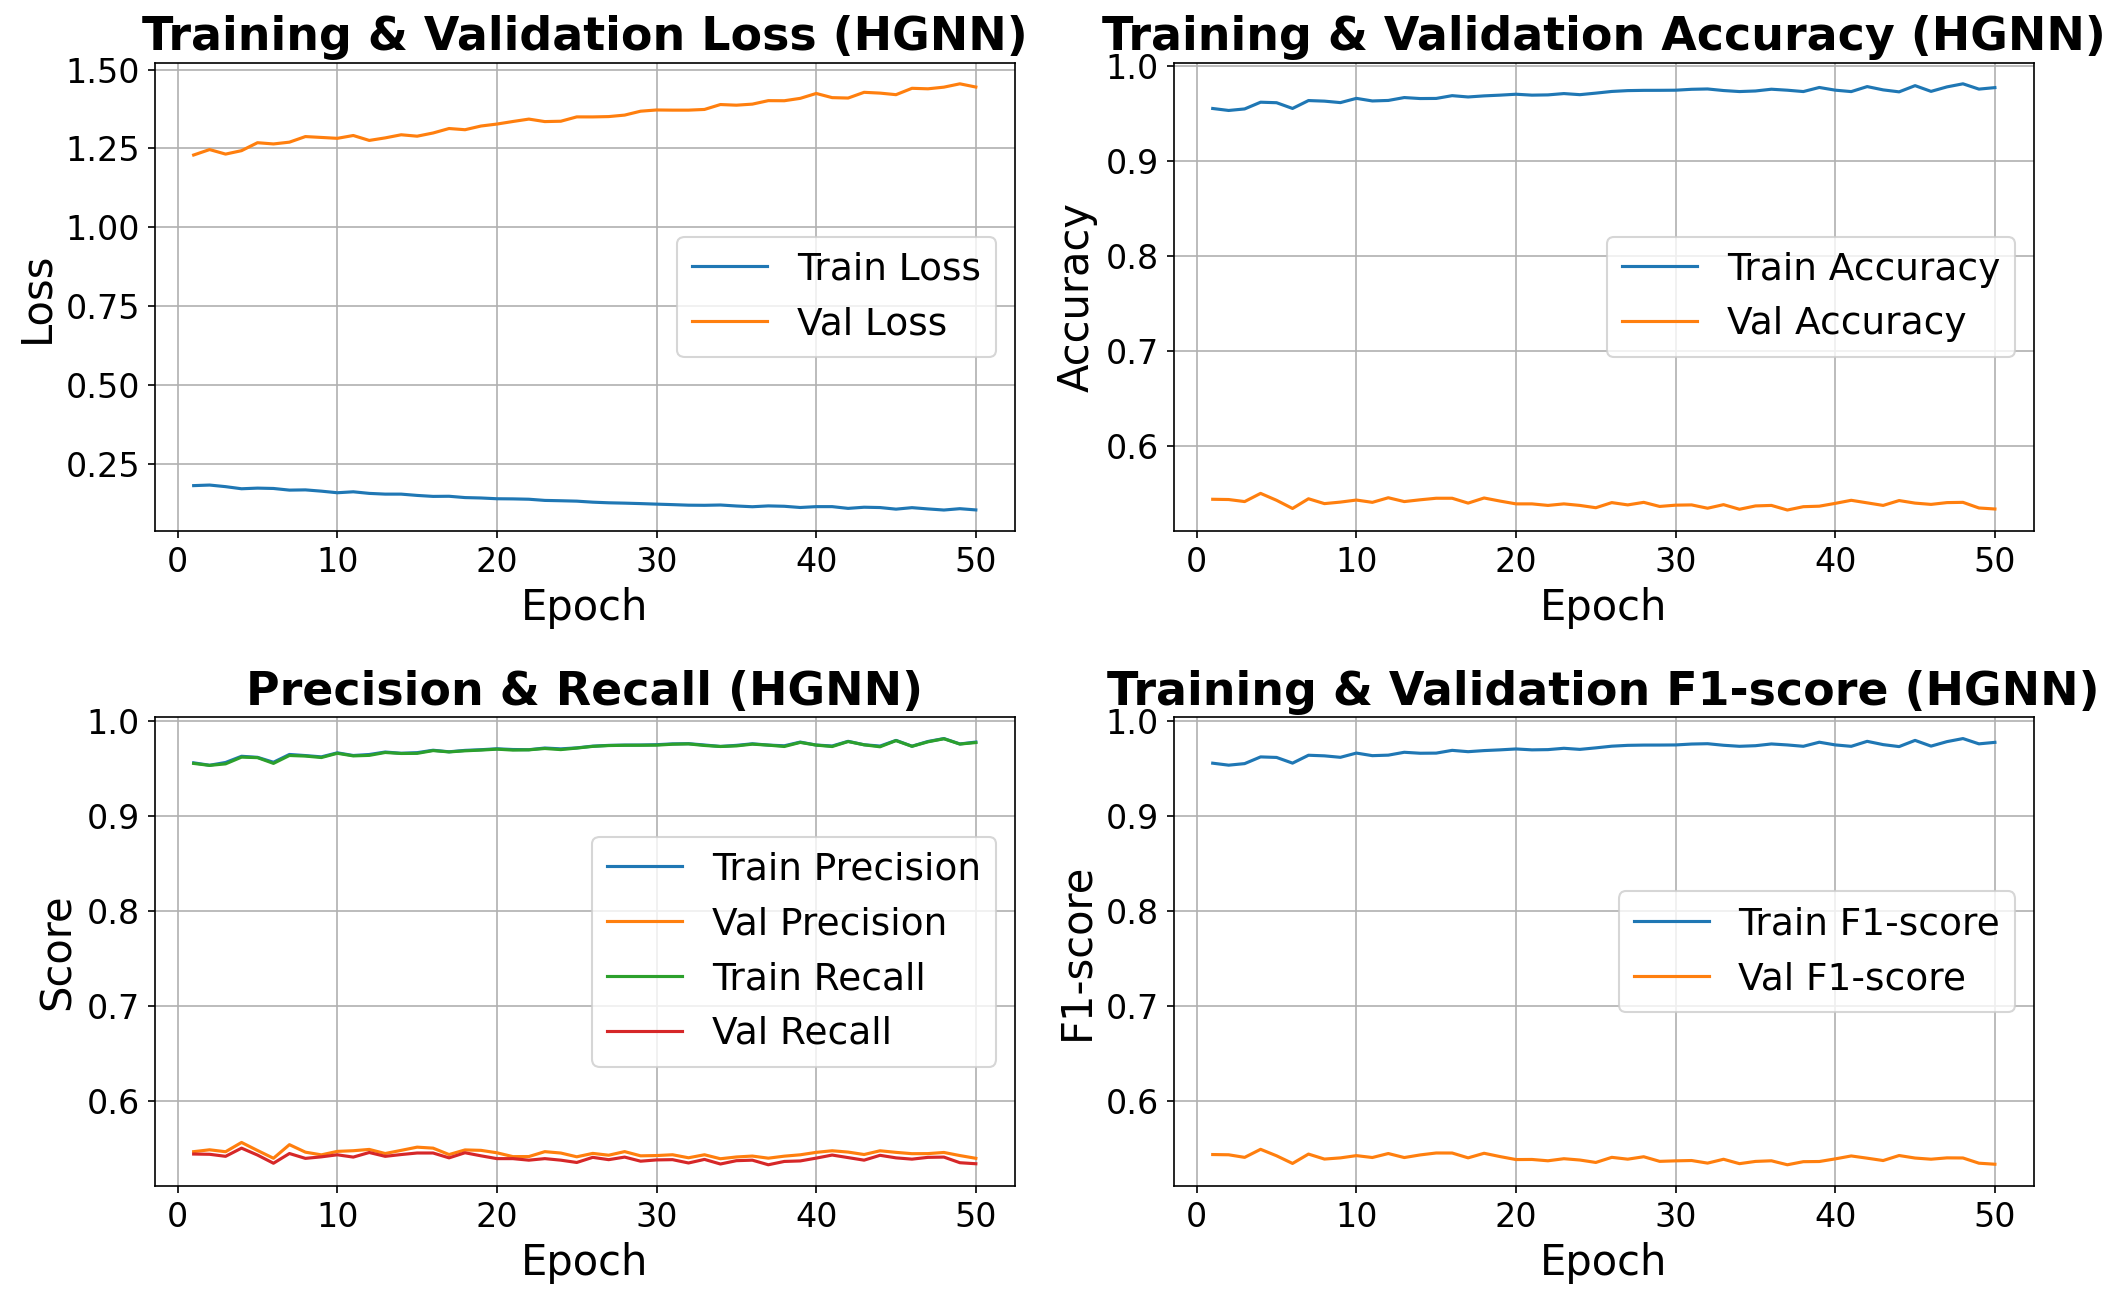

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def plot_training_hgnn(history_hgnn):
    # pastikan semuanya list dan panjangnya sama
    n = len(history_hgnn["train_loss"])
    assert n > 1, "history_hgnn cuma berisi 0/1 epoch. Pastikan append tiap epoch."
    epochs = np.arange(1, n + 1)

    plt.figure(figsize=(14, 9), dpi=150)

    # (1) LOSS
    ax1 = plt.subplot(2, 2, 1)
    ax1.plot(epochs, history_hgnn["train_loss"], label="Train Loss")
    ax1.plot(epochs, history_hgnn["val_loss"], label="Val Loss")
    ax1.set_title("Training & Validation Loss (HGNN)", fontweight="bold")
    ax1.set_xlabel("Epoch"); ax1.set_ylabel("Loss")
    ax1.grid(True); ax1.legend()

    # (2) ACC
    ax2 = plt.subplot(2, 2, 2)
    ax2.plot(epochs, history_hgnn["train_acc"], label="Train Accuracy")
    ax2.plot(epochs, history_hgnn["val_acc"], label="Val Accuracy")
    ax2.set_title("Training & Validation Accuracy (HGNN)", fontweight="bold")
    ax2.set_xlabel("Epoch"); ax2.set_ylabel("Accuracy")
    ax2.grid(True); ax2.legend()

    # (3) PREC & REC (Train vs Val biar konsisten)
    ax3 = plt.subplot(2, 2, 3)
    ax3.plot(epochs, history_hgnn["train_prec"], label="Train Precision")
    ax3.plot(epochs, history_hgnn["val_prec"], label="Val Precision")
    ax3.plot(epochs, history_hgnn["train_rec"], label="Train Recall")
    ax3.plot(epochs, history_hgnn["val_rec"], label="Val Recall")
    ax3.set_title("Precision & Recall (HGNN)", fontweight="bold")
    ax3.set_xlabel("Epoch"); ax3.set_ylabel("Score")
    ax3.grid(True); ax3.legend()

    # (4) F1 (Train vs Val)
    ax4 = plt.subplot(2, 2, 4)
    ax4.plot(epochs, history_hgnn["train_f1"], label="Train F1-score")
    ax4.plot(epochs, history_hgnn["val_f1"], label="Val F1-score")
    ax4.set_title("Training & Validation F1-score (HGNN)", fontweight="bold")
    ax4.set_xlabel("Epoch"); ax4.set_ylabel("F1-score")
    ax4.grid(True); ax4.legend()

    plt.tight_layout()
    plt.show()

plot_training_hgnn(history_hgnn)


In [ ]:
# =========================
# D) HGNN TRAINING (GraphSAGE)
# =========================
import numpy as np
import torch
import torch.nn.functional as F

from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import NearestNeighbors

from torch_geometric.data import Data
from torch_geometric.nn import SAGEConv

K = 10
EPOCHS = 50
LR = 1e-3
WEIGHT_DECAY = 1e-4

def build_knn_edge_index(X, k=10):
    """
    X: (N, F)
    return edge_index shape (2, E) torch.long (undirected + self loop)
    """
    nbrs = NearestNeighbors(n_neighbors=k+1, metric="euclidean")
    nbrs.fit(X)
    neigh = nbrs.kneighbors(X, return_distance=False)  # (N, k+1) includes self

    # buat directed edges (i -> neighbor)
    row = np.repeat(np.arange(X.shape[0]), k)
    col = neigh[:, 1:k+1].reshape(-1)  # buang self
    edge_index = np.vstack([row, col])

    # undirected: tambah kebalikannya
    rev = np.vstack([edge_index[1], edge_index[0]])
    edge_index = np.concatenate([edge_index, rev], axis=1)

    # self-loop
    self_loop = np.vstack([np.arange(X.shape[0]), np.arange(X.shape[0])])
    edge_index = np.concatenate([edge_index, self_loop], axis=1)

    return torch.tensor(edge_index, dtype=torch.long)

def make_graph_data(X_np, y_np, scaler=None, fit_scaler=False, k=10):
    X_np = np.asarray(X_np, dtype=np.float32)
    y_np = np.asarray(y_np, dtype=np.int64)

    if scaler is None:
        scaler = StandardScaler()

    if fit_scaler:
        X_scaled = scaler.fit_transform(X_np).astype(np.float32)
    else:
        X_scaled = scaler.transform(X_np).astype(np.float32)

    edge_index = build_knn_edge_index(X_scaled, k=k)

    data = Data(
        x=torch.tensor(X_scaled, dtype=torch.float32),
        y=torch.tensor(y_np, dtype=torch.long),
        edge_index=edge_index
    )
    return data, scaler

# scaler FIT hanya di TRAIN
train_data, scaler = make_graph_data(X_train, y_train, scaler=None, fit_scaler=True,  k=K)
val_data,   _      = make_graph_data(X_val,   y_val,   scaler=scaler, fit_scaler=False, k=K)
test_data,  _      = make_graph_data(X_test,  y_test,  scaler=scaler, fit_scaler=False, k=K)

train_data = train_data.to(device)
val_data   = val_data.to(device)
test_data  = test_data.to(device)

class HGNN_SAGE(nn.Module):
    def __init__(self, in_dim=2000, hidden=128, num_classes=3, dropout=0.3):
        super().__init__()
        self.conv1 = SAGEConv(in_dim, hidden)
        self.conv2 = SAGEConv(hidden, hidden)
        self.lin   = nn.Linear(hidden, num_classes)
        self.dropout = dropout

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, p=self.dropout, training=self.training)

        x = self.conv2(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, p=self.dropout, training=self.training)

        out = self.lin(x)
        return out

model_hgnn = HGNN_SAGE(in_dim=2000, hidden=128, num_classes=3, dropout=0.3).to(device)
optimizer = torch.optim.Adam(model_hgnn.parameters(), lr=LR, weight_decay=WEIGHT_DECAY)
criterion = nn.CrossEntropyLoss()

@torch.no_grad()
def eval_graph(model, data):
    model.eval()
    out = model(data.x, data.edge_index)
    pred = out.argmax(dim=1)
    y_true = data.y.detach().cpu().numpy()
    y_pred = pred.detach().cpu().numpy()
    loss = criterion(out, data.y).item()

    acc, prec, rec, f1 = compute_metrics(y_true, y_pred)
    cm = confusion_matrix(y_true, y_pred, labels=[0,1,2])
    return loss, acc, prec, rec, f1, cm, y_true, y_pred

for epoch in range(1, EPOCHS+1):
    model_hgnn.train()
    optimizer.zero_grad()

    out = model_hgnn(train_data.x, train_data.edge_index)
    loss = criterion(out, train_data.y)
    loss.backward()
    optimizer.step()

    tr_loss, tr_acc, tr_prec, tr_rec, tr_f1, _, _, _ = eval_graph(model_hgnn, train_data)
    va_loss, va_acc, va_prec, va_rec, va_f1, _, _, _ = eval_graph(model_hgnn, val_data)

    print(f"Epoch {epoch:02d}/{EPOCHS} | "
          f"TrainLoss {tr_loss:.4f} ValLoss {va_loss:.4f} | "
          f"TrainF1 {tr_f1:.4f} ValF1 {va_f1:.4f}")

# ========== TEST EVALUATION ==========
te_loss, te_acc, te_prec, te_rec, te_f1, cm, y_true, y_pred = eval_graph(model_hgnn, test_data)
print("\n=== HGNN TEST RESULT ===")
print("Loss     :", te_loss)
print("Accuracy :", te_acc)
print("Precision:", te_prec)
print("Recall   :", te_rec)
print("F1-score :", te_f1)
print("\nConfusion Matrix:\n", cm)
print("\nClassification Report:\n", classification_report(y_true, y_pred, target_names=LABEL_NAMES, digits=4))


Epoch 01/50 | TrainLoss 1.0773 ValLoss 1.0793 | TrainF1 0.3111 ValF1 0.3215
Epoch 02/50 | TrainLoss 1.0595 ValLoss 1.0733 | TrainF1 0.3320 ValF1 0.3226
Epoch 03/50 | TrainLoss 1.0484 ValLoss 1.0711 | TrainF1 0.3680 ValF1 0.3284
Epoch 04/50 | TrainLoss 1.0289 ValLoss 1.0577 | TrainF1 0.4603 ValF1 0.3883
Epoch 05/50 | TrainLoss 1.0192 ValLoss 1.0534 | TrainF1 0.4834 ValF1 0.4068
Epoch 06/50 | TrainLoss 1.0046 ValLoss 1.0445 | TrainF1 0.4940 ValF1 0.4133
Epoch 07/50 | TrainLoss 0.9939 ValLoss 1.0399 | TrainF1 0.4996 ValF1 0.4149
Epoch 08/50 | TrainLoss 0.9825 ValLoss 1.0353 | TrainF1 0.5051 ValF1 0.4142
Epoch 09/50 | TrainLoss 0.9721 ValLoss 1.0318 | TrainF1 0.5116 ValF1 0.4130
Epoch 10/50 | TrainLoss 0.9610 ValLoss 1.0278 | TrainF1 0.5215 ValF1 0.4198
Epoch 11/50 | TrainLoss 0.9492 ValLoss 1.0233 | TrainF1 0.5322 ValF1 0.4230
Epoch 12/50 | TrainLoss 0.9375 ValLoss 1.0192 | TrainF1 0.5438 ValF1 0.4313
Epoch 13/50 | TrainLoss 0.9249 ValLoss 1.0150 | TrainF1 0.5504 ValF1 0.4370
Epoch 14/50 

In [ ]:
#revisi per epoch HGNN agar ke baca
import os
import numpy as np
import pandas as pd
import torch
import torch.nn as nn

# ====== Folder output Google Drive ======
OUT_DIR = "/content/drive/MyDrive/Tugas Akhir/training_logs"
os.makedirs(OUT_DIR, exist_ok=True)
print("✅ Output folder:", OUT_DIR)

# =========================================================
# WAJIB: definisikan fungsi specificity (biar aman)
# =========================================================
def calc_specificity_from_cm(cm):
    """
    cm: confusion matrix shape (C,C)
    return macro specificity
    """
    cm = np.asarray(cm, dtype=np.int64)
    C = cm.shape[0]
    specs = []
    for i in range(C):
        TP = cm[i, i]
        FN = cm[i, :].sum() - TP
        FP = cm[:, i].sum() - TP
        TN = cm.sum() - (TP + FN + FP)
        spec = TN / (TN + FP) if (TN + FP) > 0 else 0.0
        specs.append(spec)
    return float(np.mean(specs))

# =========================================================
# Pastikan ini sudah ada dari kode HGNN kamu:
# - model_hgnn, optimizer, criterion
# - train_data, val_data
# - eval_graph(model, data) -> return (loss, acc, prec, rec, f1, cm, y_true, y_pred)
# - EPOCHS
# =========================================================

# ====== history per epoch (INI YANG BENER) ======
history_hgnn = {
    "epoch": [],
    "train_loss": [], "val_loss": [],
    "train_accuracy": [], "val_accuracy": [],
    "train_precision": [], "val_precision": [],
    "train_recall": [], "val_recall": [],
    "train_f1_score": [], "val_f1_score": [],
    "train_specificity": [], "val_specificity": []
}

for epoch in range(1, EPOCHS + 1):
    model_hgnn.train()
    optimizer.zero_grad()

    out = model_hgnn(train_data.x, train_data.edge_index)
    loss = criterion(out, train_data.y)
    loss.backward()
    optimizer.step()

    # ====== evaluasi train & val ======
    tr_loss, tr_acc, tr_prec, tr_rec, tr_f1, tr_cm, _, _ = eval_graph(model_hgnn, train_data)
    va_loss, va_acc, va_prec, va_rec, va_f1, va_cm, _, _ = eval_graph(model_hgnn, val_data)

    tr_spec = calc_specificity_from_cm(tr_cm)
    va_spec = calc_specificity_from_cm(va_cm)

    # ====== simpan per epoch ======
    history_hgnn["epoch"].append(epoch)

    history_hgnn["train_loss"].append(tr_loss)
    history_hgnn["val_loss"].append(va_loss)

    history_hgnn["train_accuracy"].append(tr_acc)
    history_hgnn["val_accuracy"].append(va_acc)

    history_hgnn["train_precision"].append(tr_prec)
    history_hgnn["val_precision"].append(va_prec)

    history_hgnn["train_recall"].append(tr_rec)
    history_hgnn["val_recall"].append(va_rec)

    history_hgnn["train_f1_score"].append(tr_f1)
    history_hgnn["val_f1_score"].append(va_f1)

    history_hgnn["train_specificity"].append(tr_spec)
    history_hgnn["val_specificity"].append(va_spec)

    print(f"Epoch {epoch:02d}/{EPOCHS} | "
          f"TrainLoss {tr_loss:.4f} ValLoss {va_loss:.4f} | "
          f"TrainF1 {tr_f1:.4f} ValF1 {va_f1:.4f}")


✅ Output folder: /content/drive/MyDrive/Tugas Akhir/training_logs
Epoch 01/50 | TrainLoss 0.4480 ValLoss 0.9801 | TrainF1 0.8438 ValF1 0.5333
Epoch 02/50 | TrainLoss 0.4385 ValLoss 0.9909 | TrainF1 0.8471 ValF1 0.5350
Epoch 03/50 | TrainLoss 0.4273 ValLoss 0.9960 | TrainF1 0.8489 ValF1 0.5377
Epoch 04/50 | TrainLoss 0.4183 ValLoss 0.9975 | TrainF1 0.8556 ValF1 0.5329
Epoch 05/50 | TrainLoss 0.4076 ValLoss 1.0030 | TrainF1 0.8630 ValF1 0.5399
Epoch 06/50 | TrainLoss 0.3999 ValLoss 1.0133 | TrainF1 0.8608 ValF1 0.5410
Epoch 07/50 | TrainLoss 0.3933 ValLoss 1.0114 | TrainF1 0.8655 ValF1 0.5347
Epoch 08/50 | TrainLoss 0.3843 ValLoss 1.0139 | TrainF1 0.8763 ValF1 0.5369
Epoch 09/50 | TrainLoss 0.3768 ValLoss 1.0268 | TrainF1 0.8723 ValF1 0.5427
Epoch 10/50 | TrainLoss 0.3689 ValLoss 1.0214 | TrainF1 0.8782 ValF1 0.5425
Epoch 11/50 | TrainLoss 0.3638 ValLoss 1.0244 | TrainF1 0.8876 ValF1 0.5411
Epoch 12/50 | TrainLoss 0.3505 ValLoss 1.0264 | TrainF1 0.8911 ValF1 0.5445
Epoch 13/50 | TrainLos

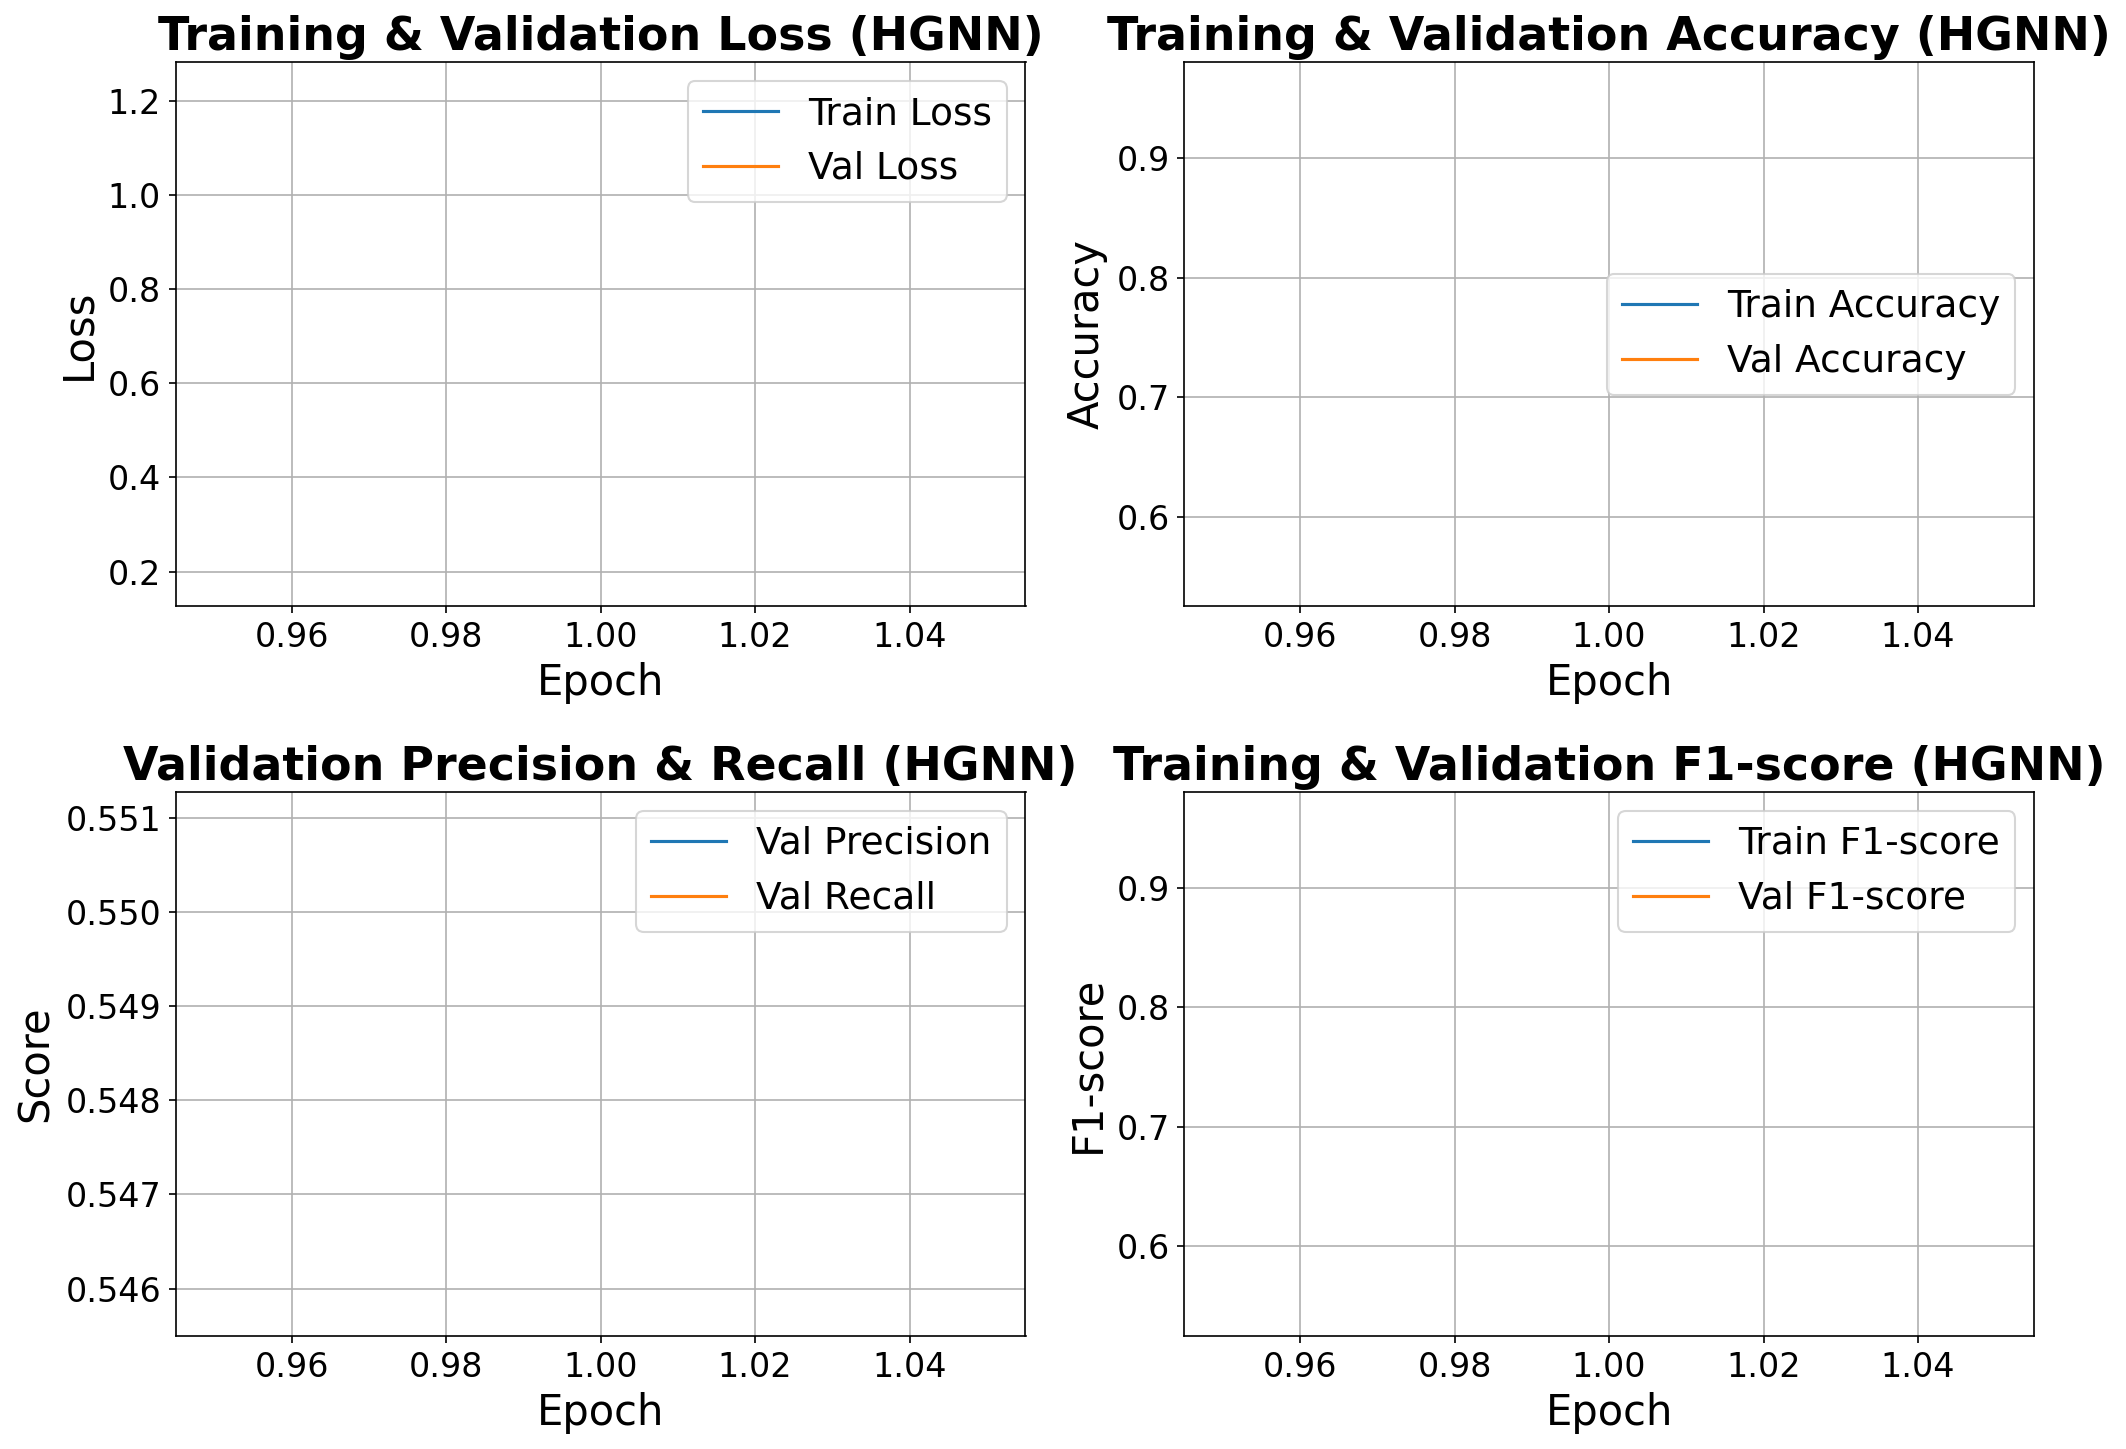

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

epochs = np.arange(1, len(history_hgnn["train_loss"]) + 1)

plt.figure(figsize=(14, 10), dpi=150)

# (1) LOSS
plt.subplot(2, 2, 1)
plt.plot(epochs, history_hgnn["train_loss"], label="Train Loss")
plt.plot(epochs, history_hgnn["val_loss"], label="Val Loss")
plt.title("Training & Validation Loss (HGNN)", fontweight="bold")
plt.xlabel("Epoch"); plt.ylabel("Loss")
plt.grid(True); plt.legend()

# (2) ACC
plt.subplot(2, 2, 2)
plt.plot(epochs, history_hgnn["train_acc"], label="Train Accuracy")
plt.plot(epochs, history_hgnn["val_acc"], label="Val Accuracy")
plt.title("Training & Validation Accuracy (HGNN)", fontweight="bold")
plt.xlabel("Epoch"); plt.ylabel("Accuracy")
plt.grid(True); plt.legend()

# (3) PREC & REC (Validation)
plt.subplot(2, 2, 3)
plt.plot(epochs, history_hgnn["val_prec"], label="Val Precision")
plt.plot(epochs, history_hgnn["val_rec"], label="Val Recall")
plt.title("Validation Precision & Recall (HGNN)", fontweight="bold")
plt.xlabel("Epoch"); plt.ylabel("Score")
plt.grid(True); plt.legend()

# (4) F1 (Train vs Val)
plt.subplot(2, 2, 4)
plt.plot(epochs, history_hgnn["train_f1"], label="Train F1-score")
plt.plot(epochs, history_hgnn["val_f1"], label="Val F1-score")
plt.title("Training & Validation F1-score (HGNN)", fontweight="bold")
plt.xlabel("Epoch"); plt.ylabel("F1-score")
plt.grid(True); plt.legend()

plt.tight_layout()
plt.show()


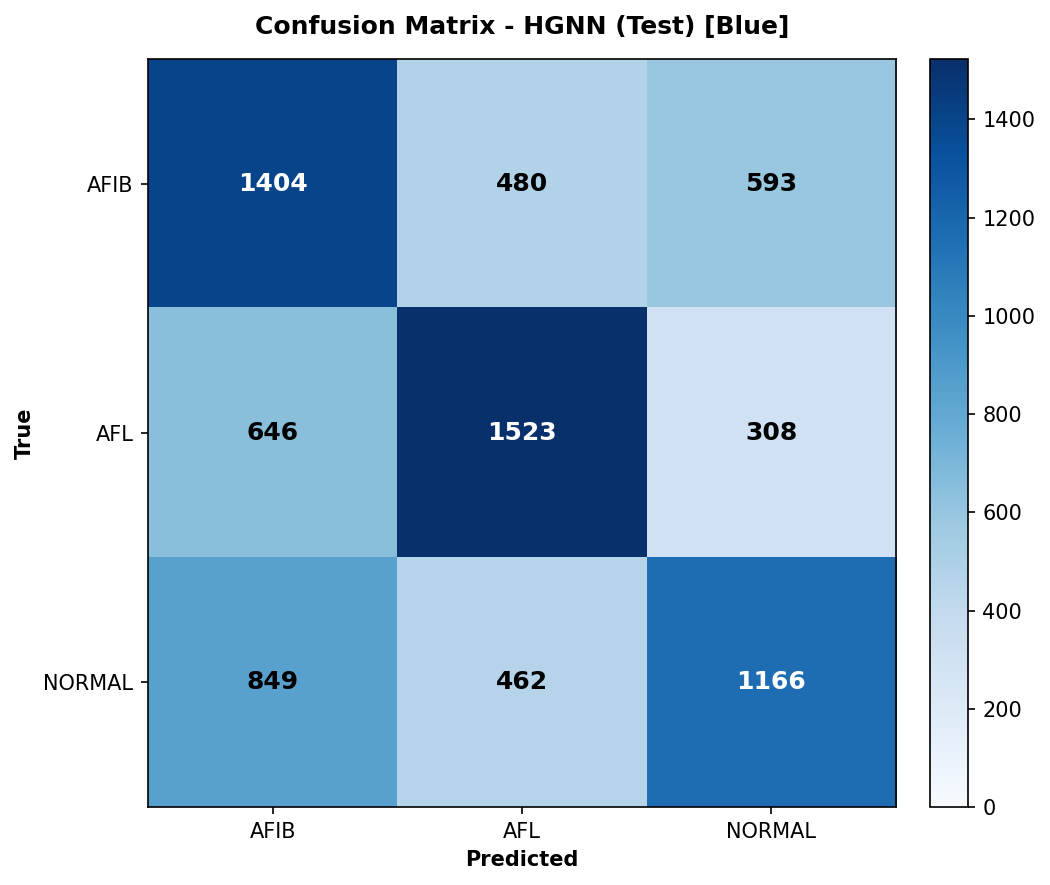

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def plot_confusion_matrix_blue(cm, labels, title="Confusion Matrix - HGNN (Test)"):
    cm = np.asarray(cm)

    plt.figure(figsize=(7, 6), dpi=150)
    im = plt.imshow(cm, interpolation="nearest", cmap=plt.cm.Blues, vmin=0)
    plt.title(title, fontweight="bold", pad=12)
    plt.colorbar(im, fraction=0.046, pad=0.04)

    tick_marks = np.arange(len(labels))
    plt.xticks(tick_marks, labels, rotation=0)
    plt.yticks(tick_marks, labels)

    thresh = cm.max() * 0.6 if cm.max() > 0 else 0
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            plt.text(
                j, i, f"{cm[i, j]}",
                ha="center", va="center",
                color="white" if cm[i, j] > thresh else "black",
                fontsize=12, fontweight="bold"
            )

    plt.ylabel("True", fontweight="bold")
    plt.xlabel("Predicted", fontweight="bold")
    plt.tight_layout()
    plt.show()

# ====== ambil hasil test (kalau belum) ======
te_loss, te_acc, te_prec, te_rec, te_f1, cm_test_hgnn, y_true_hgnn, y_pred_hgnn = eval_graph(model_hgnn, test_data)

plot_confusion_matrix_blue(cm_test_hgnn, LABEL_NAMES, title="Confusion Matrix - HGNN (Test) [Blue]")


# **perbandingan dari ketiga model**

In [ ]:
import numpy as np
import pandas as pd
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

LABEL_NAMES = ["AFIB", "AFL", "NORMAL"]
LABELS = [0, 1, 2]

def multiclass_specificity_macro(y_true, y_pred, labels=(0,1,2)):
    cm = confusion_matrix(y_true, y_pred, labels=list(labels))
    total = cm.sum()
    specs = []
    for i in range(len(labels)):
        TP = cm[i, i]
        FN = cm[i, :].sum() - TP
        FP = cm[:, i].sum() - TP
        TN = total - (TP + FN + FP)
        denom = TN + FP
        specs.append((TN / denom) if denom > 0 else 0.0)
    return float(np.mean(specs))

def metrics_row(model_name, y_true, y_pred, labels=(0,1,2)):
    y_true = np.asarray(y_true).astype(int)
    y_pred = np.asarray(y_pred).astype(int)

    return {
        "Model": model_name,
        "Accuracy": float(accuracy_score(y_true, y_pred)),
        "Precision (macro)": float(precision_score(y_true, y_pred, labels=list(labels), average="macro", zero_division=0)),
        "Recall/Sensitivity (macro)": float(recall_score(y_true, y_pred, labels=list(labels), average="macro", zero_division=0)),
        "F1-Score (macro)": float(f1_score(y_true, y_pred, labels=list(labels), average="macro", zero_division=0)),
        "Specificity (macro)": float(multiclass_specificity_macro(y_true, y_pred, labels=labels)),
    }

# ======= BUAT TABEL =======
rows = [
    metrics_row("CNN",  y_true_cnn,  y_pred_cnn,  labels=LABELS),
    metrics_row("LSTM", y_true_lstm, y_pred_lstm, labels=LABELS),
    metrics_row("HGNN", y_true_hgnn, y_pred_hgnn, labels=LABELS),
]

df_compare = pd.DataFrame(rows).sort_values("F1-Score (macro)", ascending=False).reset_index(drop=True)

print("=== TABEL PERBANDINGAN MODEL ===")
display(df_compare)

# (opsional) cek apakah ada kelas yang hilang di prediksi
def check_classes(name, y_true, y_pred):
    ut, ct = np.unique(y_true, return_counts=True)
    up, cp = np.unique(y_pred, return_counts=True)
    print(f"\n[{name}] y_true:", dict(zip(ut, ct)))
    print(f"[{name}] y_pred:", dict(zip(up, cp)))

check_classes("CNN",  y_true_cnn,  y_pred_cnn)
check_classes("LSTM", y_true_lstm, y_pred_lstm)
check_classes("HGNN", y_true_hgnn, y_pred_hgnn)


NameError: name 'y_true_cnn' is not defined

In [ ]:
# =========================
# GLOBAL FONT SETTING
# =========================
plt.rcParams.update({
    "font.size": 18,
    "axes.titlesize": 22,
    "axes.labelsize": 20,
    "xtick.labelsize": 16,
    "ytick.labelsize": 16
})

df_compare["Rank"] = df_compare["Model"].map({
    "HGNN": 1,
    "CNN": 2,
    "LSTM": 3
})

df_compare = df_compare.sort_values("Rank").drop(columns="Rank").reset_index(drop=True)

display(df_compare)


NameError: name 'df_compare' is not defined

In [ ]:
import matplotlib.pyplot as plt

# =========================
# GLOBAL FONT SETTING
# =========================
plt.rcParams.update({
    "font.size": 18,
    "axes.titlesize": 22,
    "axes.labelsize": 20,
    "xtick.labelsize": 16,
    "ytick.labelsize": 16
})

metrics = ["Accuracy", "Precision", "Recall (Sensitivity)", "F1-Score"]

df_plot = df_compare.set_index("Model")[metrics]

df_plot.plot(
    kind="bar",
    figsize=(10,5)
)

plt.title("Perbandingan Kinerja Model CNN, LSTM, dan HGNN")
plt.ylabel("Score")
plt.ylim(0, 1)
plt.grid(axis="y")
plt.show()


NameError: name 'df_compare' is not defined

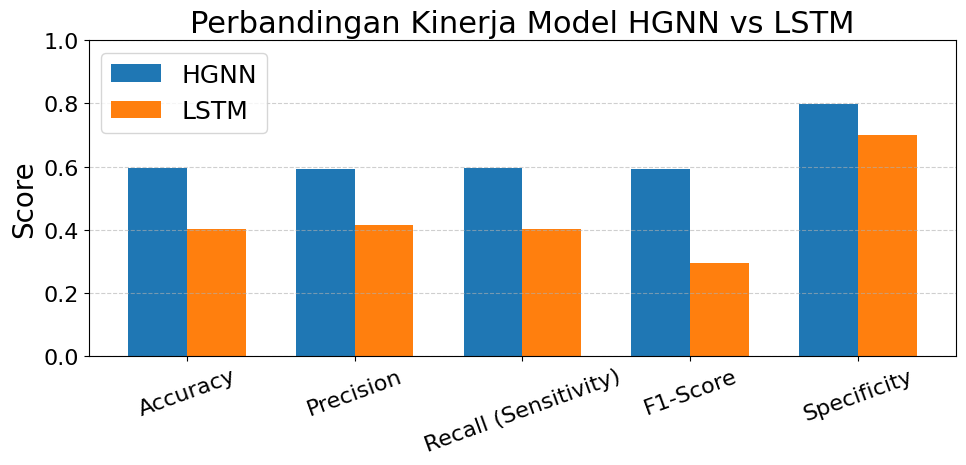

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# =========================
# GLOBAL FONT SETTING
# =========================
plt.rcParams.update({
    "font.size": 18,
    "axes.titlesize": 22,
    "axes.labelsize": 20,
    "xtick.labelsize": 16,
    "ytick.labelsize": 16
})

# ===============================
# DATA HASIL EVALUASI (FINAL)
# ===============================
data = {
    "Metric": [
        "Accuracy",
        "Precision",
        "Recall (Sensitivity)",
        "F1-Score",
        "Specificity"
    ],
    "HGNN": [0.5964, 0.5926, 0.5964, 0.5916, 0.7982],
    "LSTM": [0.4006, 0.4149, 0.4006, 0.2936, 0.7003]
}

df = pd.DataFrame(data)

# ===============================
# PLOT BAR CHART
# ===============================
x = np.arange(len(df["Metric"]))
width = 0.35

plt.figure(figsize=(10, 5))

plt.bar(x - width/2, df["HGNN"], width, label="HGNN")
plt.bar(x + width/2, df["LSTM"], width, label="LSTM")

plt.xticks(x, df["Metric"], rotation=20)
plt.ylabel("Score")
plt.ylim(0, 1)
plt.title("Perbandingan Kinerja Model HGNN vs LSTM")
plt.legend()
plt.grid(axis="y", linestyle="--", alpha=0.6)

plt.tight_layout()
plt.show()


# **Simpan hasil training dari ke 3 model (CNN, LSTM, dan HGNN)**

In [ ]:
import os
import numpy as np
import pandas as pd

# Mount Google Drive (Colab)
try:
    from google.colab import drive
    if not os.path.exists("/content/drive/MyDrive"):
        drive.mount("/content/drive")
except Exception as e:
    print("NOTE: Bukan Colab / drive mount gagal ->", e)

OUT_DIR = "/content/drive/MyDrive/Tugas Akhir/training_logs"
os.makedirs(OUT_DIR, exist_ok=True)
print("✅ Output folder:", OUT_DIR)

def as_list(x):
    """Pastikan output selalu list (bukan float tunggal)"""
    if x is None:
        return None
    if isinstance(x, (float, int, np.number)):
        return [float(x)]
    if isinstance(x, (list, tuple, np.ndarray)):
        return list(x)
    try:
        return list(x)
    except TypeError:
        return [x]

def pick(hist, key, fallback_global=None):
    """Ambil metric dari history dict; kalau tidak ada, coba ambil dari variabel global."""
    if isinstance(hist, dict) and key in hist and hist[key] is not None:
        return as_list(hist[key])

    if fallback_global is not None and fallback_global in globals() and globals()[fallback_global] is not None:
        return as_list(globals()[fallback_global])

    return None

def fix_len(x, n):
    """Samakan panjang list jadi n (pad NaN / potong)"""
    if x is None:
        return [np.nan] * n
    x = list(x)
    if len(x) < n:
        x = x + [np.nan] * (n - len(x))
    if len(x) > n:
        x = x[:n]
    return x

def save_history_to_csv(history_obj, model_tag):
    # ambil metrics (key sesuai yang kamu pakai)
    train_loss = pick(history_obj, "train_loss", "train_loss")
    val_loss   = pick(history_obj, "val_loss", "val_loss")

    train_acc  = pick(history_obj, "train_acc", "train_acc")
    val_acc    = pick(history_obj, "val_acc", "val_acc")

    train_prec = pick(history_obj, "train_prec", "train_prec")
    val_prec   = pick(history_obj, "val_prec", "val_prec")

    train_rec  = pick(history_obj, "train_rec", "train_rec")
    val_rec    = pick(history_obj, "val_rec", "val_rec")

    train_f1   = pick(history_obj, "train_f1", "train_f1")
    val_f1     = pick(history_obj, "val_f1", "val_f1")

    # optional (kalau ada)
    train_spec = pick(history_obj, "train_spec", "train_spec")
    val_spec   = pick(history_obj, "val_spec", "val_spec")

    # tentukan jumlah epoch dari list terpanjang
    cands = [train_loss, val_loss, train_acc, val_acc, train_prec, val_prec, train_rec, val_rec, train_f1, val_f1, val_spec]
    cands = [c for c in cands if c is not None and len(c) > 0]
    n_epochs = max(len(c) for c in cands) if len(cands) else 1
    epochs = list(range(1, n_epochs + 1))

    df = pd.DataFrame({
        "epoch": epochs,
        "train_loss": fix_len(train_loss, n_epochs),
        "val_loss": fix_len(val_loss, n_epochs),
        "train_accuracy": fix_len(train_acc, n_epochs),
        "val_accuracy": fix_len(val_acc, n_epochs),
        "train_precision": fix_len(train_prec, n_epochs),
        "val_precision": fix_len(val_prec, n_epochs),
        "train_recall": fix_len(train_rec, n_epochs),
        "val_recall": fix_len(val_rec, n_epochs),
        "train_f1_score": fix_len(train_f1, n_epochs),
        "val_f1_score": fix_len(val_f1, n_epochs),
        "train_specificity": fix_len(train_spec, n_epochs),
        "val_specificity": fix_len(val_spec, n_epochs),
    })

    out_path = os.path.join(OUT_DIR, f"{model_tag}_training_log.csv")
    df.to_csv(out_path, index=False)

    print(f"\n✅ {model_tag}_training_log.csv tersimpan ke Drive:")
    print(out_path)
    print("Shape:", df.shape)
    display(df.head())


✅ Output folder: /content/drive/MyDrive/Tugas Akhir/training_logs


In [ ]:
#hasil cnn
history_cnn = history


In [ ]:
save_history_to_csv(history_cnn, "CNN")



✅ CNN_training_log.csv tersimpan ke Drive:
/content/drive/MyDrive/Tugas Akhir/training_logs/CNN_training_log.csv
Shape: (30, 13)


,epoch,train_loss,val_loss,train_accuracy,val_accuracy,train_precision,val_precision,train_recall,val_recall,train_f1_score,val_f1_score,train_specificity,val_specificity
0,1,1.094345,1.092495,0.360162,0.355759,0.245352,0.235671,0.360175,0.355663,0.252863,0.248924,0.680087,0.677836
1,2,1.091081,1.084053,0.362276,0.362217,0.415070,0.417517,0.362287,0.362146,0.228579,0.228757,0.681143,0.681072
2,3,1.073007,1.074347,0.378889,0.379440,0.437685,0.464897,0.378903,0.379343,0.260721,0.262887,0.689450,0.689679
3,4,1.097704,1.097599,0.337666,0.339343,0.470886,0.558242,0.337679,0.339254,0.182718,0.183443,0.668839,0.669627
4,5,1.098224,1.097237,0.338743,0.343380,0.247296,0.270938,0.338718,0.343551,0.195754,0.199093,0.669359,0.671774


In [ ]:
# otomatis ambil history CNN
if "history_cnn" not in globals():
    if "history" in globals() and isinstance(history, dict):
        history_cnn = history
        print("✅ history_cnn di-set dari variabel 'history'")
    else:
        raise ValueError("Tidak menemukan 'history_cnn' maupun 'history' (dict). Pastikan training CNN sudah jalan dan menyimpan history.")

save_history_to_csv(history_cnn, "CNN")



✅ CNN_training_log.csv tersimpan ke Drive:
/content/drive/MyDrive/Tugas Akhir/training_logs/CNN_training_log.csv
Shape: (30, 13)


,epoch,train_loss,val_loss,train_accuracy,val_accuracy,train_precision,val_precision,train_recall,val_recall,train_f1_score,val_f1_score,train_specificity,val_specificity
0,1,1.094345,1.092495,0.360162,0.355759,0.245352,0.235671,0.360175,0.355663,0.252863,0.248924,0.680087,0.677836
1,2,1.091081,1.084053,0.362276,0.362217,0.415070,0.417517,0.362287,0.362146,0.228579,0.228757,0.681143,0.681072
2,3,1.073007,1.074347,0.378889,0.379440,0.437685,0.464897,0.378903,0.379343,0.260721,0.262887,0.689450,0.689679
3,4,1.097704,1.097599,0.337666,0.339343,0.470886,0.558242,0.337679,0.339254,0.182718,0.183443,0.668839,0.669627
4,5,1.098224,1.097237,0.338743,0.343380,0.247296,0.270938,0.338718,0.343551,0.195754,0.199093,0.669359,0.671774


In [ ]:
#untuk LSTM
history_lstm = history


In [ ]:
save_history_to_csv(history_lstm, "LSTM")



✅ LSTM_training_log.csv tersimpan ke Drive:
/content/drive/MyDrive/Tugas Akhir/training_logs/LSTM_training_log.csv
Shape: (30, 13)


,epoch,train_loss,val_loss,train_accuracy,val_accuracy,train_precision,val_precision,train_recall,val_recall,train_f1_score,val_f1_score,train_specificity,val_specificity
0,1,1.094345,1.092495,0.360162,0.355759,0.245352,0.235671,0.360175,0.355663,0.252863,0.248924,0.680087,0.677836
1,2,1.091081,1.084053,0.362276,0.362217,0.415070,0.417517,0.362287,0.362146,0.228579,0.228757,0.681143,0.681072
2,3,1.073007,1.074347,0.378889,0.379440,0.437685,0.464897,0.378903,0.379343,0.260721,0.262887,0.689450,0.689679
3,4,1.097704,1.097599,0.337666,0.339343,0.470886,0.558242,0.337679,0.339254,0.182718,0.183443,0.668839,0.669627
4,5,1.098224,1.097237,0.338743,0.343380,0.247296,0.270938,0.338718,0.343551,0.195754,0.199093,0.669359,0.671774


In [ ]:
# otomatis ambil history LSTM
if "history_lstm" not in globals():
    if "history" in globals() and isinstance(history, dict):
        history_lstm = history
        print("✅ history_lstm di-set dari variabel 'history'")
    else:
        raise ValueError("Tidak menemukan 'history_lstm' maupun 'history' (dict). Pastikan training LSTM sudah jalan dan menyimpan history.")

save_history_to_csv(history_lstm, "LSTM")



✅ LSTM_training_log.csv tersimpan ke Drive:
/content/drive/MyDrive/Tugas Akhir/training_logs/LSTM_training_log.csv
Shape: (30, 13)


,epoch,train_loss,val_loss,train_accuracy,val_accuracy,train_precision,val_precision,train_recall,val_recall,train_f1_score,val_f1_score,train_specificity,val_specificity
0,1,1.094345,1.092495,0.360162,0.355759,0.245352,0.235671,0.360175,0.355663,0.252863,0.248924,0.680087,0.677836
1,2,1.091081,1.084053,0.362276,0.362217,0.415070,0.417517,0.362287,0.362146,0.228579,0.228757,0.681143,0.681072
2,3,1.073007,1.074347,0.378889,0.379440,0.437685,0.464897,0.378903,0.379343,0.260721,0.262887,0.689450,0.689679
3,4,1.097704,1.097599,0.337666,0.339343,0.470886,0.558242,0.337679,0.339254,0.182718,0.183443,0.668839,0.669627
4,5,1.098224,1.097237,0.338743,0.343380,0.247296,0.270938,0.338718,0.343551,0.195754,0.199093,0.669359,0.671774


In [ ]:
#untuk HGNN
history_hgnn = {
    "epoch": [],
    "train_loss": [],
    "val_loss": [],
    "train_acc": [],
    "val_acc": [],
    "train_prec": [],
    "val_prec": [],
    "train_rec": [],
    "val_rec": [],
    "train_f1": [],
    "val_f1": []
}


In [ ]:
history_hgnn["epoch"].append(epoch)

history_hgnn["train_loss"].append(tr_loss)
history_hgnn["val_loss"].append(va_loss)

history_hgnn["train_acc"].append(tr_acc)
history_hgnn["val_acc"].append(va_acc)

history_hgnn["train_prec"].append(tr_prec)
history_hgnn["val_prec"].append(va_prec)

history_hgnn["train_rec"].append(tr_rec)
history_hgnn["val_rec"].append(va_rec)

history_hgnn["train_f1"].append(tr_f1)
history_hgnn["val_f1"].append(va_f1)


In [ ]:
df_hgnn = pd.DataFrame(history_hgnn)

csv_path = os.path.join(OUT_DIR, "HGNN_training_log.csv")
df_hgnn.to_csv(csv_path, index=False)

print("✅ HGNN_training_log.csv tersimpan:", csv_path)
print("Jumlah baris (epoch):", len(df_hgnn))
df_hgnn.head()


✅ HGNN_training_log.csv tersimpan: /content/drive/MyDrive/Tugas Akhir/training_logs/HGNN_training_log.csv
Jumlah baris (epoch): 1


,epoch,train_loss,val_loss,train_acc,val_acc,train_prec,val_prec,train_rec,val_rec,train_f1,val_f1
0,50,0.178581,1.229261,0.959277,0.545748,0.960036,0.551007,0.959277,0.545758,0.959353,0.54514
